In [ ]:
!pip install nba_api

## Defining all the needed functions and imports

### Import statements

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    KFold,
    learning_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    StackingClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from nba_api.stats.endpoints import (
    playergamelog,
    playernextngames,
    commonplayerinfo,
    leaguedashteamstats,
    teaminfocommon,
    teamgamelogs,
    playerindex
)
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import seaborn as sns
import warnings

### Data Setup: Mappings + Utility Functions

In [ ]:
TEAM_NAME_TO_ID = {
    "Atlanta": 1610612737, "Boston": 1610612738, "Brooklyn": 1610612751, "Charlotte": 1610612766,
    "Chicago": 1610612741, "Cleveland": 1610612739, "Dallas": 1610612742, "Denver": 1610612743,
    "Detroit": 1610612765, "Golden State": 1610612744, "Houston": 1610612745, "Indiana": 1610612754,
    "LA Clippers": 1610612746, "Lakers": 1610612747, "Memphis": 1610612763, "Miami": 1610612748,
    "Milwaukee": 1610612749, "Minnesota": 1610612750, "New Orleans": 1610612740, "New York": 1610612752,
    "Oklahoma City": 1610612760, "Orlando": 1610612753, "Philadelphia": 1610612755, "Phoenix": 1610612756,
    "Portland": 1610612757, "Sacramento": 1610612758, "San Antonio": 1610612759, "Toronto": 1610612761,
    "Utah": 1610612762, "Washington": 1610612764
}

TEAM_ABBR_TO_ID = {
    "ATL": 1610612737, "BOS": 1610612738, "BKN": 1610612751, "CHA": 1610612766,
    "CHI": 1610612741, "CLE": 1610612739, "DAL": 1610612742, "DEN": 1610612743,
    "DET": 1610612765, "GSW": 1610612744, "HOU": 1610612745, "IND": 1610612754,
    "LAC": 1610612746, "LAL": 1610612747, "MEM": 1610612763, "MIA": 1610612748,
    "MIL": 1610612749, "MIN": 1610612750, "NOP": 1610612740, "NYK": 1610612752,
    "OKC": 1610612760, "ORL": 1610612753, "PHI": 1610612755, "PHX": 1610612756,
    "POR": 1610612757, "SAC": 1610612758, "SAS": 1610612759, "TOR": 1610612761,
    "UTA": 1610612762, "WAS": 1610612764
}

def log(message, level="INFO"):
    """
    This is to help with logging stuff such as DEBUG, INFO, etc.
    """
    print(f"[{level}]: {message}")

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

### Data Fetching Functions

In [ ]:
def fetch_player_details(player_id):
    """
    This helps fetch all the player details to verify we're getting the right player and player_id.
    """
    player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id)
    player_details = player_info.get_data_frames()[0].iloc[0]
    print("\nPlayer Details:")
    print(f"Name: {player_details['DISPLAY_FIRST_LAST']}")
    print(f"Team: {player_details['TEAM_NAME']}")
    print(f"Position: {player_details['POSITION']}")
    return player_details

def fetch_team_game_logs(season):
    """
    This fetches the team game logs for a given season.
    """
    try:
        team_game_logs = teamgamelogs.TeamGameLogs(
            season_nullable=season,
            season_type_nullable="Regular Season"
        )
        team_logs_df = team_game_logs.get_data_frames()[0]
        team_logs_df.columns = team_logs_df.columns.str.lower()
        print(f"Fetched team game logs for season {season}, shape: {team_logs_df.shape}")
        return team_logs_df
    except Exception as e:
        print(f"Error fetching team game logs: {e}")
        return pd.DataFrame()


def fetch_next_game_details(player_id, season):
    """
    This just fetches details of the player's next game, which we're trying to predict on.
    """
    player_next_games = playernextngames.PlayerNextNGames(
        player_id=player_id,
        season_type_all_star='Regular Season',
        number_of_games=1
    )
    next_game_details = player_next_games.get_data_frames()[0].iloc[0]
    print("\nNext Game Details:")
    print(next_game_details[['GAME_DATE', 'HOME_TEAM_NAME', 'VISITOR_TEAM_NAME', 'GAME_TIME']])
    return next_game_details


def fetch_player_data(player_id, seasons):
    """
    This fetches the game logs for a player across multiple seasons, which is the data we're using to predict with.
    """
    data_frames = []
    for season in seasons:
        game_log = playergamelog.PlayerGameLog(
            player_id=player_id,
            season=season,
            season_type_all_star='Regular Season'
        )
        df = game_log.get_data_frames()[0]

        df.columns = df.columns.str.lower()

        print(f"Columns in fetched player game log for season {season}: {df.columns}")
        if 'game_id' not in df.columns:
            raise ValueError(f"'game_id' not found in player game log for season {season}")

        df['season'] = season
        data_frames.append(df)
    print(f"\nFetched player data shape: {pd.concat(data_frames).shape}")
    return pd.concat(data_frames, ignore_index=True)


def fetch_team_info(team_id, season=None, season_type=None):
    """
    This fetches team info, including win percentage and rankings, which turned out to be honestly not as helpful as I thought
    """
    team_info = teaminfocommon.TeamInfoCommon(
        team_id=team_id,
        league_id="00"
    )

    try:
        team_info_common = team_info.get_data_frames()[0]
        team_season_ranks = team_info.get_data_frames()[1]

        team_features = {
            'Win_PCT': team_info_common.loc[0, 'PCT'],
            'Conf_Rank': team_info_common.loc[0, 'CONF_RANK'],
            'Div_Rank': team_info_common.loc[0, 'DIV_RANK'],
        }

        team_features.update({
            'Pts_Rank': team_season_ranks.loc[0, 'PTS_RANK'],
            'Reb_Rank': team_season_ranks.loc[0, 'REB_RANK'],
            'Ast_Rank': team_season_ranks.loc[0, 'AST_RANK'],
            'Opp_Pts_Rank': team_season_ranks.loc[0, 'OPP_PTS_RANK'],
        })

    except (KeyError, IndexError) as e:
        print(f"Error fetching team info: {e}")
        team_features = {}

    return team_features

def fetch_player_id(player_name, season="2024-25"):
    """
    This gets the PlayerID using the player's name and season.
    """
    try:
        player_index = playerindex.PlayerIndex(season=season)
        player_data = player_index.get_normalized_dict()["PlayerIndex"]

        for player in player_data:
            full_name = f"{player['PLAYER_FIRST_NAME']} {player['PLAYER_LAST_NAME']}"
            if full_name.lower() == player_name.lower():
                print(player["PERSON_ID"])
                return player["PERSON_ID"]

        raise ValueError(f"Player {player_name} not found in season {season}.")
    except Exception as e:
        raise RuntimeError(f"Error fetching PlayerID for {player_name}: {e}")

### Feature Engineering Functions

In [ ]:
def calculate_rolling_averages(player_data):
    """
    This calculates all the rolling averages for key stats we need.
    """
    stats_to_average = [
        'pts', 'ast', 'reb', 'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a',
        'ftm', 'fta', 'oreb', 'dreb', 'stl', 'blk', 'tov', 'plus_minus'
    ]
    for stat in stats_to_average:
        rolling_col = f'rolling_{stat}'
        player_data[rolling_col] = player_data[stat].rolling(window=3, min_periods=1).mean()
    print("\nRolling averages calculated successfully.")
    return player_data

def add_opponent_rankings(player_data, season):
    """
    This adds opponent rankings to the player dataset, which expanded our feature set quite notably.
    """
    team_logs = fetch_team_game_logs(season)

    team_logs.columns = team_logs.columns.str.lower()

    opponent_rank_columns = {
        "w_pct_rank": "opponent_w_pct_rank",
        "pts_rank": "opponent_pts_rank",
        "reb_rank": "opponent_reb_rank",
        "ast_rank": "opponent_ast_rank",
        "plus_minus_rank": "opponent_plus_minus_rank",
    }
    team_logs = team_logs.rename(columns=opponent_rank_columns)
    team_logs_keyed = team_logs.set_index(["team_id", "game_id"])

    opponent_data = []
    for _, row in player_data.iterrows():
        matchup = row["matchup"]
        player_team_abbr = matchup.split(" ")[0]
        opponent_team_abbr = matchup.split(" ")[-1]

        if "@" in matchup:
            opponent_team_abbr = opponent_team_abbr
        elif "vs." in matchup:
            opponent_team_abbr = opponent_team_abbr

        player_team_id = TEAM_ABBR_TO_ID.get(player_team_abbr)
        opponent_team_id = TEAM_ABBR_TO_ID.get(opponent_team_abbr)

        if opponent_team_id is None:
            print(f"Error: Team abbreviation not found for {opponent_team_abbr}.")
            opponent_stats = {col: np.nan for col in opponent_rank_columns.values()}
        else:
            game_id = row["game_id"]
            try:
                opponent_stats = team_logs_keyed.loc[(opponent_team_id, game_id)].to_dict()
            except KeyError:
                opponent_stats = {col: np.nan for col in opponent_rank_columns.values()}

        opponent_data.append(opponent_stats)

    opponent_df = pd.DataFrame(opponent_data)
    player_data = pd.concat([player_data.reset_index(drop=True), opponent_df.reset_index(drop=True)], axis=1)

    return player_data


def extract_opponent_abbreviation(matchup):
    """
    This extracts the opponent team abbreviation from the matchup string.
    """
    if "vs." in matchup:
        return matchup.split("vs.")[-1].strip()
    elif "@" in matchup:
        return matchup.split("@")[-1].strip()
    else:
        print(f"Invalid matchup format: {matchup}")
        return None

def fetch_next_opponent_features(next_game_details, season):
    """
    This fetches the next opponent's info for feature engineering.
    """
    if 'HOME_TEAM_NAME' in next_game_details and 'VISITOR_TEAM_NAME' in next_game_details:
        if next_game_details['HOME_TEAM_NAME'] == next_game_details.get('TEAM_NAME', ''):
            opponent_team_name = next_game_details['VISITOR_TEAM_NAME']
        else:
            opponent_team_name = next_game_details['HOME_TEAM_NAME']
    else:
        raise KeyError("Required team name columns missing in next_game_details.")

    if opponent_team_name in TEAM_NAME_TO_ID:
        opponent_team_id = TEAM_NAME_TO_ID[opponent_team_name]

        current_features = fetch_team_info(opponent_team_id, season)

    else:
        log(f"Opponent team name {opponent_team_name} not found in mapping.")
        current_features = {}

    return current_features

def combine_features(player_data, opponent_features):
    """
    This combines all the features we created and wanted into model inputs.
    """
    features = pd.DataFrame()

    stats_to_include = ['pts', 'ast', 'reb', 'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a',
                        'ftm', 'fta', 'oreb', 'dreb', 'stl', 'blk', 'tov', 'plus_minus']
    for stat in stats_to_include:
        rolling_col = f'rolling_{stat}'
        if rolling_col in player_data.columns:
            features[rolling_col] = player_data[rolling_col]

    ranking_features = [
        'gp_rank', 'w_rank', 'l_rank', 'opponent_w_pct_rank', 'min_rank',
        'fgm_rank', 'fga_rank', 'fg_pct_rank', 'fg3m_rank', 'fg3a_rank',
        'fg3_pct_rank', 'ftm_rank', 'fta_rank', 'ft_pct_rank', 'oreb_rank',
        'dreb_rank', 'opponent_reb_rank', 'opponent_ast_rank', 'tov_rank',
        'stl_rank', 'blk_rank', 'blka_rank', 'pf_rank', 'pfd_rank',
        'opponent_pts_rank', 'opponent_plus_minus_rank'
    ]
    for rank in ranking_features:
        if rank in player_data.columns:
            features[rank] = player_data[rank]

    for key, value in opponent_features.items():
        features[key] = value

    print("\n[Debug] Combined features shape:", features.shape)
    print("[Debug] Combined features columns:", features.columns)

    return features

### Feature Selection Functions

In [ ]:
def calculate_vif(X):
    """
    This just calculates VIF for each feature and handles the infinite VIF values we get."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_values = []
    for i in range(X.shape[1]):
        try:
            vif = variance_inflation_factor(X.values, i)
            vif_values.append(vif)
        except np.linalg.LinAlgError:
            vif_values.append(np.inf)
    vif_data["VIF"] = vif_values
    return vif_data

def remove_high_vif_features(X, threshold=5, keep_features=None):
    """
    This removes the features with high VIF but preserves the specific rolling stats we want.
    """
    if keep_features is None:
        keep_features = ["rolling_pts", "rolling_ast", "rolling_reb", "rolling_min"]

    while True:
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X.columns
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        high_vif = vif_data[vif_data["VIF"] > threshold]

        high_vif = high_vif[~high_vif["Feature"].isin(keep_features)]

        if high_vif.empty:
            break

        feature_to_remove = high_vif.loc[high_vif["VIF"].idxmax(), "Feature"]
        print(f"Removing {feature_to_remove} with VIF: {high_vif['VIF'].max():.2f}")
        X = X.drop(columns=[feature_to_remove])

    final_vif = pd.DataFrame()
    final_vif["Feature"] = X.columns
    final_vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return X, final_vif

def remove_high_correlation_features(X, threshold=0.95):
    """
    Does it same but removes features in regards to high correlation; does not preserve rollings.
    """
    corr_matrix = X.corr().abs()

    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]

    if to_drop:
        print(f"Removing {len(to_drop)} highly correlated features: {to_drop}")
    else:
        print("No highly correlated features found to remove.")

    return X.drop(columns=to_drop), to_drop

### Dataset Preparation

In [ ]:
def prepare_dataset_with_weights(player_id, seasons, stat_col, stat_line, season, next_game_details):
    """
    Big function to basically prepare the dataset for training, including weights and opponent features. We use a lot of the previous modular funcitons here.
    """

    print("\n[Debug] Starting dataset preparation...")

    player_data = fetch_player_data(player_id, seasons)

    original_features = list(player_data.columns)

    # We weigh the seasons differently as performances typically vary by seasons, especially due to trading to different teams
    season_weights = {seasons[0]: 1.0, seasons[1]: 0.5}
    player_data['seasonweight'] = player_data['season'].map(season_weights)

    player_data = calculate_rolling_averages(player_data)

    player_data = add_opponent_rankings(player_data, season)

    opponent_features = fetch_next_opponent_features(next_game_details, season)

    features = combine_features(player_data, opponent_features)

    combined_features_before_correlation = list(features.columns)

    # Visualize the corr matrix BEFORE feature removal
    plt.figure(figsize=(20, 16))
    correlation_matrix_before = features.corr()

    plt.subplot(1, 2, 1)
    sns.heatmap(
        correlation_matrix_before,
        cmap="coolwarm",
        center=0,
        annot=False,
        cbar_kws={"shrink": .8},
        square=True
    )
    plt.title("Correlation Matrix BEFORE Feature Removal", fontsize=10)
    plt.tight_layout()

    if stat_col not in player_data.columns:
        raise ValueError(f"Column '{stat_col}' not found in player_data.")

    player_data = player_data.loc[:, ~player_data.columns.duplicated()]

    stat_series = player_data[stat_col]

    features['target'] = (stat_series > stat_line).astype(int)

    features['seasonweight'] = player_data['seasonweight']

    features = features.dropna()

    features_before_removal = features.copy()
    features, dropped_features = remove_high_correlation_features(features, threshold=0.85)

    remaining_features = list(features.columns)

    # Visualize corr matrix AFTER feature removal
    plt.subplot(1, 2, 2)
    correlation_matrix_after = features.corr()
    sns.heatmap(
        correlation_matrix_after,
        cmap="coolwarm",
        center=0,
        annot=False,
        cbar_kws={"shrink": .8},
        square=True
    )
    plt.title("Correlation Matrix AFTER Feature Removal", fontsize=10)
    plt.tight_layout()
    plt.show()

    print("\n--- Feature Analysis ---")
    print(f"Original Features Count: {len(original_features)}")
    print(f"Features Before Correlation Removal: {len(combined_features_before_correlation)}")
    print(f"Features After Correlation Removal: {len(remaining_features)}")

    print("\n--- Dropped Features ---")
    print(dropped_features)

    print("\n--- Remaining Features ---")
    print(remaining_features)

    # More visuals of dropped vs remaining features
    plt.figure(figsize=(10, 6))
    feature_sets = [
        ('Original', set(original_features)),
        ('Before Correlation', set(combined_features_before_correlation)),
        ('After Correlation', set(remaining_features))
    ]

    venn3([s for _, s in feature_sets], set_labels=[name for name, _ in feature_sets])
    plt.title("Feature Set Comparison")
    plt.show()

    # Taking the most recent game for prediction
    next_game_features = features.iloc[-1].drop('target')

    return features, next_game_features

### Model Training

In [ ]:
def advanced_model_evaluation(y_true, y_pred, y_pred_proba, model=None, X_test=None, feature_names=None, model_name=None):
    """
    This just does all the calculating and visualizing model performances.
    """
    results = {}

    print(f"Evaluating {model_name}...")
    results['classification_report'] = classification_report(y_true, y_pred)
    print(f"Classification report for {model_name}:\n{results['classification_report']}")

    results['precision'] = precision_score(y_true, y_pred, average='weighted')
    results['recall'] = recall_score(y_true, y_pred, average='weighted')
    results['f1'] = f1_score(y_true, y_pred, average='weighted')
    print(f"Precision: {results['precision']:.4f}, Recall: {results['recall']:.4f}, F1 Score: {results['f1']:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    results['confusion_matrix'] = cm
    print(f"Confusion Matrix:\n{cm}")

    # plotting everything
    def plot_roc_curve():
        plt.figure(figsize=(8, 6))
        if y_pred_proba.ndim > 1:
            for i in range(y_pred_proba.shape[1]):
                fpr, tpr, _ = roc_curve(y_true == i, y_pred_proba[:, i])
                auc = roc_auc_score(y_true == i, y_pred_proba[:, i])
                plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc:.2f})')
        else:
            fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
            auc = roc_auc_score(y_true, y_pred_proba)
            plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend()
        plt.show()

    def plot_pr_curve():
        plt.figure(figsize=(8, 6))
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        avg_precision = average_precision_score(y_true, y_pred_proba)
        plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve - {model_name}')
        plt.legend()
        plt.show()

    def plot_feature_importance():
        if feature_names is not None and model is not None:
            try:
                feature_importance = model.feature_importances_
                feature_imp_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': feature_importance
                }).sort_values('importance', ascending=False)
                plt.figure(figsize=(10, 6))
                sns.barplot(x='importance', y='feature', data=feature_imp_df.head(10))
                plt.title(f'Top 10 Feature Importances - {model_name}')
                plt.tight_layout()
                plt.show()
            except AttributeError:
                print(f"Feature importance not available for {model_name}.")

    if y_pred_proba is not None:
        plot_roc_curve()
        plot_pr_curve()

    if feature_names is not None and model is not None:
        plot_feature_importance()

    misclassified_indices = np.where(y_true != y_pred)[0]
    results['misclassified_samples'] = {
        'indices': misclassified_indices,
        'true_labels': y_true.iloc[misclassified_indices].values if isinstance(y_true, pd.Series) else y_true[misclassified_indices],
        'predicted_labels': y_pred[misclassified_indices]
    }

    print(f"Number of Misclassified Samples: {len(misclassified_indices)}")

    return results

In [ ]:
def train_and_blend_models(features, next_game_features):
    """
    This is the part of the pipeline that trains all our models.
    """
    X = features.drop(columns=['target'])
    y = features['target']
    sample_weights = features['seasonweight']

    log("Starting feature scaling and preparation.")

    original_features = list(X.columns)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    log("Feature scaling completed.")

    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Visualize VIF BEFORE feature removal
    plt.figure(figsize=(20, 10))

    initial_vif_data = pd.DataFrame()
    initial_vif_data["Feature"] = X_scaled_df.columns
    vif_values = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]

    # Replace inf values with a large number (999) for better showing
    vif_values = [999 if np.isinf(x) else x for x in vif_values]
    initial_vif_data["VIF"] = vif_values

    initial_vif_sorted = initial_vif_data.sort_values(by="VIF", ascending=False)

    plt.subplot(1, 2, 1)
    sns.barplot(x="VIF", y="Feature", data=initial_vif_sorted.head(20), palette="coolwarm")
    plt.title("Top 20 Features - VIF BEFORE Removal", fontsize=10)
    plt.xlabel("Variance Inflation Factor")
    plt.ylabel("Features")
    plt.tight_layout()

    X_cleaned, dropped_correlation_features = remove_high_correlation_features(X_scaled_df, threshold=0.95)
    log(f"Dropped highly correlated features: {dropped_correlation_features}")

    X_cleaned, final_vif = remove_high_vif_features(X_cleaned, threshold=5)
    log(f"Features retained after VIF reduction: {list(X_cleaned.columns)}")

    # Visualize VIF AFTER feature removal
    plt.subplot(1, 2, 2)
    final_vif_data = pd.DataFrame()
    final_vif_data["Feature"] = X_cleaned.columns
    final_vif_data["VIF"] = [variance_inflation_factor(X_cleaned.values, i) for i in range(X_cleaned.shape[1])]

    final_vif_sorted = final_vif_data.sort_values(by="VIF", ascending=False)

    sns.barplot(x="VIF", y="Feature", data=final_vif_sorted.head(20), palette="coolwarm")
    plt.title("Top 20 Features - VIF AFTER Removal", fontsize=10)
    plt.xlabel("Variance Inflation Factor")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()

    # This is all the print stuff to track all the features and report on changes
    print("\n--- Feature Analysis ---")
    print(f"Original Features Count: {len(original_features)}")
    print(f"Features After Correlation Removal: {len(X_cleaned.columns)}")

    print("\n--- Dropped Features ---")
    print("Correlation Dropped Features:", dropped_correlation_features)

    print("\n--- Remaining Features ---")
    print(list(X_cleaned.columns))

    # Additional visualization of dropped vs remaining features
    plt.figure(figsize=(10, 6))
    feature_sets = [
        ('Original', set(original_features)),
        ('After Correlation', set(X_cleaned.columns))
    ]

    # Visualize correlation matrix AFTER feature removal
    plt.subplot(1, 2, 2)
    correlation_matrix_after = X_cleaned.corr()
    sns.heatmap(
        correlation_matrix_after,
        cmap="coolwarm",
        center=0,
        annot=False,
        cbar_kws={"shrink": .8},
        square=True
    )
    plt.title("Correlation Matrix AFTER VIF Feature Removal", fontsize=10)
    plt.tight_layout()
    plt.show()

    venn2([s for _, s in feature_sets], set_labels=[name for name, _ in feature_sets])
    plt.title("Feature Set Comparison")
    plt.show()

    scaler_cleaned = StandardScaler()
    X_scaled_cleaned = scaler_cleaned.fit_transform(X_cleaned)
    X_scaled_cleaned_df = pd.DataFrame(X_scaled_cleaned, columns=X_cleaned.columns)

    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_scaled_cleaned_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled_cleaned_df.values, i) for i in range(X_scaled_cleaned_df.shape[1])]
    log("Calculated VIF data.")

    log("Initial VIF Data:")
    log(vif_data.sort_values(by="VIF", ascending=False).to_string(), level="DEBUG")

    log("Preparing next_game_features for scaling and prediction.")
    next_game_features_df = pd.DataFrame([next_game_features], columns=X.columns)
    next_game_features_cleaned = next_game_features_df[X_cleaned.columns]

    missing_cols = set(X_cleaned.columns) - set(next_game_features_cleaned.columns)
    if missing_cols:
        log(f"Missing columns in next_game_features: {missing_cols}", level="ERROR")
        raise ValueError("next_game_features is missing required columns!")

    try:
        next_game_scaled = scaler_cleaned.transform(next_game_features_cleaned)
        log("Successfully scaled next_game_features.")
    except Exception as e:
        log(f"Error during scaling next_game_features: {e}", level="ERROR")
        raise

    if next_game_scaled.shape[1] != X_scaled_cleaned.shape[1]:
        log("Mismatch in feature dimensions after scaling.", level="ERROR")
        raise ValueError(f"Feature mismatch! next_game_scaled has {next_game_scaled.shape[1]} features, "
                         f"but expected {X_scaled_cleaned.shape[1]} features.")

    log("Splitting data into training and validation sets.")
    X_train, X_val, y_train, y_val, sw_train, sw_val = train_test_split(
        X_scaled_cleaned, y, sample_weights, test_size=0.3, random_state=42
    )

    log(f"Training set shape: {X_train.shape}, Validation set shape: {X_val.shape}")

    # Naive Model (Classification)
    log("Training Naive Model.")
    majority_class = y_train.mode()[0]
    naive_predictions = [majority_class] * len(y_val)

    # Logistic Regression
    log("Training Logistic Regression model.")
    log_model = LogisticRegression(class_weight='balanced', random_state=42)
    log_model.fit(X_train, y_train, sample_weight=sw_train)

    # Random Forest with K-Fold Cross-Validation
    log("Training Random Forest model with cross-validation.")
    rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rf_cv_scores = cross_val_score(rf_model, X_train, y_train, scoring='accuracy', cv=kf)
    rf_model.fit(X_train, y_train, sample_weight=sw_train)

    log("Performing hyperparameter optimization for Random Forest.")
    rf_params = {'n_estimators': [50, 100, 200], 'max_features': ['sqrt', 'log2'], 'max_depth': [None, 10, 20]}
    rf_grid = GridSearchCV(rf_model, rf_params, scoring='roc_auc', cv=5, verbose=1)
    rf_grid.fit(X_train, y_train, sample_weight=sw_train)
    rf_best_model = rf_grid.best_estimator_

    log("Random Forest training and optimization completed.")

    # Gradient Boosting
    log("Training Gradient Boosting model.")
    gb_model = GradientBoostingClassifier(random_state=42)
    gb_model.fit(X_train, y_train)

    # Neural Network
    log("Training Neural Network model with randomized hyperparameter search.")
    nn_model = MLPClassifier(random_state=42)
    nn_params = {
        'hidden_layer_sizes': [(32,), (32, 16), (64, 32)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'learning_rate': ['constant', 'adaptive'],
        'learning_rate_init': [0.001, 0.01],
        'max_iter': [500, 1000],
        'batch_size': [4],
        'early_stopping': [True],
        'validation_fraction': [0.1]
    }

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    nn_search = RandomizedSearchCV(nn_model, nn_params, n_iter=10, cv=kf, scoring='accuracy', random_state=42, verbose=1)

    try:
        nn_search.fit(X_train, y_train)
        best_nn_model = nn_search.best_estimator_
        log("Neural Network training and optimization completed.")
    except ValueError as e:
        log(f"Neural Network training failed: {e}", level="ERROR")
        best_nn_model = LogisticRegression()
        best_nn_model.fit(X_train, y_train)
        log(f"Neural Network replaced with Logistic Regression Model", level="ERROR")

    log("Neural Network training and optimization completed.")

    # Weighted Voting Classifier
    log("Training Weighted Voting Classifier.")
    weighted_ensemble = VotingClassifier(
        estimators=[
            ('lr', log_model),
            ('rf', rf_best_model),
            ('gb', gb_model),
            ('nn', best_nn_model)
        ],
        voting='soft',
        weights=[1, 2, 2, 1]
    )
    weighted_ensemble.fit(X_train, y_train)

    meta_classifier = LogisticRegression()

    # Stacking Classifier
    stacking_ensemble = StackingClassifier(
        estimators=[
            ('lr', log_model),
            ('rf', rf_best_model),
            ('gb', gb_model),
            ('nn', best_nn_model)
        ],
        final_estimator=meta_classifier,
        cv=5,
        stack_method='predict_proba'
    )

    stacking_ensemble.fit(X_train, y_train)

    y_pred_stacking = stacking_ensemble.predict(X_val)

    print("Stacking Classifier Performance:")
    print(classification_report(y_val, y_pred_stacking))

    print("\nVoting Classifier Performance:")
    weighted_ensemble.fit(X_train, y_train)
    y_pred_voting = weighted_ensemble.predict(X_val)
    print(classification_report(y_val, y_pred_voting))

    evaluation_results = {}

    # Naive Model Evaluation
    log("Evaluating Naive Model.")

    majority_class = y_train.mode()[0]
    naive_pred = [majority_class] * len(y_val)

    naive_pred_proba = [majority_class] * len(y_val)

    naive_accuracy = accuracy_score(y_val, naive_pred)
    naive_classification_report = classification_report(y_val, naive_pred, output_dict=True)
    naive_confusion_matrix = confusion_matrix(y_val, naive_pred)

    log(f"Naive Model Accuracy: {naive_accuracy:.4f}")
    log("Naive Model Classification Report:")
    log(naive_classification_report)
    log("Naive Model Confusion Matrix:")
    log(naive_confusion_matrix)

    evaluation_results['naive_model'] = {
        'accuracy': naive_accuracy,
        'classification_report': naive_classification_report,
        'confusion_matrix': naive_confusion_matrix.tolist()
    }

    log("Naive Model evaluation completed.")


    # Logistic Regression Evaluation
    log_pred = log_model.predict(X_val)
    log_pred_proba = log_model.predict_proba(X_val)[:, 1]
    evaluation_results['logistic_regression'] = advanced_model_evaluation(
        y_val,
        log_pred,
        log_pred_proba,
        log_model,
        X_val,
        feature_names=X_cleaned.columns,
        model_name="Logistic Regression"
    )

    log("Logistic Regression evaluation completed.\n\n")

    # Random Forest Evaluation
    rf_pred = rf_best_model.predict(X_val)
    rf_pred_proba = rf_best_model.predict_proba(X_val)[:, 1]
    evaluation_results['random_forest'] = advanced_model_evaluation(
        y_val,
        rf_pred,
        rf_pred_proba,
        rf_best_model,
        X_val,
        feature_names=X_cleaned.columns,
        model_name="Random Forest"
    )

    log("Random Forest evaluation completed.\n\n")

    # Gradient Boosting Evaluation
    gb_pred = gb_model.predict(X_val)
    gb_pred_proba = gb_model.predict_proba(X_val)[:, 1]
    evaluation_results['gradient_boosting'] = advanced_model_evaluation(
        y_val,
        gb_pred,
        gb_pred_proba,
        gb_model,
        X_val,
        feature_names=X_cleaned.columns,
        model_name="Gradient Boosting"
    )

    log("Gradient Boosting evaluation completed.\n\n")

    # Neural Network Evaluation
    nn_pred = best_nn_model.predict(X_val)
    nn_pred_proba = best_nn_model.predict_proba(X_val)[:, 1]
    evaluation_results['neural_network'] = advanced_model_evaluation(
        y_val,
        nn_pred,
        nn_pred_proba,
        best_nn_model,
        X_val,
        feature_names=X_cleaned.columns,
        model_name="Neural Network"
    )

    log("Neural Network evaluation completed.\n\n")

    # Voting Ensemble Evaluation
    ensemble_pred = weighted_ensemble.predict(X_val)
    ensemble_pred_proba = weighted_ensemble.predict_proba(X_val)[:, 1]
    evaluation_results['weighted_ensemble'] = advanced_model_evaluation(
        y_val,
        ensemble_pred,
        ensemble_pred_proba,
        weighted_ensemble,
        X_val,
        feature_names=X_cleaned.columns,
        model_name="Voting Classifier Ensemble"
    )

    log("Voting Classifier Ensemble evaluation completed.\n\n")

    # Stacking Classifier Ensemble Evaluation
    stacking_pred = stacking_ensemble.predict(X_val)
    stacking_pred_proba = stacking_ensemble.predict_proba(X_val)[:, 1]
    evaluation_results['stacking_ensemble'] = advanced_model_evaluation(
        y_val,
        stacking_pred,
        stacking_pred_proba,
        stacking_ensemble,
        X_val,
        feature_names=X_cleaned.columns,
        model_name="Stacking Classifier Ensemble"
    )

    log("Stacking Classifier Ensemble evaluation completed.\n\n")

    blended_probs = weighted_ensemble.predict_proba(next_game_scaled)[0]
    blended_prediction = 1 if blended_probs[1] > blended_probs[0] else 0

    print("\nBlended Prediction for Next Game:")
    print(f"Prediction: {'Over' if blended_prediction == 1 else 'Under'}")
    print(f"Probability of Under: {blended_probs[0]:.2f}")
    print(f"Probability of Over: {blended_probs[1]:.2f}")

    return_dict = {
        'models': {
            'Logistic Regression': log_model,
            'Random Forest': rf_best_model,
            'Gradient Boosting': gb_model,
            'Neural Network': best_nn_model,
            'Weighted Ensemble': weighted_ensemble,
            'Stacking Ensemble': stacking_ensemble
        },
        'feature_importances': pd.DataFrame({
            'Feature': X_cleaned.columns,
            'Importance': rf_best_model.feature_importances_
        }).sort_values(by='Importance', ascending=False),
        'vif': vif_data,
        'model_evaluations': evaluation_results,
        'next_game_prediction': {
            'prediction': 'Over' if blended_prediction == 1 else 'Under',
            'probabilities': {
                'Under': blended_probs[0],
                'Over': blended_probs[1]
            }
        }
    }

    return return_dict


## Main Predictor Execution


--- Processing Cade Cunningham ---
1630595

Next Game Details:
GAME_DATE            DEC 12, 2024
HOME_TEAM_NAME             Boston
VISITOR_TEAM_NAME         Detroit
GAME_TIME                07:30 PM
Name: 0, dtype: object

[Debug] Starting dataset preparation...
Columns in fetched player game log for season 2024-25: Index(['season_id', 'player_id', 'game_id', 'game_date', 'matchup', 'wl',
       'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf',
       'pts', 'plus_minus', 'video_available'],
      dtype='object')
Columns in fetched player game log for season 2023-24: Index(['season_id', 'player_id', 'game_id', 'game_date', 'matchup', 'wl',
       'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf',
       'pts', 'plus_minus', 'video_available'],
      dtype='object')

Fetched player data shape: (83,

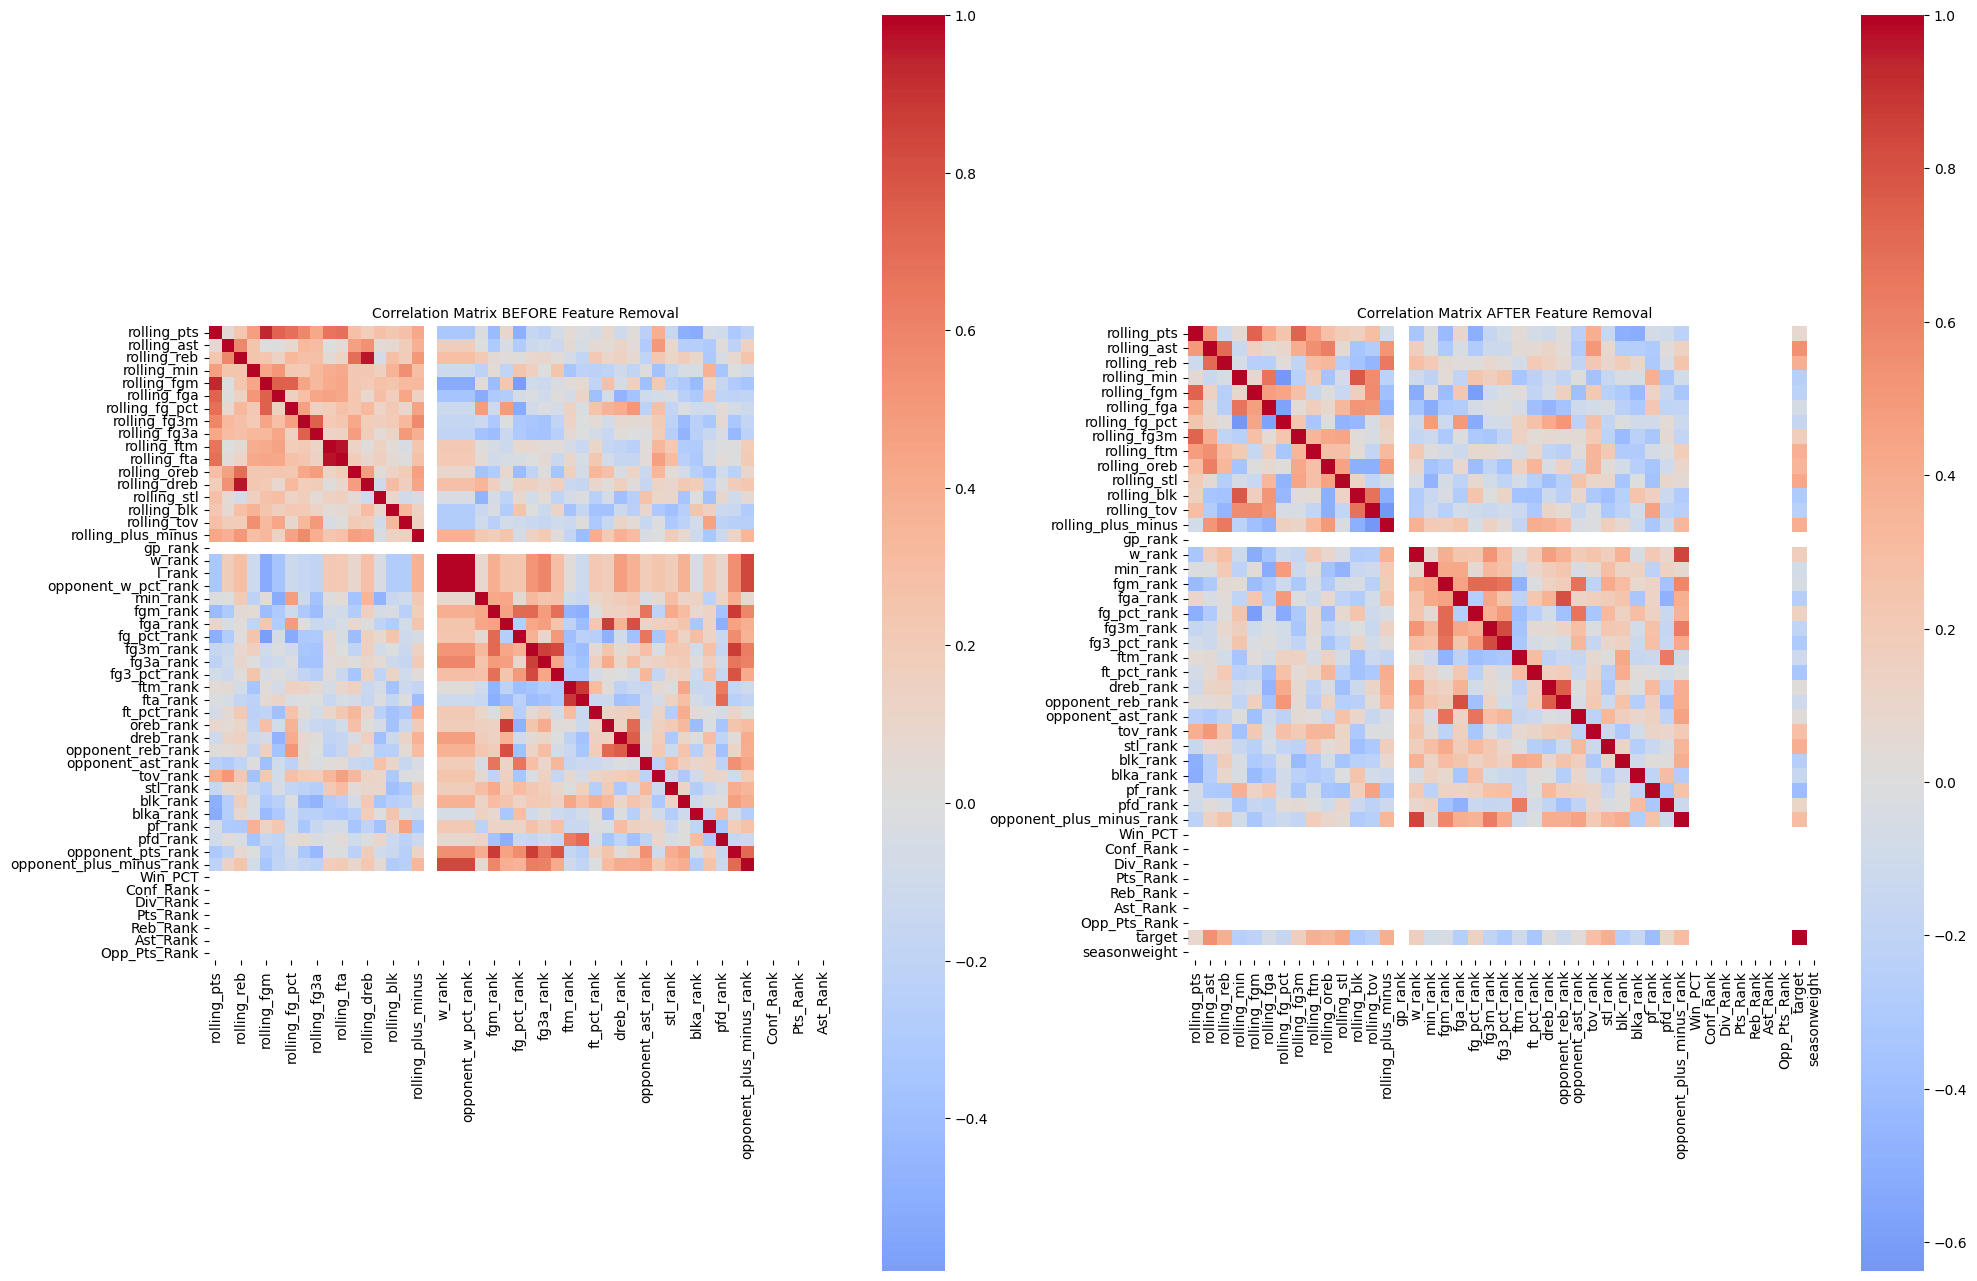


--- Feature Analysis ---
Original Features Count: 28
Features Before Correlation Removal: 50
Features After Correlation Removal: 43

--- Dropped Features ---
['rolling_fg3a', 'rolling_fta', 'rolling_dreb', 'l_rank', 'opponent_w_pct_rank', 'fg3a_rank', 'fta_rank', 'oreb_rank', 'opponent_pts_rank']

--- Remaining Features ---
['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'rolling_fgm', 'rolling_fga', 'rolling_fg_pct', 'rolling_fg3m', 'rolling_ftm', 'rolling_oreb', 'rolling_stl', 'rolling_blk', 'rolling_tov', 'rolling_plus_minus', 'gp_rank', 'w_rank', 'min_rank', 'fgm_rank', 'fga_rank', 'fg_pct_rank', 'fg3m_rank', 'fg3_pct_rank', 'ftm_rank', 'ft_pct_rank', 'dreb_rank', 'opponent_reb_rank', 'opponent_ast_rank', 'tov_rank', 'stl_rank', 'blk_rank', 'blka_rank', 'pf_rank', 'pfd_rank', 'opponent_plus_minus_rank', 'Win_PCT', 'Conf_Rank', 'Div_Rank', 'Pts_Rank', 'Reb_Rank', 'Ast_Rank', 'Opp_Pts_Rank', 'target', 'seasonweight']


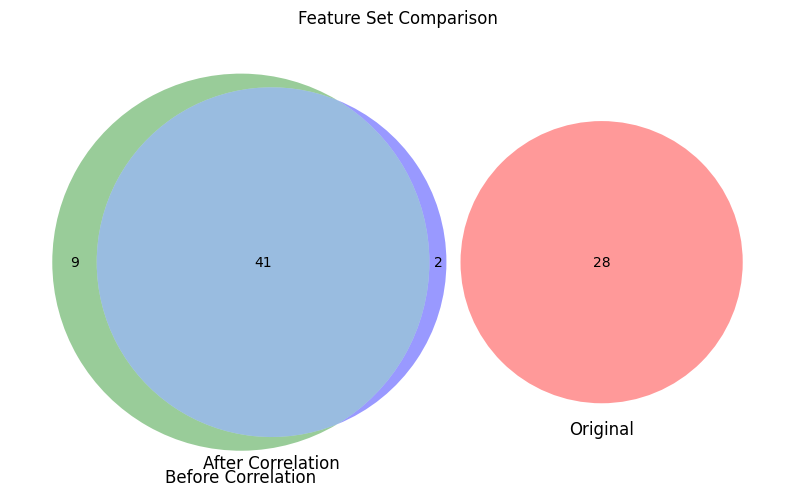

[INFO]: Starting feature scaling and preparation.
[INFO]: Feature scaling completed.


<ipython-input-111-9e74f1c2681d>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=initial_vif_sorted.head(20), palette="coolwarm")


No highly correlated features found to remove.
[INFO]: Dropped highly correlated features: []
Removing tov_rank with VIF: 593260.16
Removing fg3m_rank with VIF: 330910.41
Removing opponent_reb_rank with VIF: 229818.36
Removing dreb_rank with VIF: 217038.00
Removing rolling_fgm with VIF: 272474.28
Removing pf_rank with VIF: 155039.68
Removing fg3_pct_rank with VIF: 315405.79
Removing fg_pct_rank with VIF: 246115.04
Removing ft_pct_rank with VIF: 452349.57
Removing rolling_plus_minus with VIF: inf
Removing rolling_fga with VIF: inf
Removing rolling_fg_pct with VIF: inf
Removing rolling_fg3m with VIF: inf
Removing ftm_rank with VIF: 131.76
Removing fgm_rank with VIF: 50.94
Removing w_rank with VIF: 26.30
Removing rolling_blk with VIF: 16.92
Removing rolling_oreb with VIF: 8.67
Removing blka_rank with VIF: 6.40
[INFO]: Features retained after VIF reduction: ['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'rolling_ftm', 'rolling_stl', 'rolling_tov', 'gp_rank', 'min_rank', 'fga_

<ipython-input-111-9e74f1c2681d>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=final_vif_sorted.head(20), palette="coolwarm")


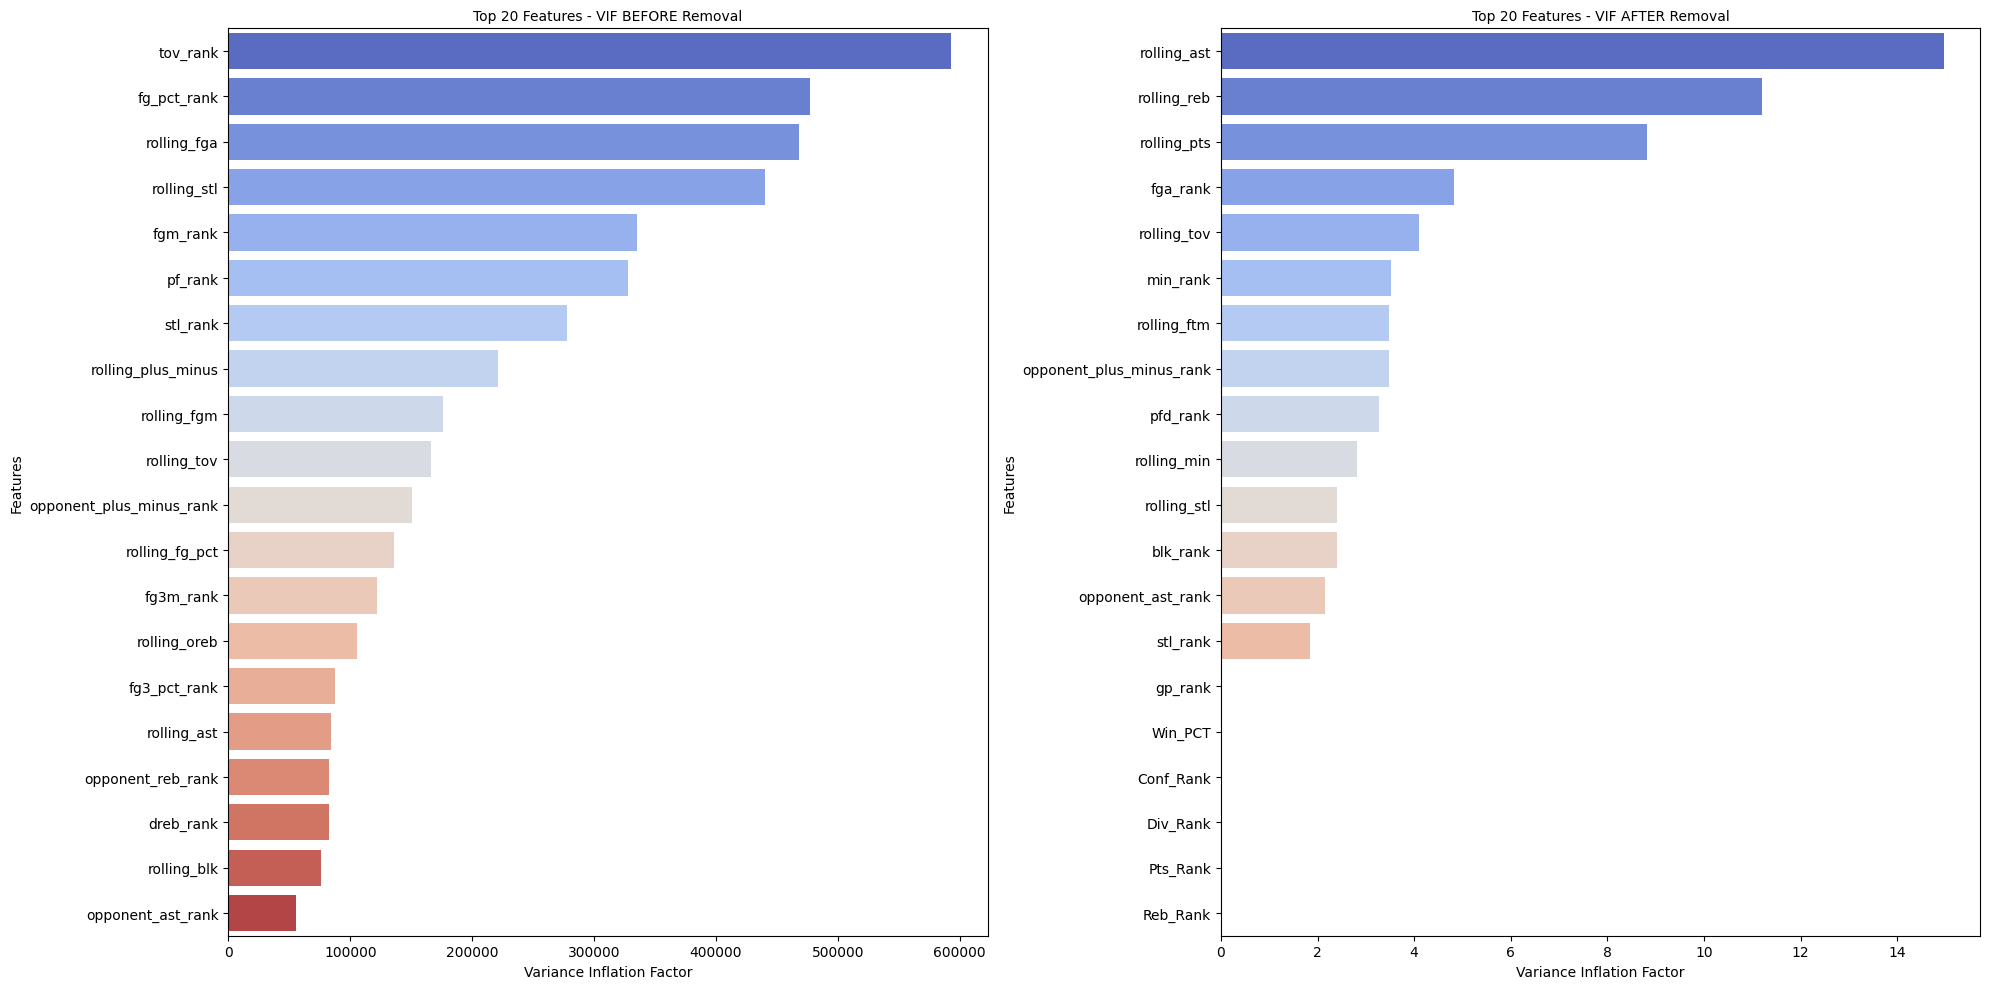


--- Feature Analysis ---
Original Features Count: 42
Features After Correlation Removal: 23

--- Dropped Features ---
Correlation Dropped Features: []

--- Remaining Features ---
['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'rolling_ftm', 'rolling_stl', 'rolling_tov', 'gp_rank', 'min_rank', 'fga_rank', 'opponent_ast_rank', 'stl_rank', 'blk_rank', 'pfd_rank', 'opponent_plus_minus_rank', 'Win_PCT', 'Conf_Rank', 'Div_Rank', 'Pts_Rank', 'Reb_Rank', 'Ast_Rank', 'Opp_Pts_Rank', 'seasonweight']


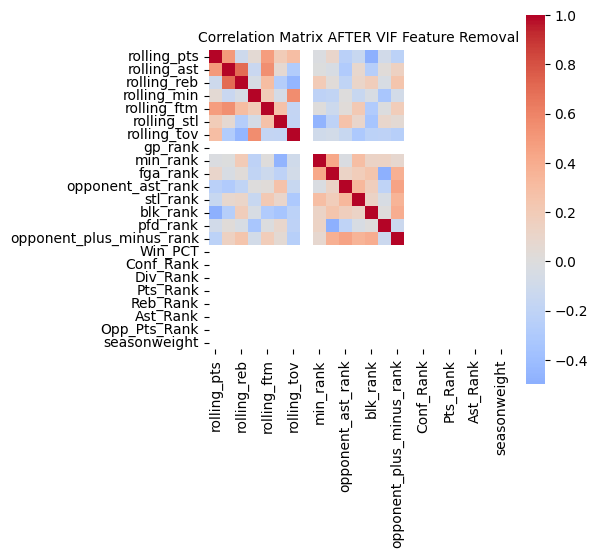

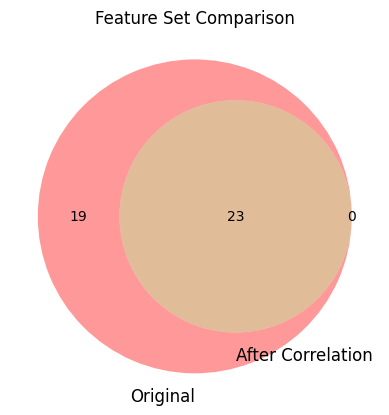

[INFO]: Calculated VIF data.
[INFO]: Initial VIF Data:
[DEBUG]:                      Feature        VIF
1                rolling_ast  14.964269
2                rolling_reb  11.207803
0                rolling_pts   8.810674
9                   fga_rank   4.834826
6                rolling_tov   4.101318
8                   min_rank   3.530729
4                rolling_ftm   3.481217
14  opponent_plus_minus_rank   3.480755
13                  pfd_rank   3.270190
3                rolling_min   2.807516
5                rolling_stl   2.412184
12                  blk_rank   2.406297
10         opponent_ast_rank   2.146462
11                  stl_rank   1.842553
7                    gp_rank        NaN
15                   Win_PCT        NaN
16                 Conf_Rank        NaN
17                  Div_Rank        NaN
18                  Pts_Rank        NaN
19                  Reb_Rank        NaN
20                  Ast_Rank        NaN
21              Opp_Pts_Rank        NaN
22              

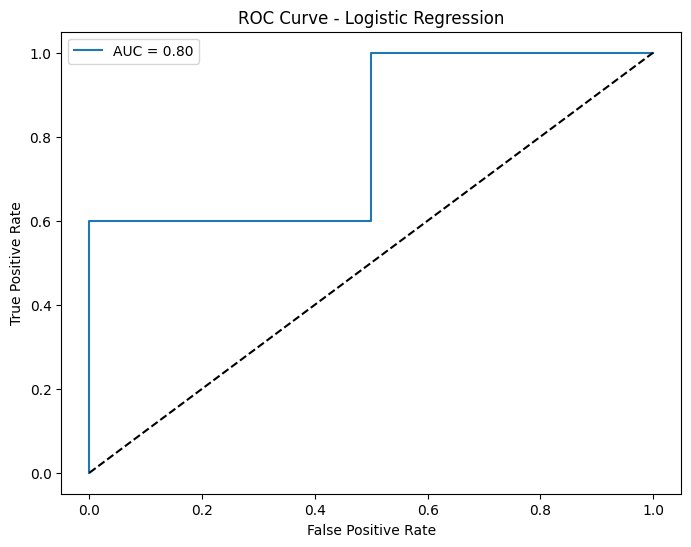

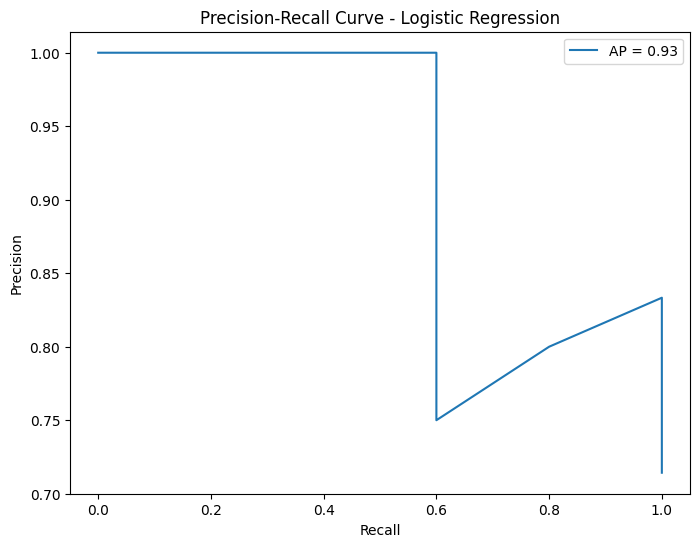

Feature importance not available for Logistic Regression.
Number of Misclassified Samples: 3
[INFO]: Logistic Regression evaluation completed.


Evaluating Random Forest...
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.40      0.57         5

    accuracy                           0.57         7
   macro avg       0.70      0.70      0.57         7
weighted avg       0.83      0.57      0.57         7

Precision: 0.8286, Recall: 0.5714, F1 Score: 0.5714
Confusion Matrix:
[[2 0]
 [3 2]]


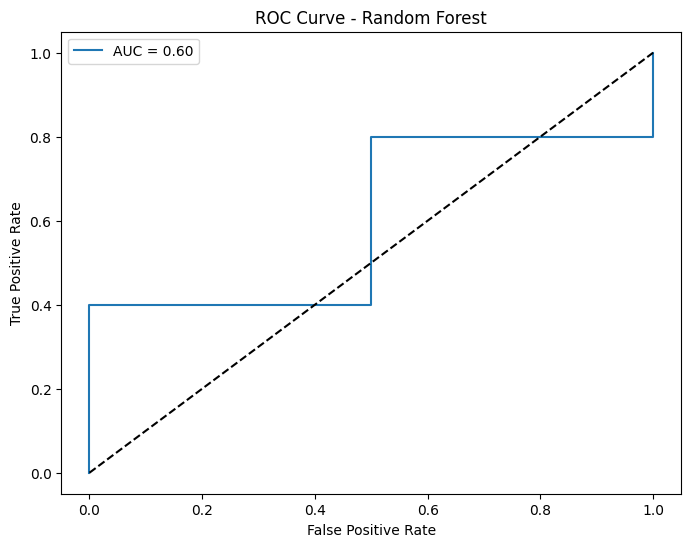

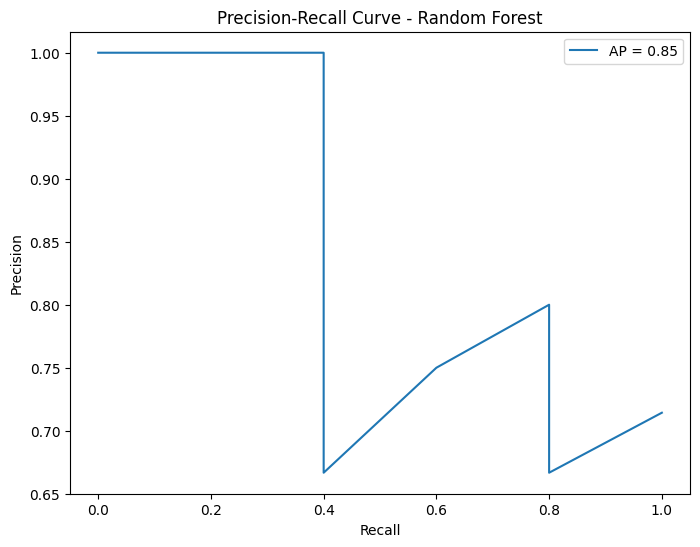

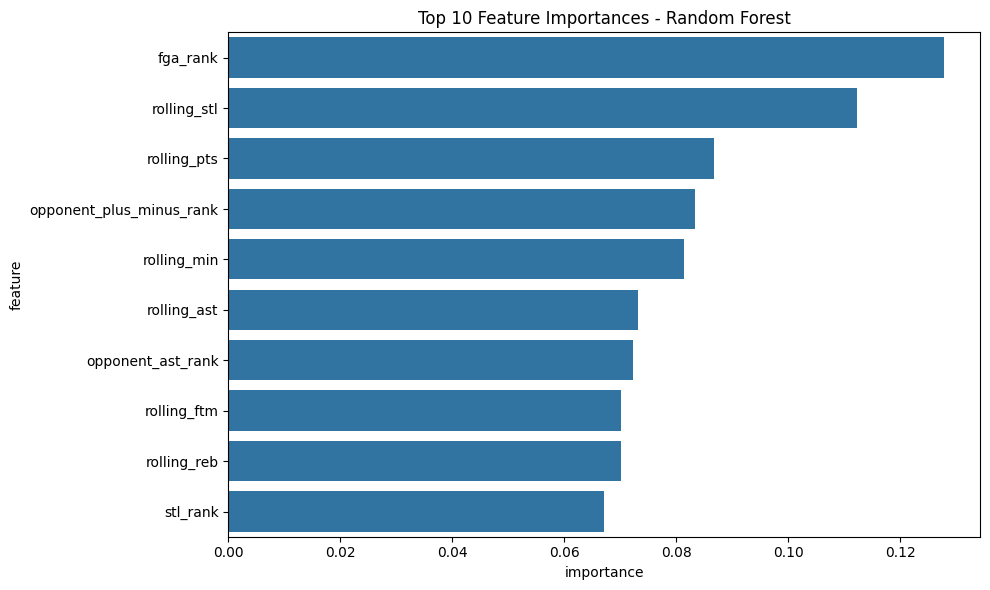

Number of Misclassified Samples: 3
[INFO]: Random Forest evaluation completed.


Evaluating Gradient Boosting...
Classification report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.60      0.60      0.60         5

    accuracy                           0.43         7
   macro avg       0.30      0.30      0.30         7
weighted avg       0.43      0.43      0.43         7

Precision: 0.4286, Recall: 0.4286, F1 Score: 0.4286
Confusion Matrix:
[[0 2]
 [2 3]]


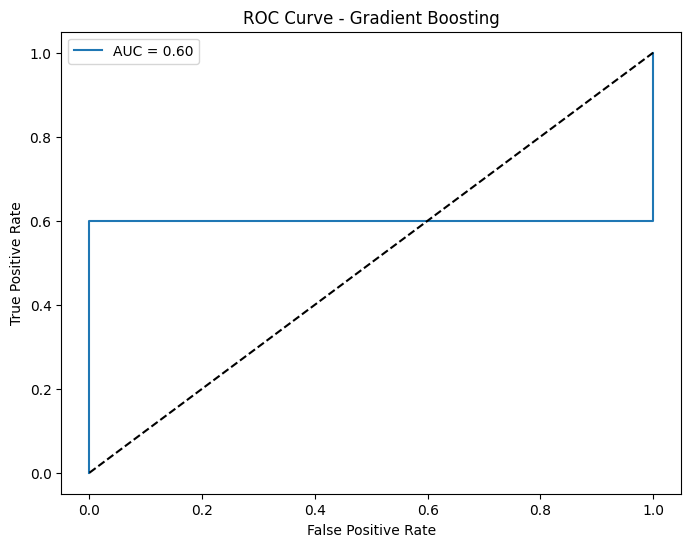

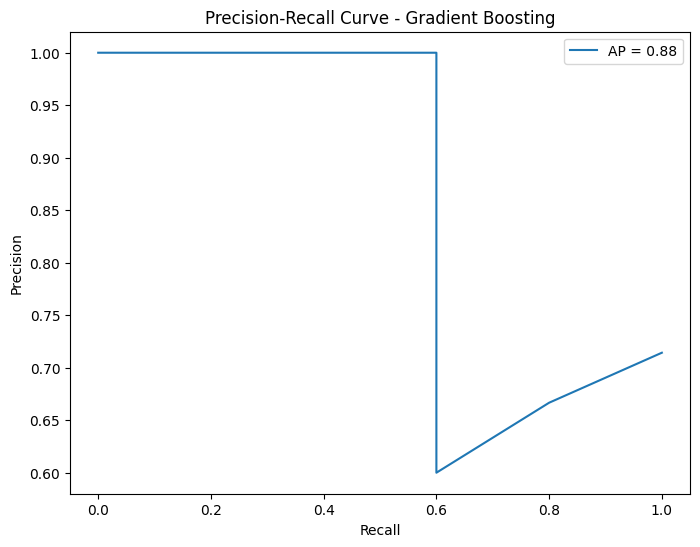

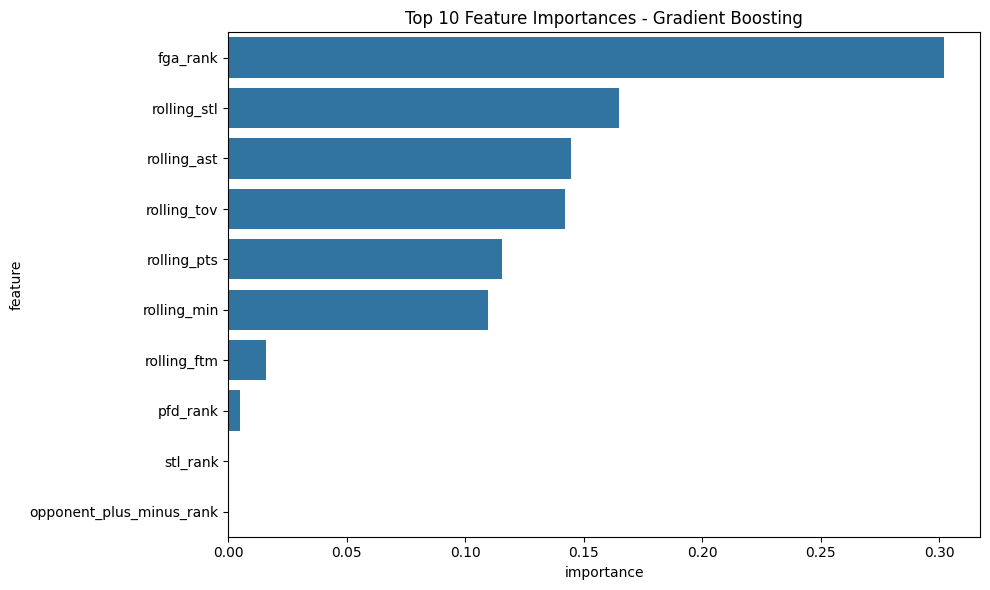

Number of Misclassified Samples: 4
[INFO]: Gradient Boosting evaluation completed.


Evaluating Neural Network...
Classification report for Neural Network:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.75      0.60      0.67         5

    accuracy                           0.57         7
   macro avg       0.54      0.55      0.53         7
weighted avg       0.63      0.57      0.59         7

Precision: 0.6310, Recall: 0.5714, F1 Score: 0.5905
Confusion Matrix:
[[1 1]
 [2 3]]


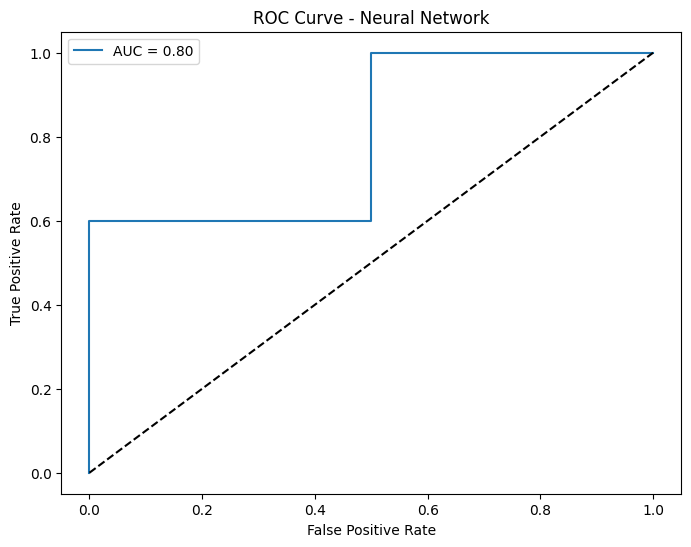

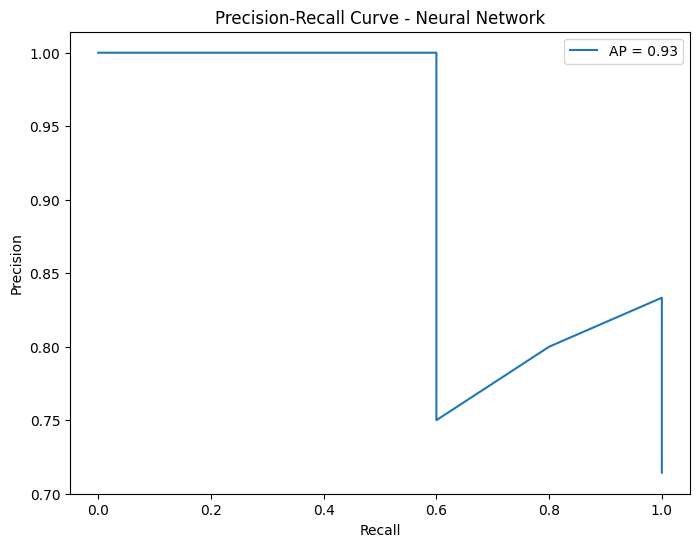

Feature importance not available for Neural Network.
Number of Misclassified Samples: 3
[INFO]: Neural Network evaluation completed.


Evaluating Voting Classifier Ensemble...
Classification report for Voting Classifier Ensemble:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.75      0.60      0.67         5

    accuracy                           0.57         7
   macro avg       0.54      0.55      0.53         7
weighted avg       0.63      0.57      0.59         7

Precision: 0.6310, Recall: 0.5714, F1 Score: 0.5905
Confusion Matrix:
[[1 1]
 [2 3]]


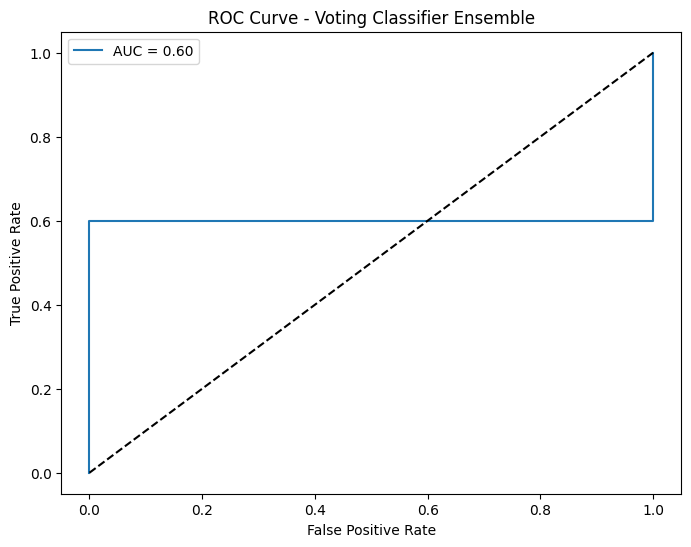

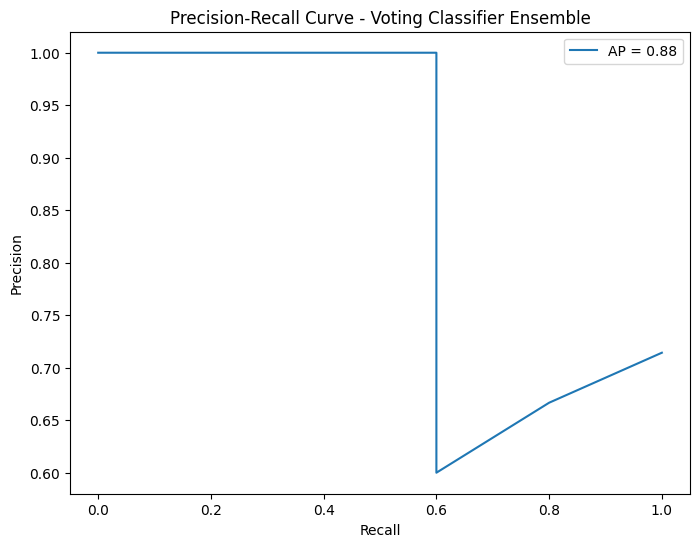

Feature importance not available for Voting Classifier Ensemble.
Number of Misclassified Samples: 3
[INFO]: Voting Classifier Ensemble evaluation completed.


Evaluating Stacking Classifier Ensemble...
Classification report for Stacking Classifier Ensemble:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         2
           1       0.75      0.60      0.67         5

    accuracy                           0.57         7
   macro avg       0.54      0.55      0.53         7
weighted avg       0.63      0.57      0.59         7

Precision: 0.6310, Recall: 0.5714, F1 Score: 0.5905
Confusion Matrix:
[[1 1]
 [2 3]]


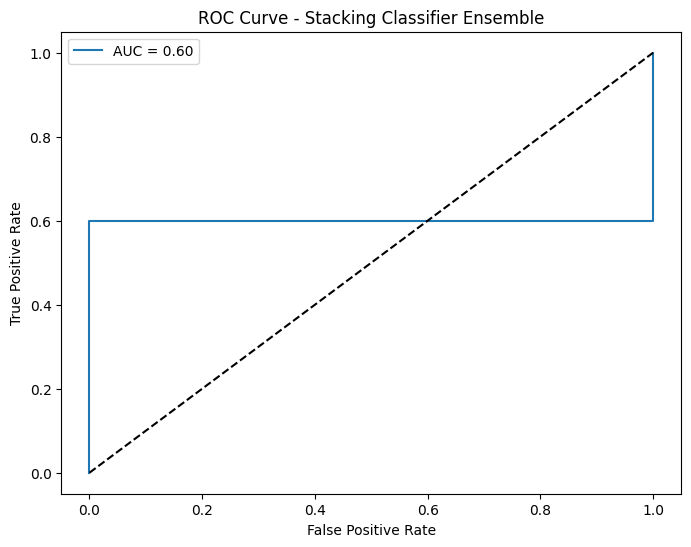

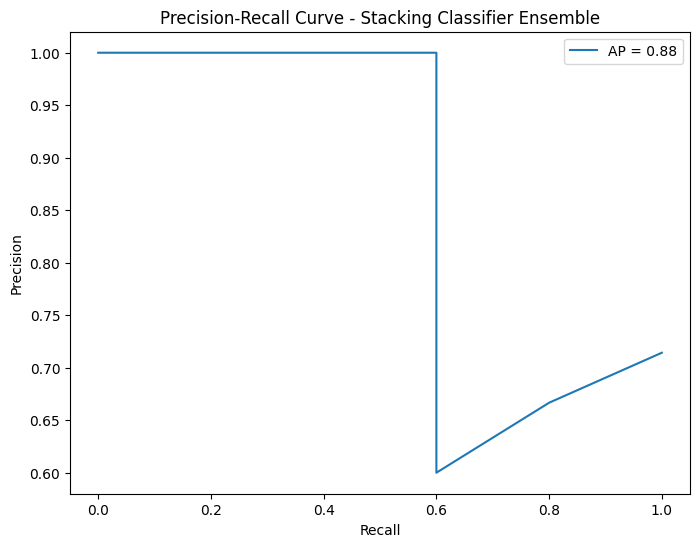

Feature importance not available for Stacking Classifier Ensemble.
Number of Misclassified Samples: 3
[INFO]: Stacking Classifier Ensemble evaluation completed.



Blended Prediction for Next Game:
Prediction: Under
Probability of Under: 0.80
Probability of Over: 0.20
Prediction for ast (stat line 9.5): Under
Probability of Under: 0.80
Probability of Over: 0.20

--- Processing Tyler Herro ---
1629639

Next Game Details:
GAME_DATE            DEC 12, 2024
HOME_TEAM_NAME              Miami
VISITOR_TEAM_NAME         Toronto
GAME_TIME                07:30 PM
Name: 0, dtype: object

[Debug] Starting dataset preparation...
Columns in fetched player game log for season 2024-25: Index(['season_id', 'player_id', 'game_id', 'game_date', 'matchup', 'wl',
       'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf',
       'pts', 'plus_minus', 'video_available'],
      dtype='object')
Columns in fetched playe

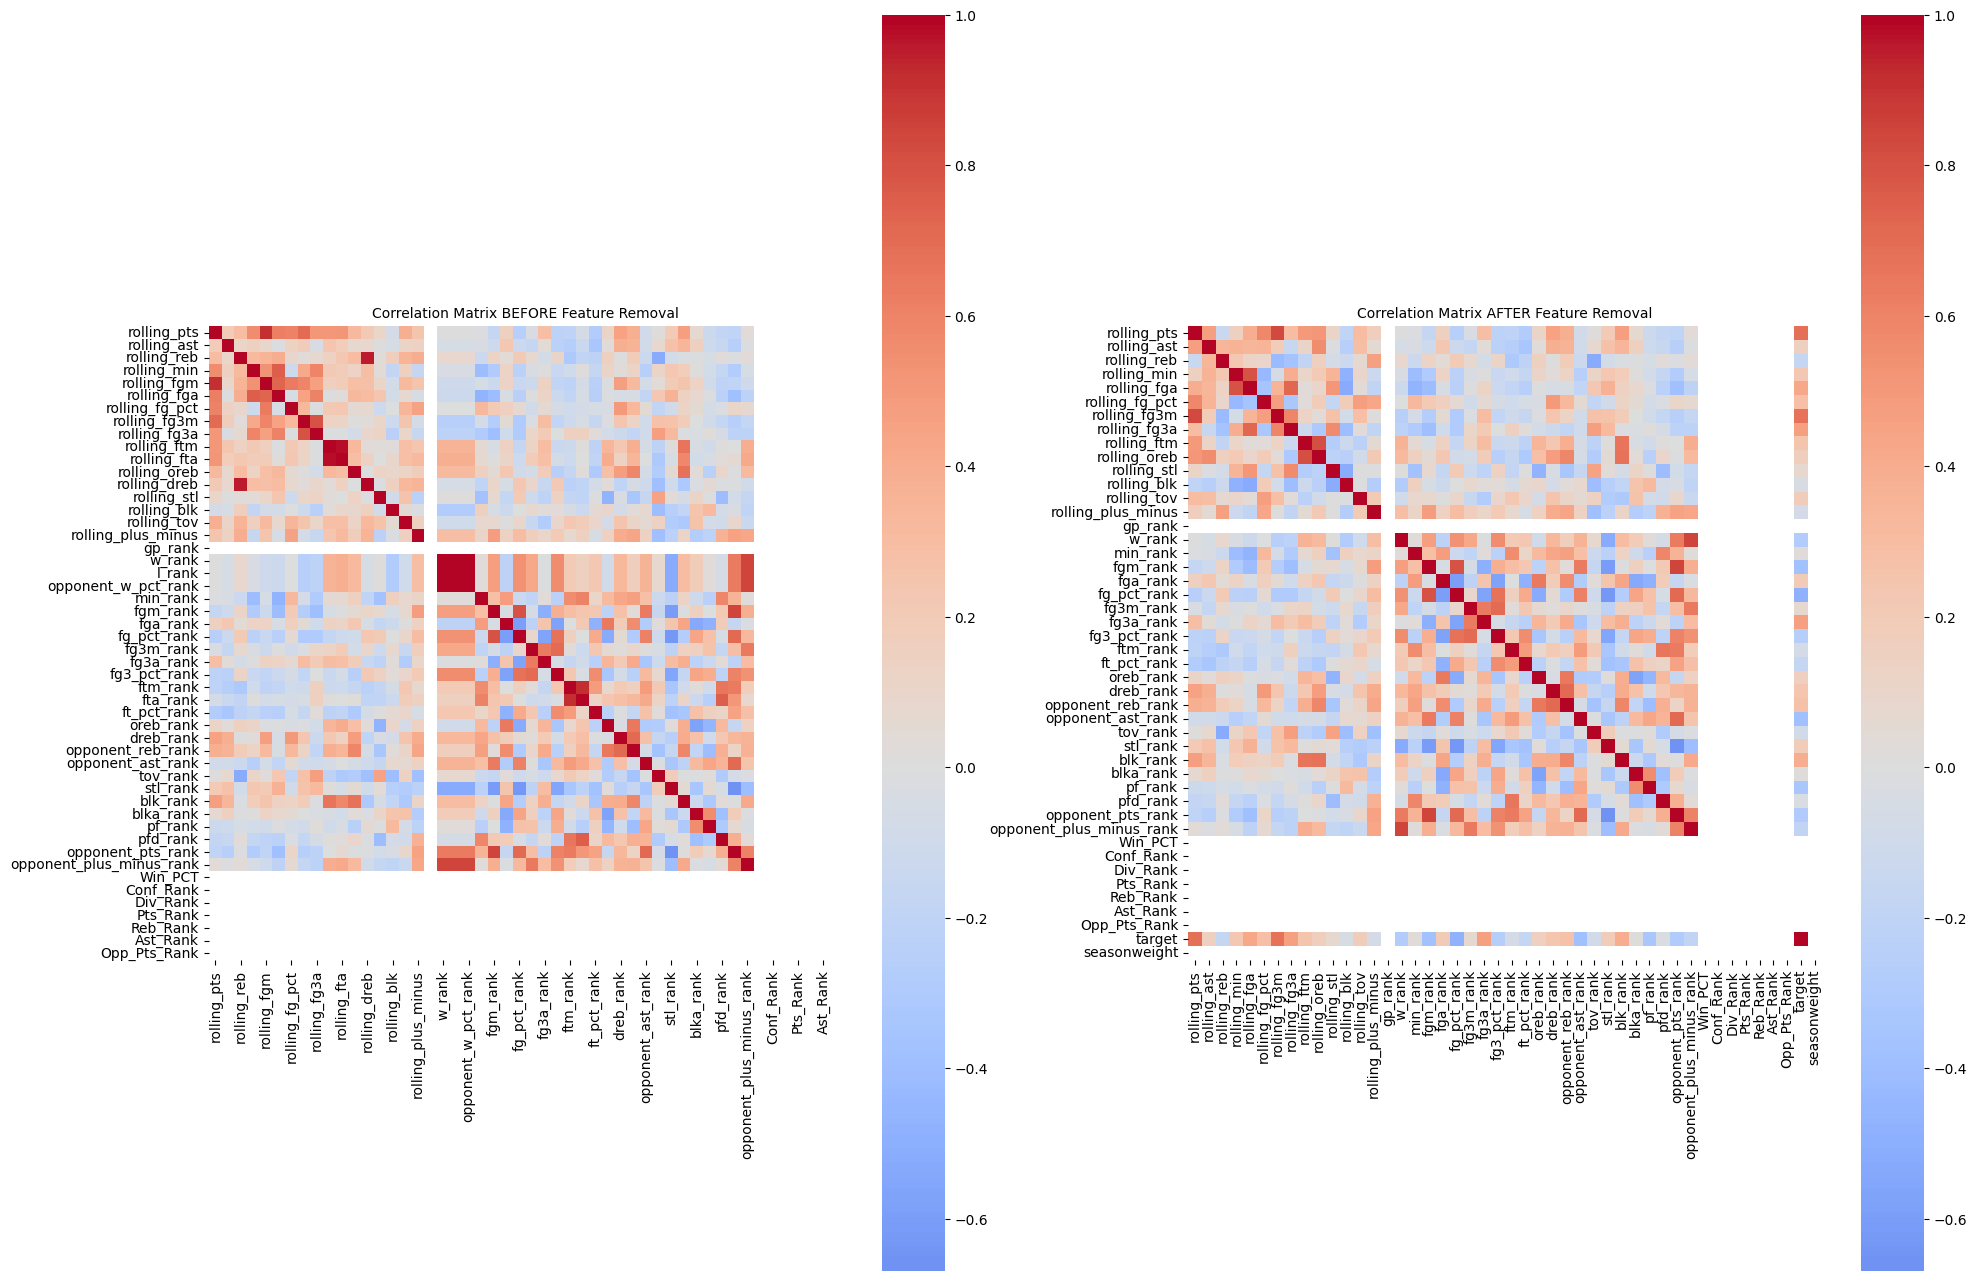


--- Feature Analysis ---
Original Features Count: 28
Features Before Correlation Removal: 50
Features After Correlation Removal: 46

--- Dropped Features ---
['rolling_fgm', 'rolling_fta', 'rolling_dreb', 'l_rank', 'opponent_w_pct_rank', 'fta_rank']

--- Remaining Features ---
['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'rolling_fga', 'rolling_fg_pct', 'rolling_fg3m', 'rolling_fg3a', 'rolling_ftm', 'rolling_oreb', 'rolling_stl', 'rolling_blk', 'rolling_tov', 'rolling_plus_minus', 'gp_rank', 'w_rank', 'min_rank', 'fgm_rank', 'fga_rank', 'fg_pct_rank', 'fg3m_rank', 'fg3a_rank', 'fg3_pct_rank', 'ftm_rank', 'ft_pct_rank', 'oreb_rank', 'dreb_rank', 'opponent_reb_rank', 'opponent_ast_rank', 'tov_rank', 'stl_rank', 'blk_rank', 'blka_rank', 'pf_rank', 'pfd_rank', 'opponent_pts_rank', 'opponent_plus_minus_rank', 'Win_PCT', 'Conf_Rank', 'Div_Rank', 'Pts_Rank', 'Reb_Rank', 'Ast_Rank', 'Opp_Pts_Rank', 'target', 'seasonweight']


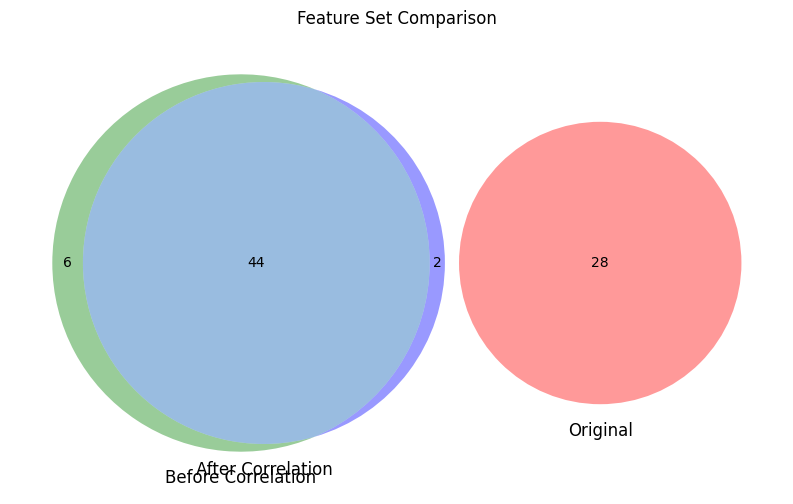

[INFO]: Starting feature scaling and preparation.
[INFO]: Feature scaling completed.


<ipython-input-111-9e74f1c2681d>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=initial_vif_sorted.head(20), palette="coolwarm")


No highly correlated features found to remove.
[INFO]: Dropped highly correlated features: []
Removing rolling_fga with VIF: inf
Removing rolling_fg_pct with VIF: inf
Removing rolling_fg3m with VIF: inf
Removing rolling_fg3a with VIF: inf
Removing rolling_ftm with VIF: inf
Removing rolling_oreb with VIF: inf
Removing rolling_stl with VIF: inf
Removing rolling_blk with VIF: inf
Removing rolling_tov with VIF: inf
Removing rolling_plus_minus with VIF: inf
Removing w_rank with VIF: inf
Removing min_rank with VIF: inf
Removing fgm_rank with VIF: inf
Removing fga_rank with VIF: inf
Removing fg_pct_rank with VIF: inf
Removing opponent_reb_rank with VIF: 247.43
Removing fg3m_rank with VIF: 132.31
Removing opponent_pts_rank with VIF: 40.42
Removing pfd_rank with VIF: 16.04
Removing fg3_pct_rank with VIF: 15.18
[INFO]: Features retained after VIF reduction: ['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'gp_rank', 'fg3a_rank', 'ftm_rank', 'ft_pct_rank', 'oreb_rank', 'dreb_rank', 'o

<ipython-input-111-9e74f1c2681d>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=final_vif_sorted.head(20), palette="coolwarm")


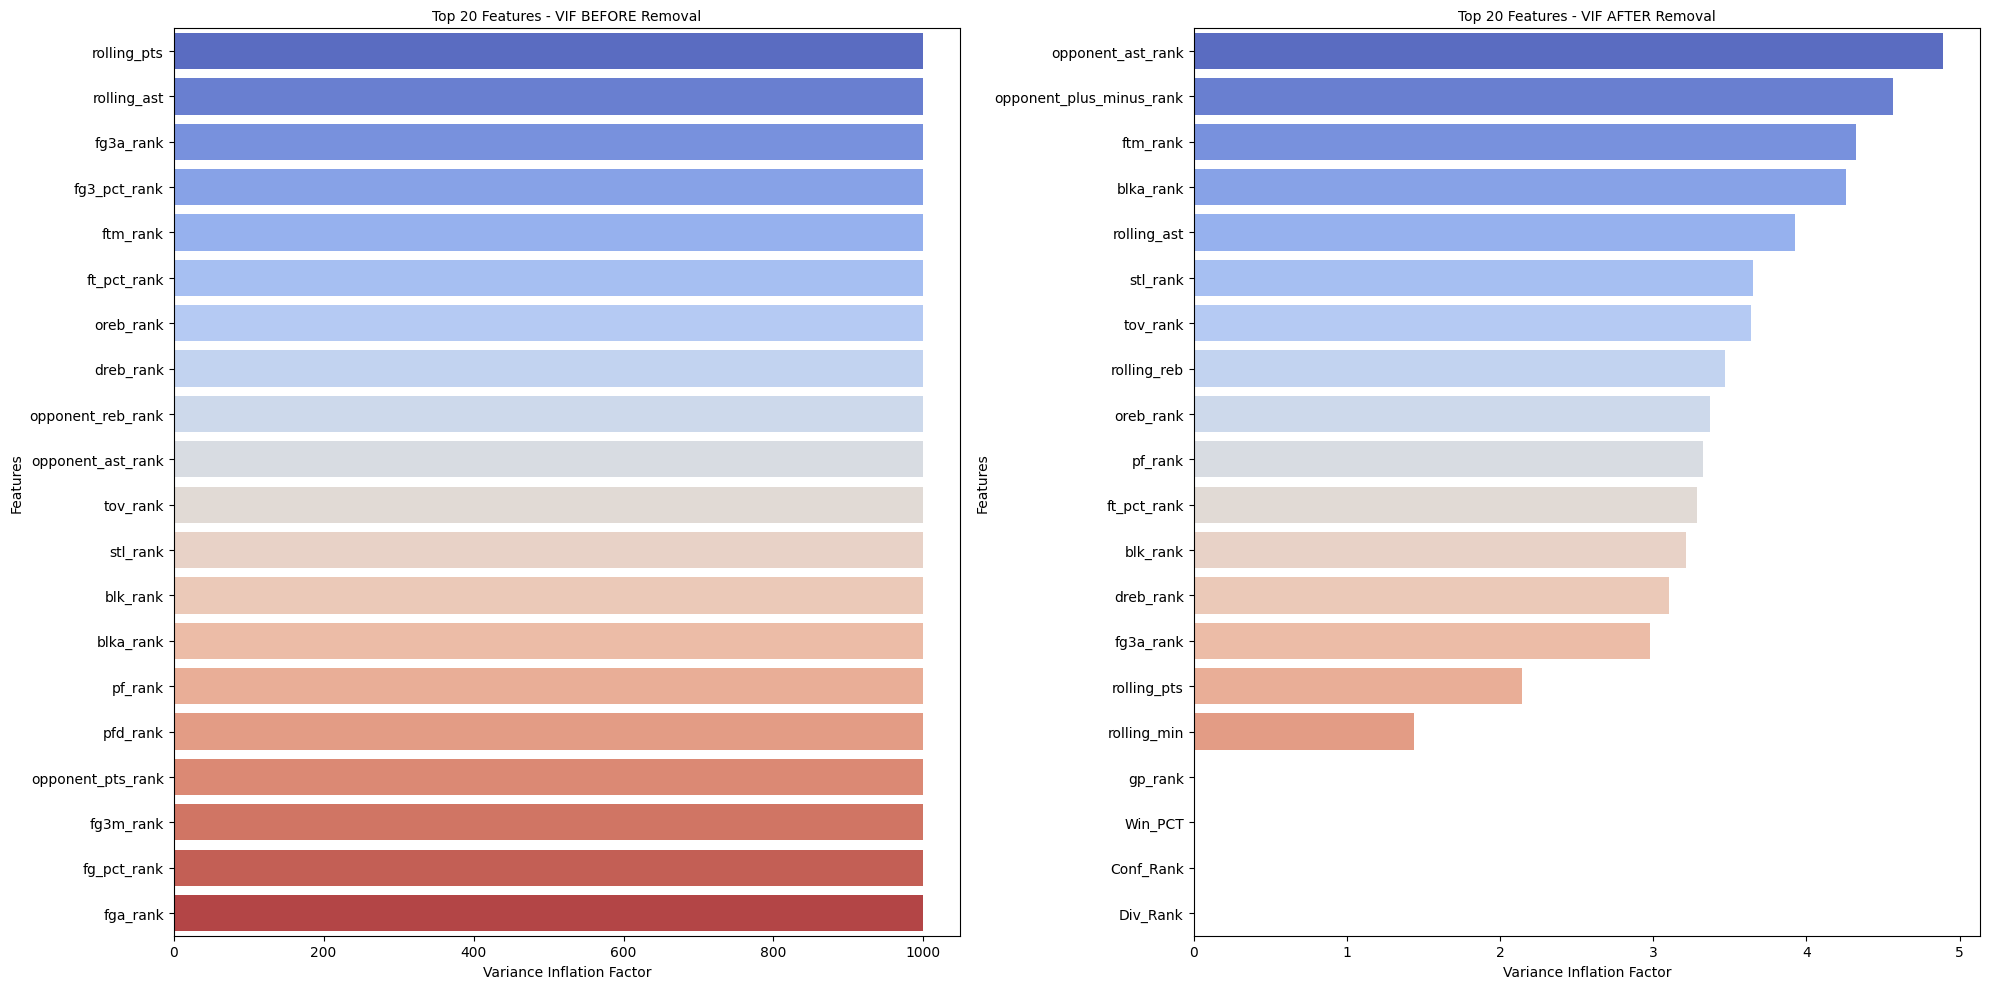


--- Feature Analysis ---
Original Features Count: 45
Features After Correlation Removal: 25

--- Dropped Features ---
Correlation Dropped Features: []

--- Remaining Features ---
['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'gp_rank', 'fg3a_rank', 'ftm_rank', 'ft_pct_rank', 'oreb_rank', 'dreb_rank', 'opponent_ast_rank', 'tov_rank', 'stl_rank', 'blk_rank', 'blka_rank', 'pf_rank', 'opponent_plus_minus_rank', 'Win_PCT', 'Conf_Rank', 'Div_Rank', 'Pts_Rank', 'Reb_Rank', 'Ast_Rank', 'Opp_Pts_Rank', 'seasonweight']


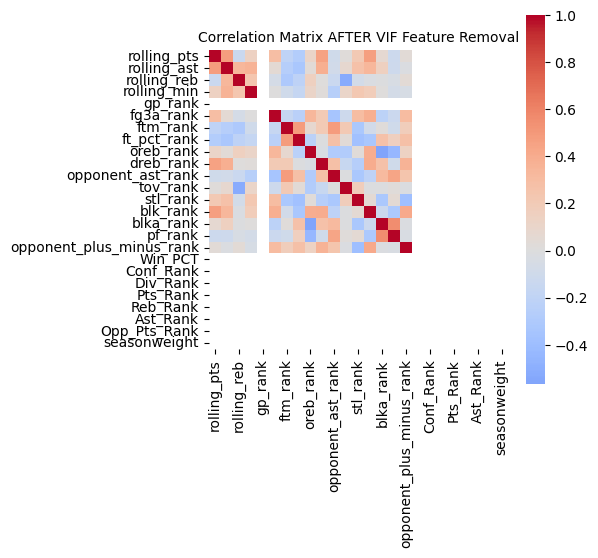

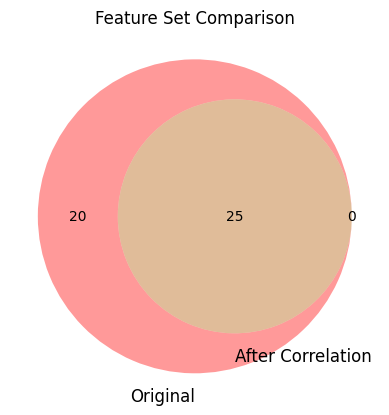

[INFO]: Calculated VIF data.
[INFO]: Initial VIF Data:
[DEBUG]:                      Feature       VIF
10         opponent_ast_rank  4.888624
16  opponent_plus_minus_rank  4.567950
6                   ftm_rank  4.321839
14                 blka_rank  4.260011
1                rolling_ast  3.926980
12                  stl_rank  3.654587
11                  tov_rank  3.639378
2                rolling_reb  3.471436
8                  oreb_rank  3.370303
15                   pf_rank  3.327771
7                ft_pct_rank  3.284585
13                  blk_rank  3.213146
9                  dreb_rank  3.103735
5                  fg3a_rank  2.977809
0                rolling_pts  2.144182
3                rolling_min  1.438733
4                    gp_rank       NaN
17                   Win_PCT       NaN
18                 Conf_Rank       NaN
19                  Div_Rank       NaN
20                  Pts_Rank       NaN
21                  Reb_Rank       NaN
22                  Ast_Rank       NaN


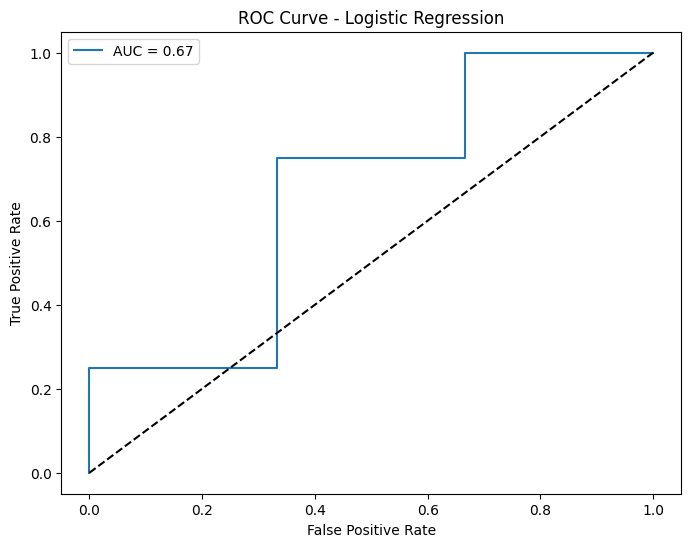

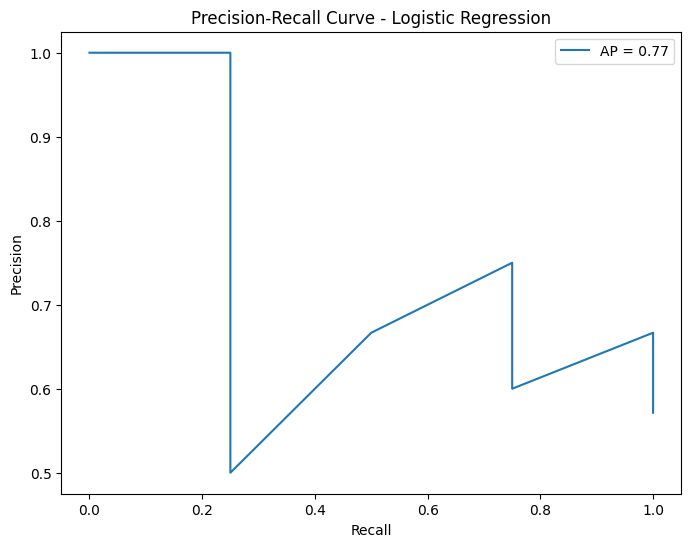

Feature importance not available for Logistic Regression.
Number of Misclassified Samples: 3
[INFO]: Logistic Regression evaluation completed.


Evaluating Random Forest...
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.57      1.00      0.73         4

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7

Precision: 0.3265, Recall: 0.5714, F1 Score: 0.4156
Confusion Matrix:
[[0 3]
 [0 4]]


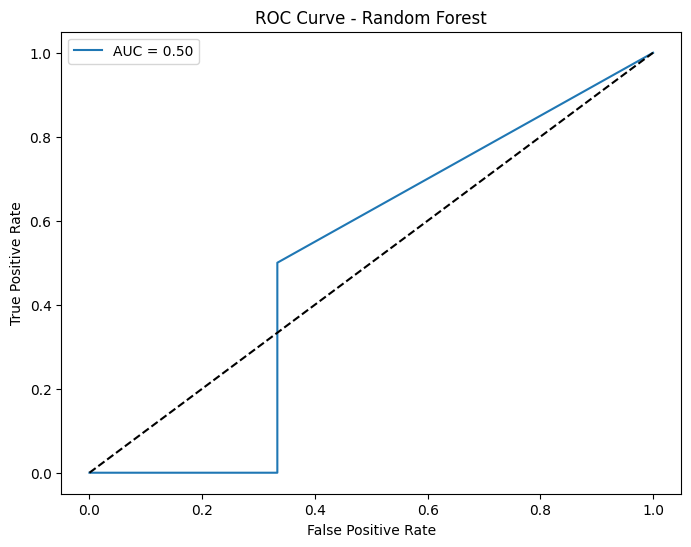

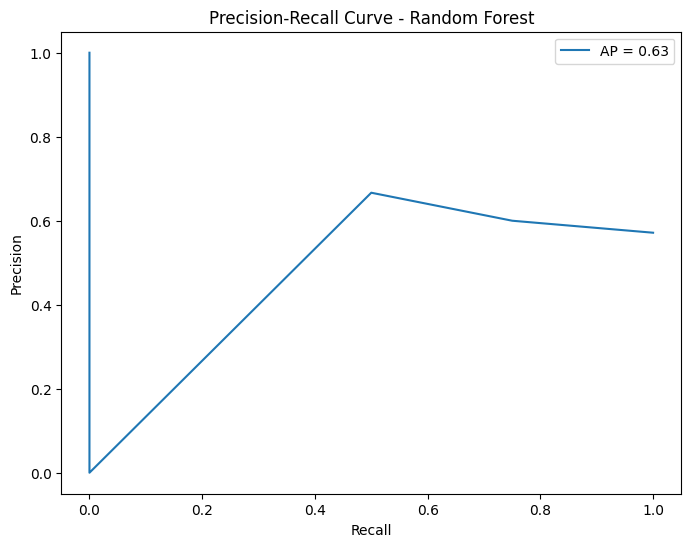

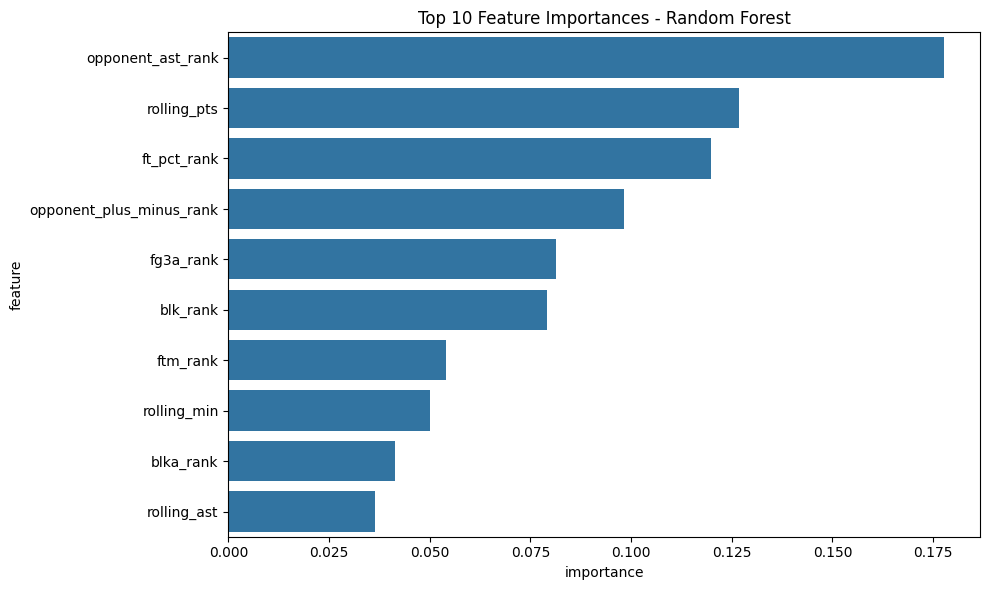

Number of Misclassified Samples: 3
[INFO]: Random Forest evaluation completed.


Evaluating Gradient Boosting...
Classification report for Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.67      1.00      0.80         4

    accuracy                           0.71         7
   macro avg       0.83      0.67      0.65         7
weighted avg       0.81      0.71      0.67         7

Precision: 0.8095, Recall: 0.7143, F1 Score: 0.6714
Confusion Matrix:
[[1 2]
 [0 4]]


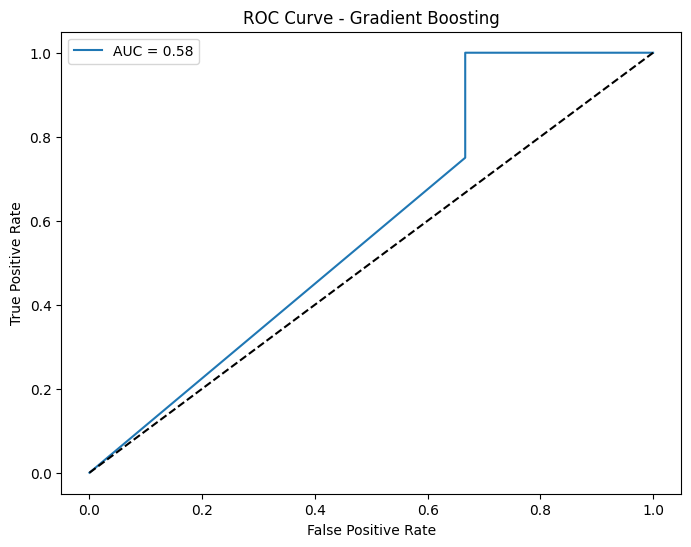

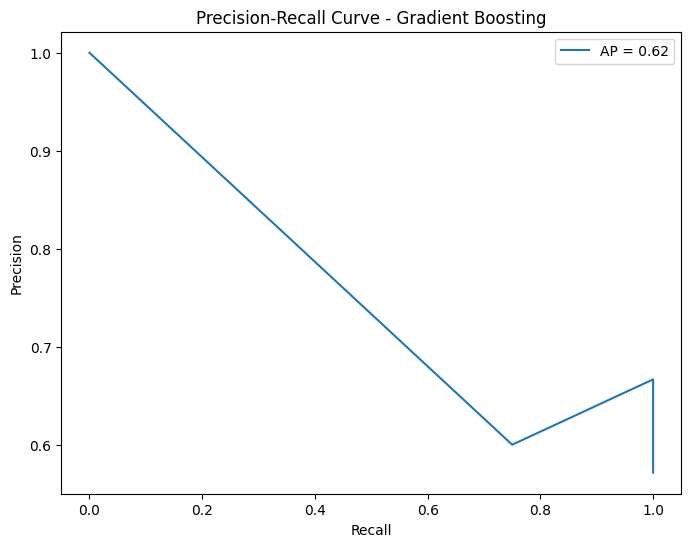

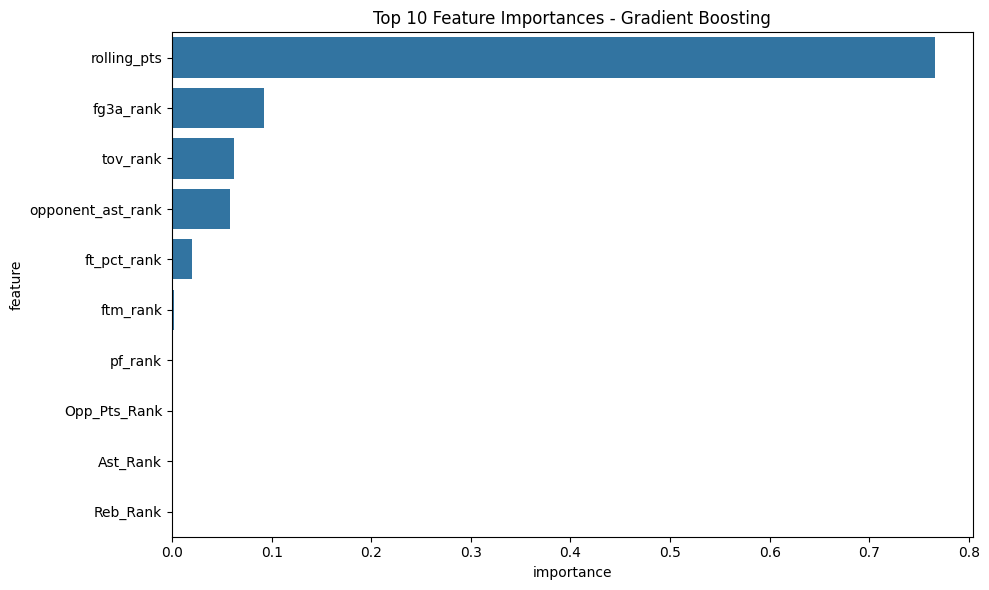

Number of Misclassified Samples: 2
[INFO]: Gradient Boosting evaluation completed.


Evaluating Neural Network...
Classification report for Neural Network:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       0.60      0.75      0.67         4

    accuracy                           0.57         7
   macro avg       0.55      0.54      0.53         7
weighted avg       0.56      0.57      0.55         7

Precision: 0.5571, Recall: 0.5714, F1 Score: 0.5524
Confusion Matrix:
[[1 2]
 [1 3]]


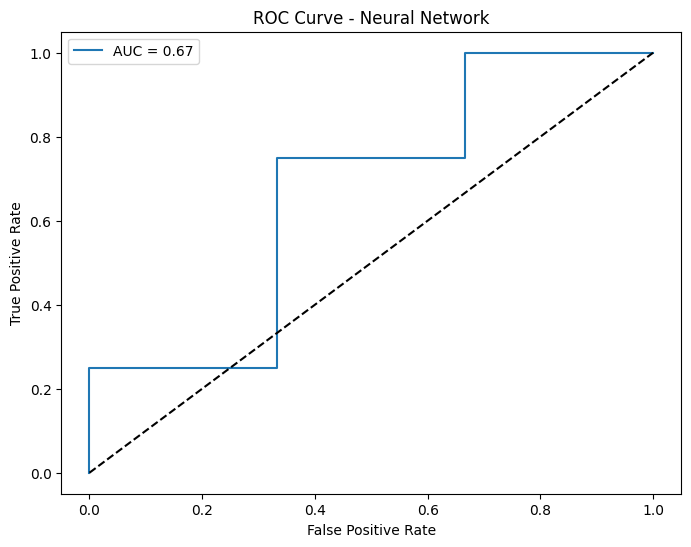

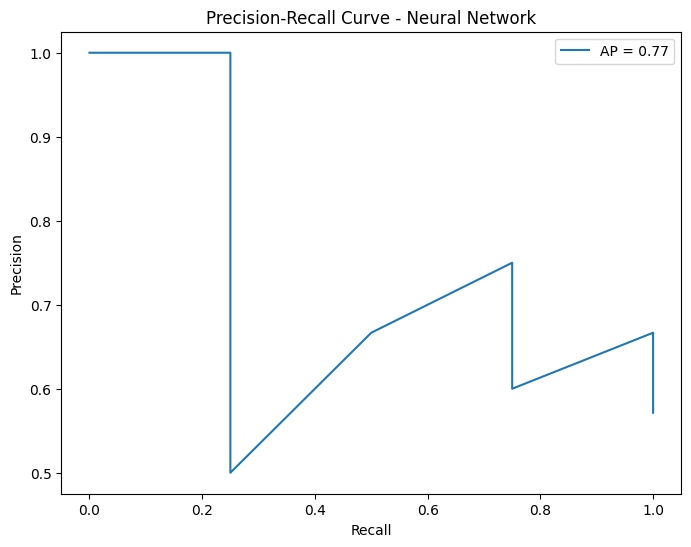

Feature importance not available for Neural Network.
Number of Misclassified Samples: 3
[INFO]: Neural Network evaluation completed.


Evaluating Voting Classifier Ensemble...
Classification report for Voting Classifier Ensemble:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.67      1.00      0.80         4

    accuracy                           0.71         7
   macro avg       0.83      0.67      0.65         7
weighted avg       0.81      0.71      0.67         7

Precision: 0.8095, Recall: 0.7143, F1 Score: 0.6714
Confusion Matrix:
[[1 2]
 [0 4]]


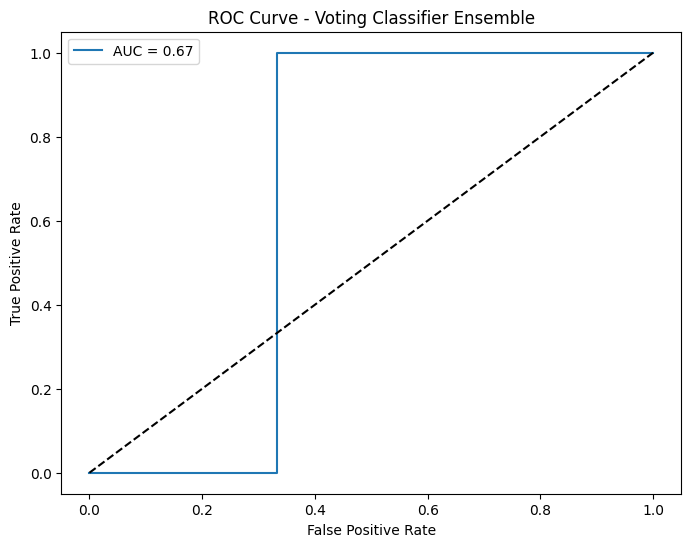

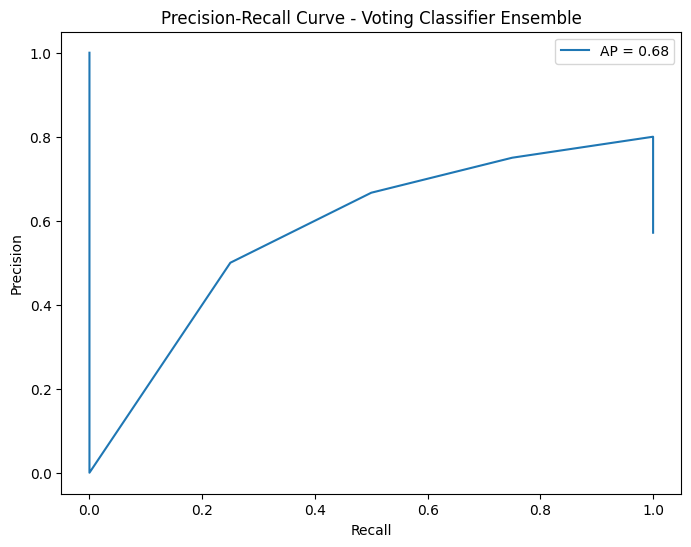

Feature importance not available for Voting Classifier Ensemble.
Number of Misclassified Samples: 2
[INFO]: Voting Classifier Ensemble evaluation completed.


Evaluating Stacking Classifier Ensemble...
Classification report for Stacking Classifier Ensemble:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.67      1.00      0.80         4

    accuracy                           0.71         7
   macro avg       0.83      0.67      0.65         7
weighted avg       0.81      0.71      0.67         7

Precision: 0.8095, Recall: 0.7143, F1 Score: 0.6714
Confusion Matrix:
[[1 2]
 [0 4]]


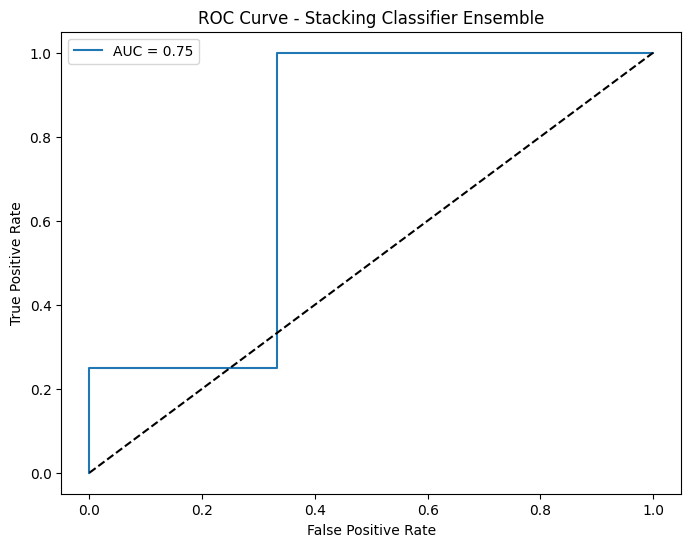

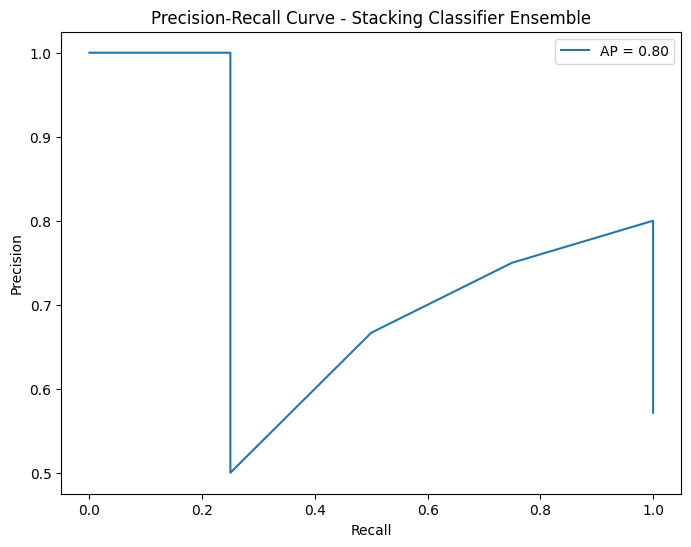

Feature importance not available for Stacking Classifier Ensemble.
Number of Misclassified Samples: 2
[INFO]: Stacking Classifier Ensemble evaluation completed.



Blended Prediction for Next Game:
Prediction: Over
Probability of Under: 0.47
Probability of Over: 0.53
Prediction for fg3m (stat line 3.5): Over
Probability of Under: 0.47
Probability of Over: 0.53

--- Processing Giannis Antetokounmpo ---
203507

Next Game Details:
GAME_DATE            DEC 14, 2024
HOME_TEAM_NAME          Milwaukee
VISITOR_TEAM_NAME         Atlanta
GAME_TIME                04:30 PM
Name: 0, dtype: object

[Debug] Starting dataset preparation...
Columns in fetched player game log for season 2024-25: Index(['season_id', 'player_id', 'game_id', 'game_date', 'matchup', 'wl',
       'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf',
       'pts', 'plus_minus', 'video_available'],
      dtype='object')
Columns in fetch

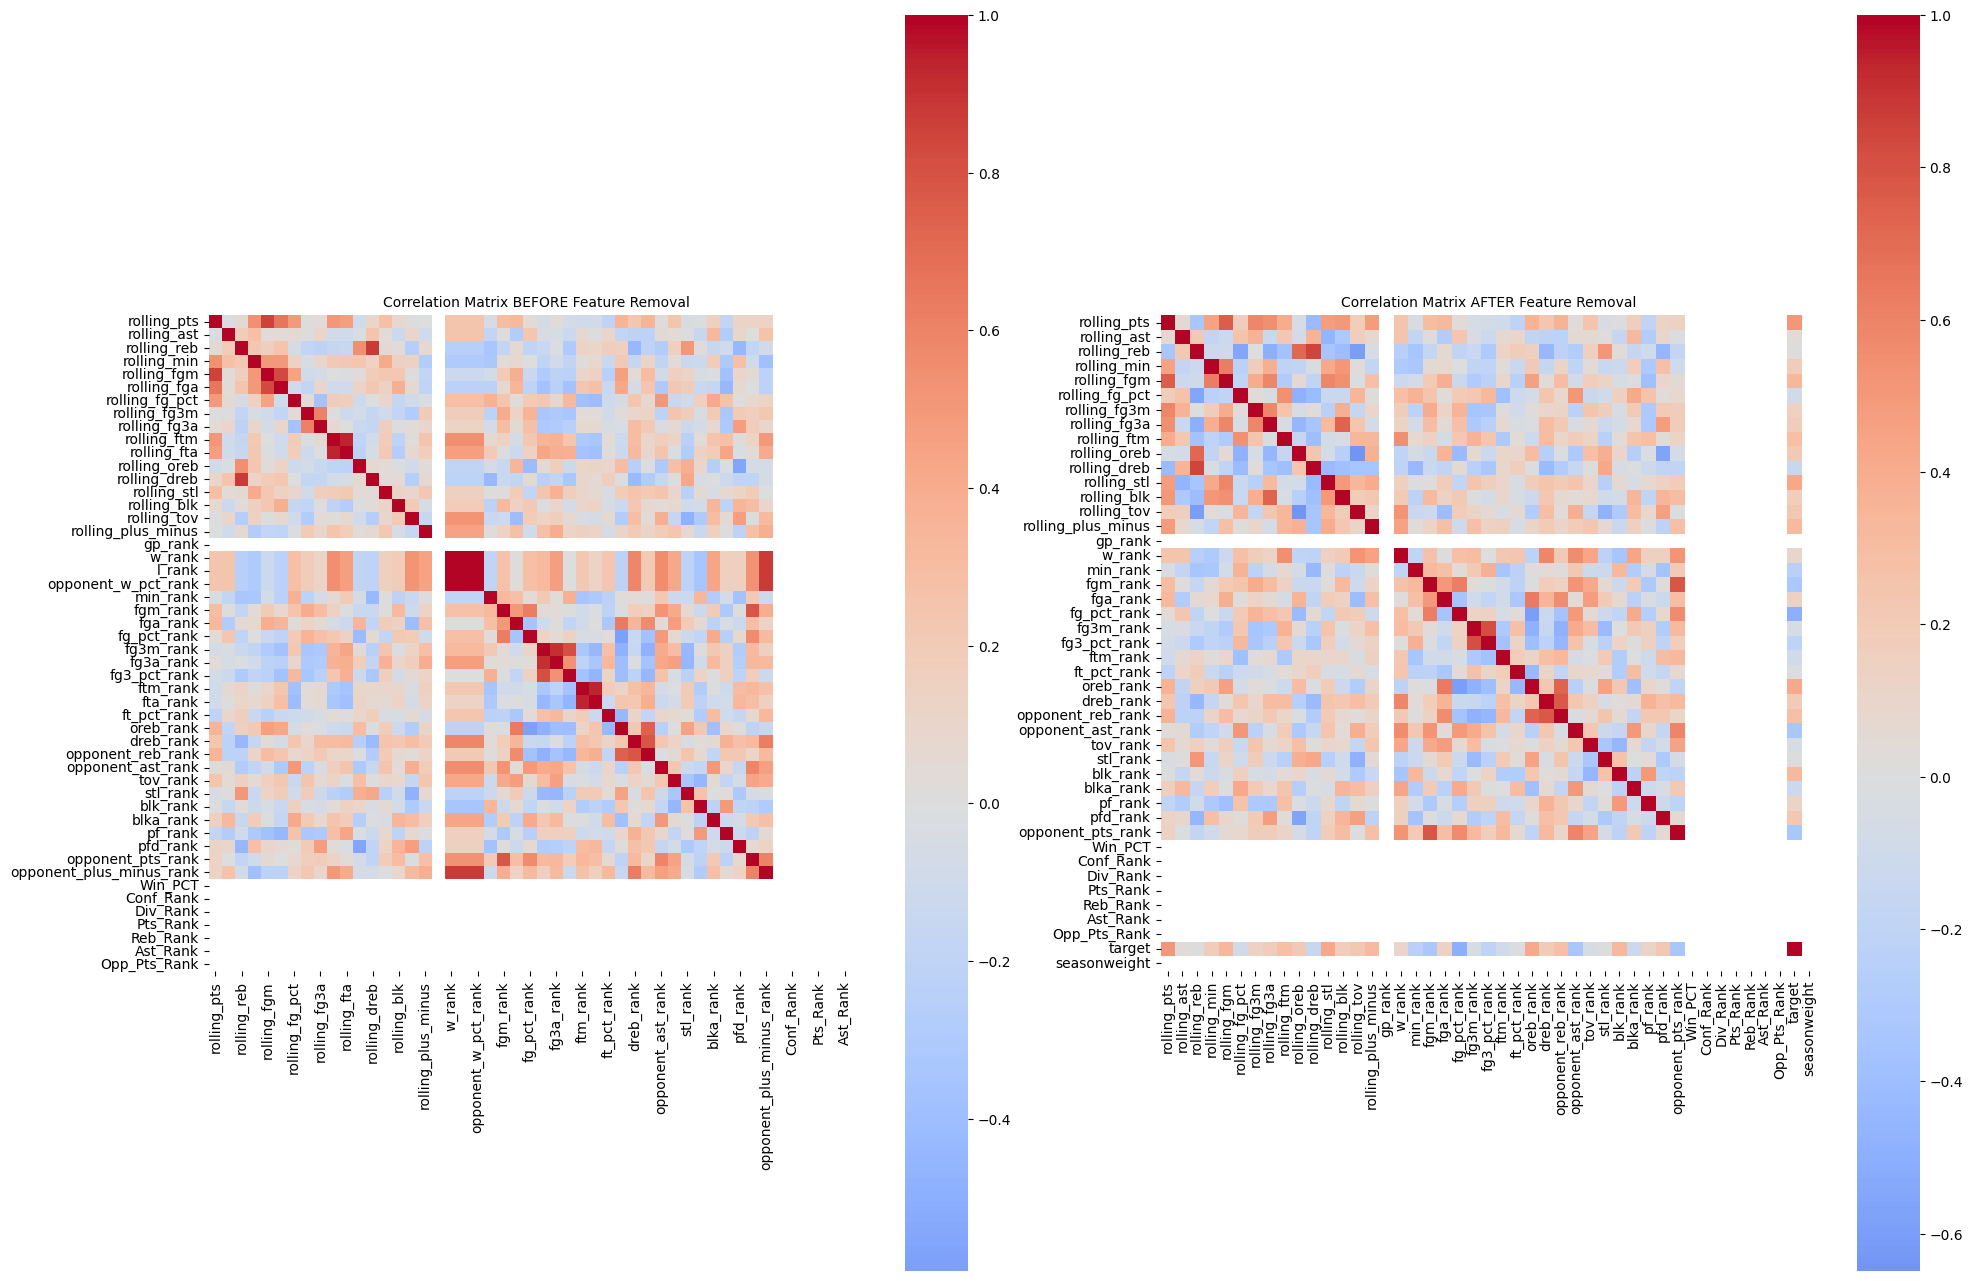


--- Feature Analysis ---
Original Features Count: 28
Features Before Correlation Removal: 50
Features After Correlation Removal: 45

--- Dropped Features ---
['rolling_fga', 'rolling_fta', 'l_rank', 'opponent_w_pct_rank', 'fg3a_rank', 'fta_rank', 'opponent_plus_minus_rank']

--- Remaining Features ---
['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'rolling_fgm', 'rolling_fg_pct', 'rolling_fg3m', 'rolling_fg3a', 'rolling_ftm', 'rolling_oreb', 'rolling_dreb', 'rolling_stl', 'rolling_blk', 'rolling_tov', 'rolling_plus_minus', 'gp_rank', 'w_rank', 'min_rank', 'fgm_rank', 'fga_rank', 'fg_pct_rank', 'fg3m_rank', 'fg3_pct_rank', 'ftm_rank', 'ft_pct_rank', 'oreb_rank', 'dreb_rank', 'opponent_reb_rank', 'opponent_ast_rank', 'tov_rank', 'stl_rank', 'blk_rank', 'blka_rank', 'pf_rank', 'pfd_rank', 'opponent_pts_rank', 'Win_PCT', 'Conf_Rank', 'Div_Rank', 'Pts_Rank', 'Reb_Rank', 'Ast_Rank', 'Opp_Pts_Rank', 'target', 'seasonweight']


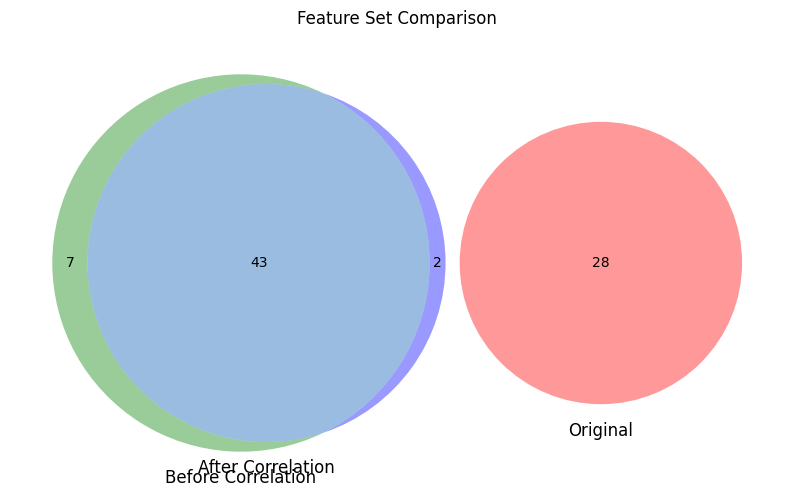

[INFO]: Starting feature scaling and preparation.
[INFO]: Feature scaling completed.


<ipython-input-111-9e74f1c2681d>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=initial_vif_sorted.head(20), palette="coolwarm")


No highly correlated features found to remove.
[INFO]: Dropped highly correlated features: []
Removing rolling_fgm with VIF: inf
Removing rolling_fg_pct with VIF: inf
Removing rolling_fg3m with VIF: inf
Removing rolling_fg3a with VIF: inf
Removing rolling_ftm with VIF: inf
Removing rolling_oreb with VIF: inf
Removing rolling_dreb with VIF: inf
Removing rolling_stl with VIF: inf
Removing rolling_blk with VIF: inf
Removing rolling_tov with VIF: inf
Removing rolling_plus_minus with VIF: inf
Removing w_rank with VIF: inf
Removing min_rank with VIF: inf
Removing fgm_rank with VIF: inf
Removing opponent_pts_rank with VIF: 599.76
Removing opponent_reb_rank with VIF: 86.48
Removing stl_rank with VIF: 44.84
Removing fg3m_rank with VIF: 11.22
Removing oreb_rank with VIF: 8.36
Removing dreb_rank with VIF: 7.37
[INFO]: Features retained after VIF reduction: ['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'gp_rank', 'fga_rank', 'fg_pct_rank', 'fg3_pct_rank', 'ftm_rank', 'ft_pct_rank', 

<ipython-input-111-9e74f1c2681d>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=final_vif_sorted.head(20), palette="coolwarm")


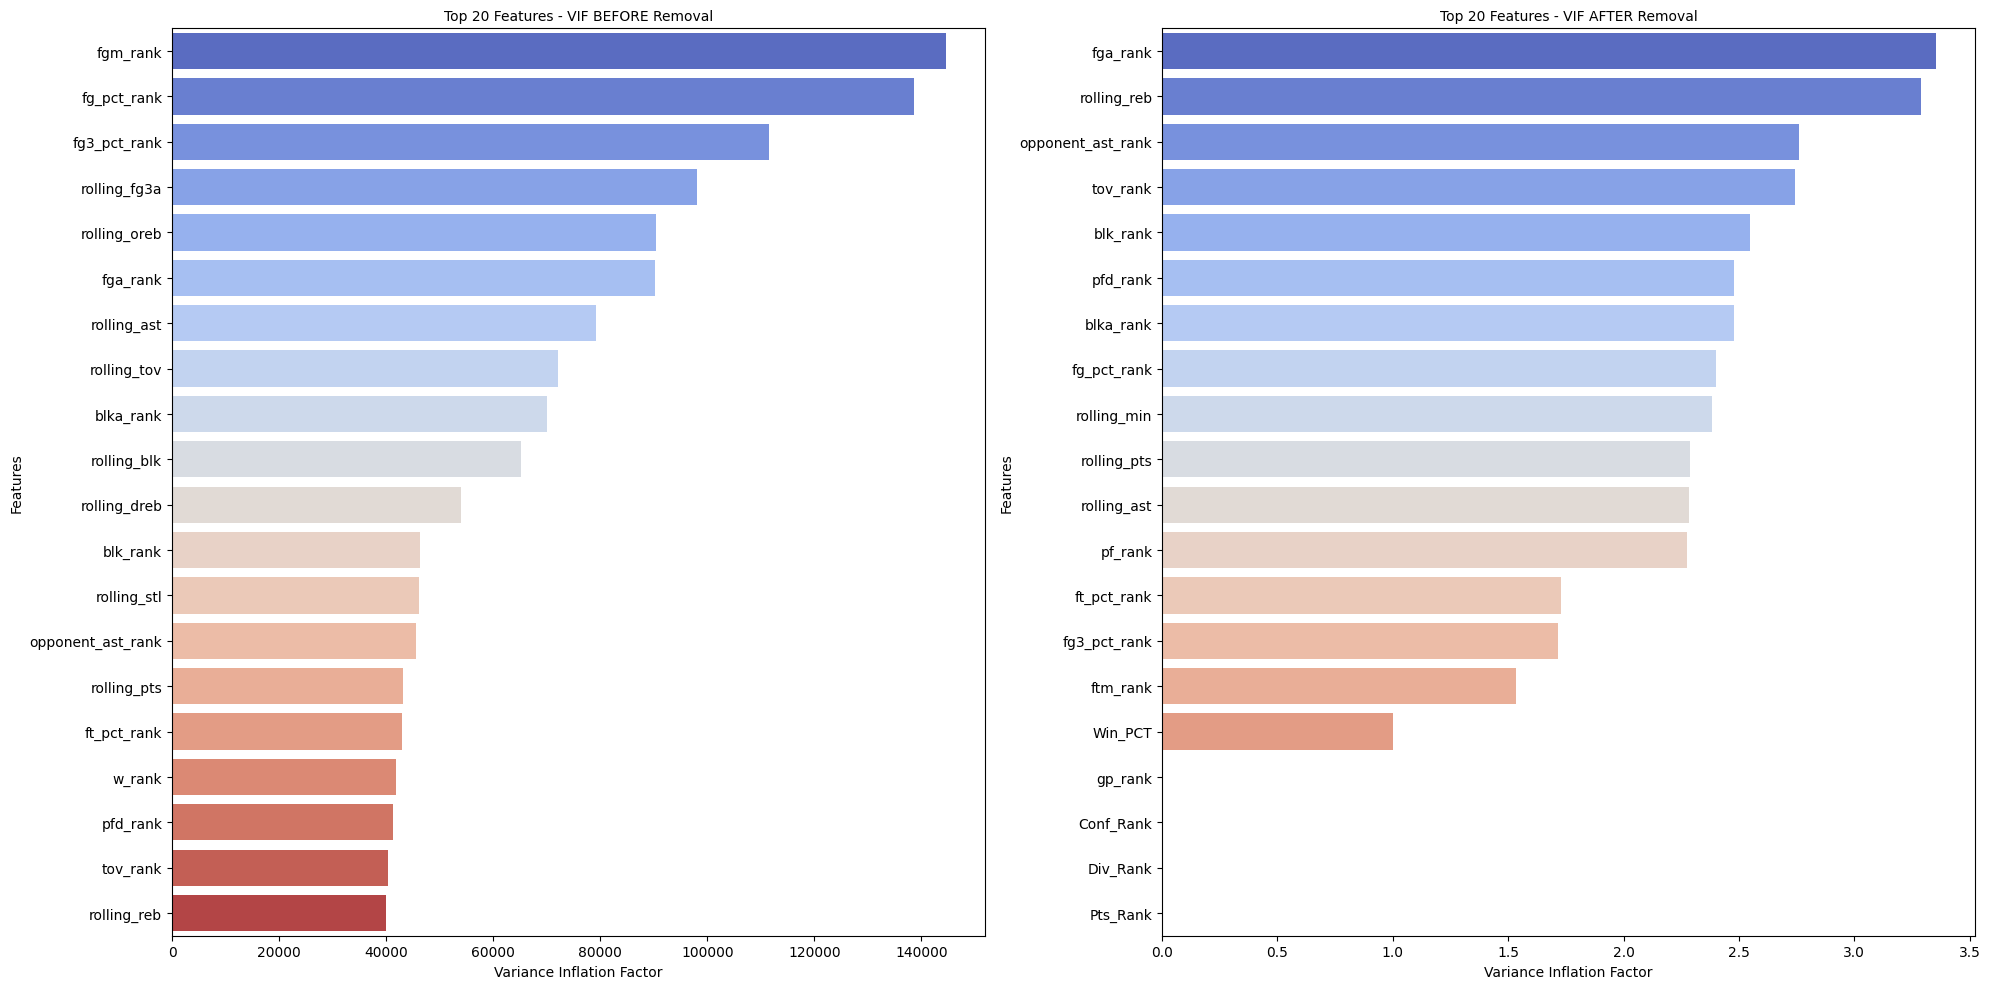


--- Feature Analysis ---
Original Features Count: 44
Features After Correlation Removal: 24

--- Dropped Features ---
Correlation Dropped Features: []

--- Remaining Features ---
['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'gp_rank', 'fga_rank', 'fg_pct_rank', 'fg3_pct_rank', 'ftm_rank', 'ft_pct_rank', 'opponent_ast_rank', 'tov_rank', 'blk_rank', 'blka_rank', 'pf_rank', 'pfd_rank', 'Win_PCT', 'Conf_Rank', 'Div_Rank', 'Pts_Rank', 'Reb_Rank', 'Ast_Rank', 'Opp_Pts_Rank', 'seasonweight']


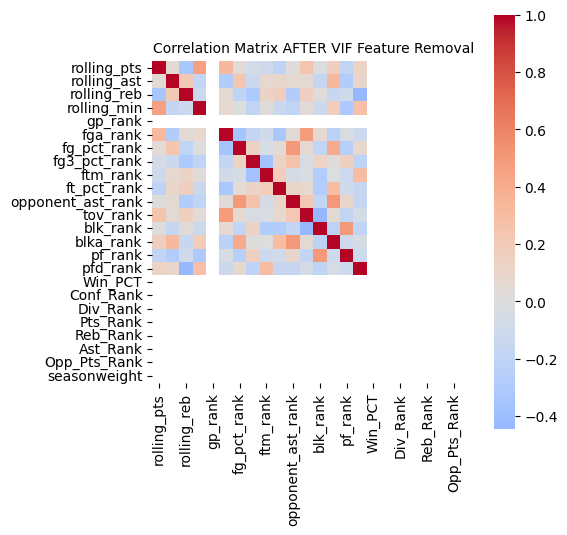

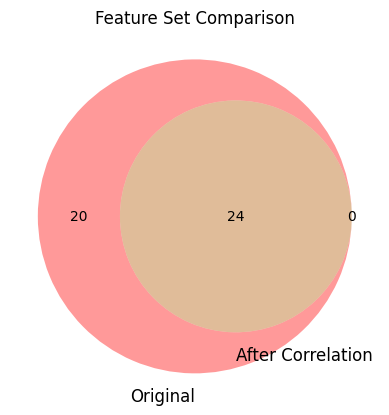

[INFO]: Calculated VIF data.
[INFO]: Initial VIF Data:
[DEBUG]:               Feature       VIF
5            fga_rank  3.356220
2         rolling_reb  3.287127
10  opponent_ast_rank  2.760411
11           tov_rank  2.743743
12           blk_rank  2.549496
15           pfd_rank  2.479079
13          blka_rank  2.477443
6         fg_pct_rank  2.400948
3         rolling_min  2.383772
0         rolling_pts  2.286361
1         rolling_ast  2.284489
14            pf_rank  2.275635
9         ft_pct_rank  1.728696
7        fg3_pct_rank  1.717841
8            ftm_rank  1.533881
4             gp_rank       NaN
16            Win_PCT       NaN
17          Conf_Rank       NaN
18           Div_Rank       NaN
19           Pts_Rank       NaN
20           Reb_Rank       NaN
21           Ast_Rank       NaN
22       Opp_Pts_Rank       NaN
23       seasonweight       NaN
[INFO]: Preparing next_game_features for scaling and prediction.
[INFO]: Successfully scaled next_game_features.
[INFO]: Splitting data 

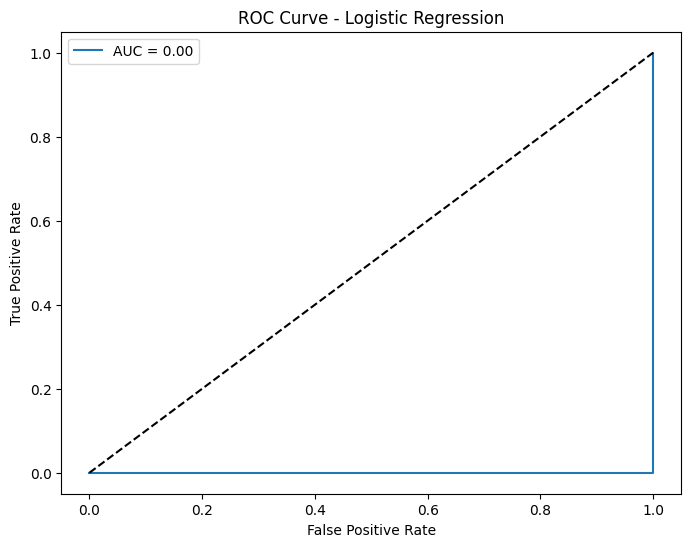

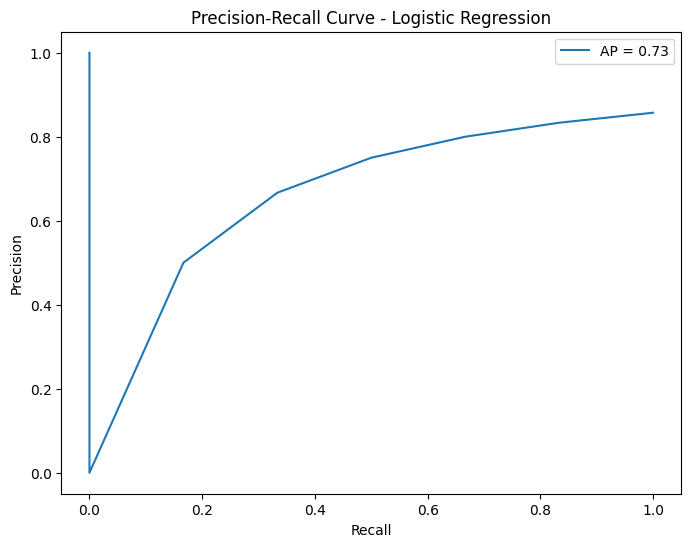

Feature importance not available for Logistic Regression.
Number of Misclassified Samples: 7
[INFO]: Logistic Regression evaluation completed.


Evaluating Random Forest...
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.14      1.00      0.25         1
           1       0.00      0.00      0.00         6

    accuracy                           0.14         7
   macro avg       0.07      0.50      0.12         7
weighted avg       0.02      0.14      0.04         7

Precision: 0.0204, Recall: 0.1429, F1 Score: 0.0357
Confusion Matrix:
[[1 0]
 [6 0]]


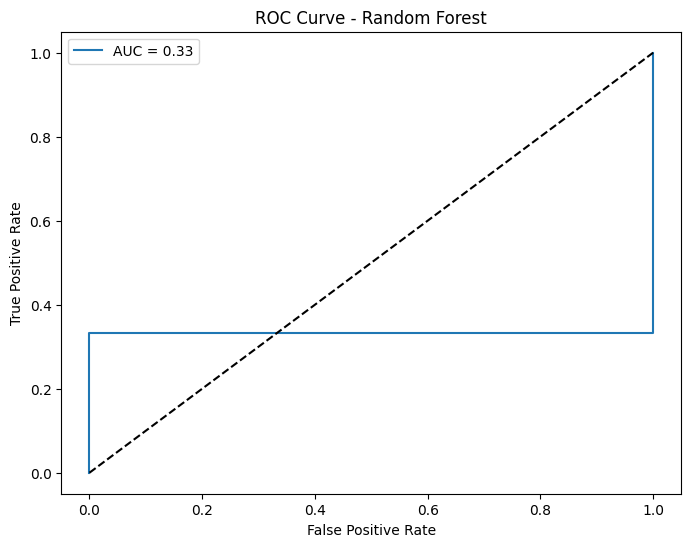

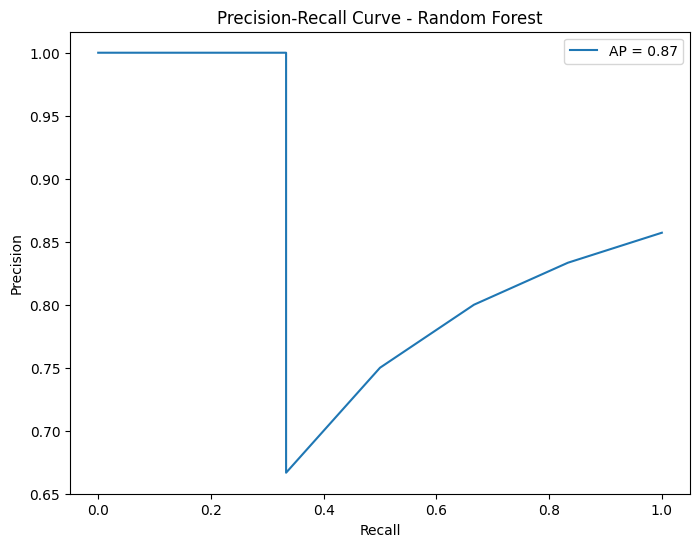

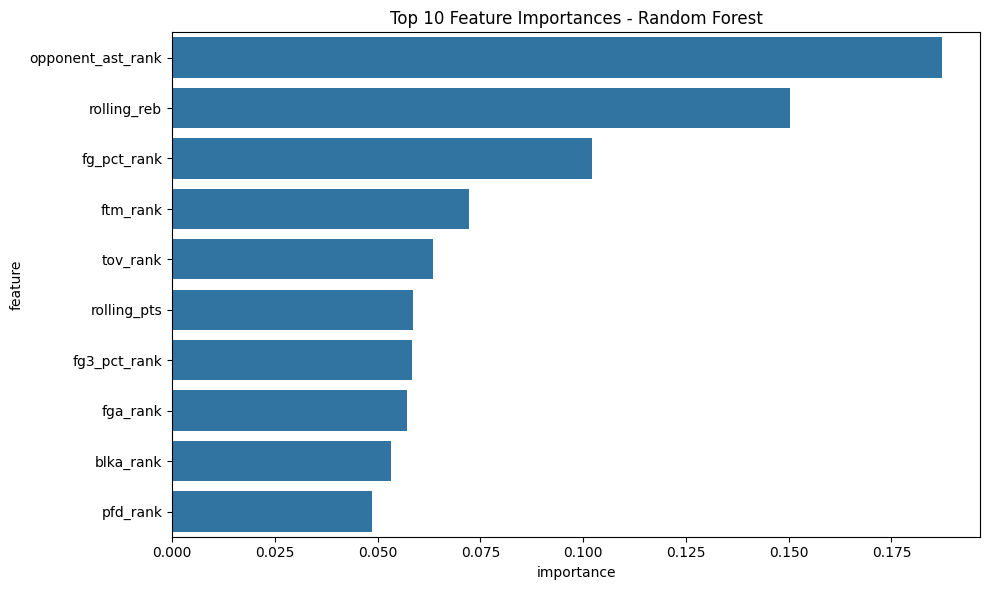

Number of Misclassified Samples: 6
[INFO]: Random Forest evaluation completed.


Evaluating Gradient Boosting...
Classification report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       6.0

    accuracy                           0.00       7.0
   macro avg       0.00      0.00      0.00       7.0
weighted avg       0.00      0.00      0.00       7.0

Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Confusion Matrix:
[[0 1]
 [6 0]]


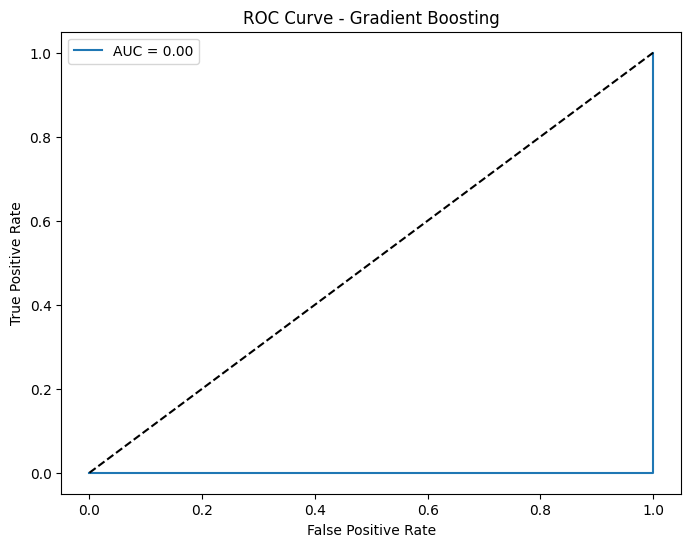

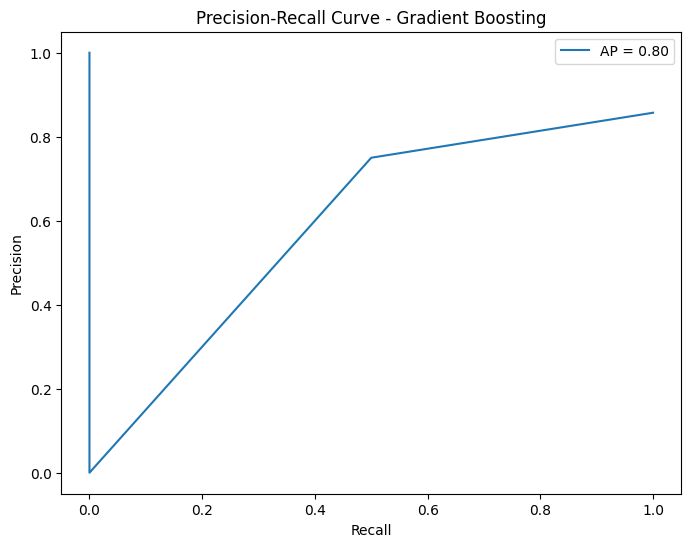

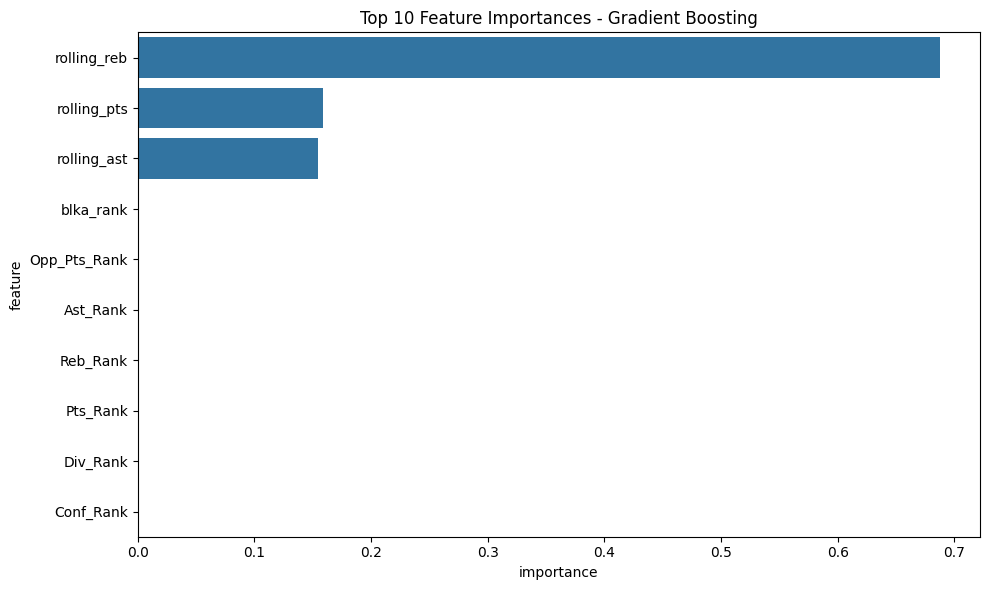

Number of Misclassified Samples: 7
[INFO]: Gradient Boosting evaluation completed.


Evaluating Neural Network...
Classification report for Neural Network:
              precision    recall  f1-score   support

           0       0.14      1.00      0.25         1
           1       0.00      0.00      0.00         6

    accuracy                           0.14         7
   macro avg       0.07      0.50      0.12         7
weighted avg       0.02      0.14      0.04         7

Precision: 0.0204, Recall: 0.1429, F1 Score: 0.0357
Confusion Matrix:
[[1 0]
 [6 0]]


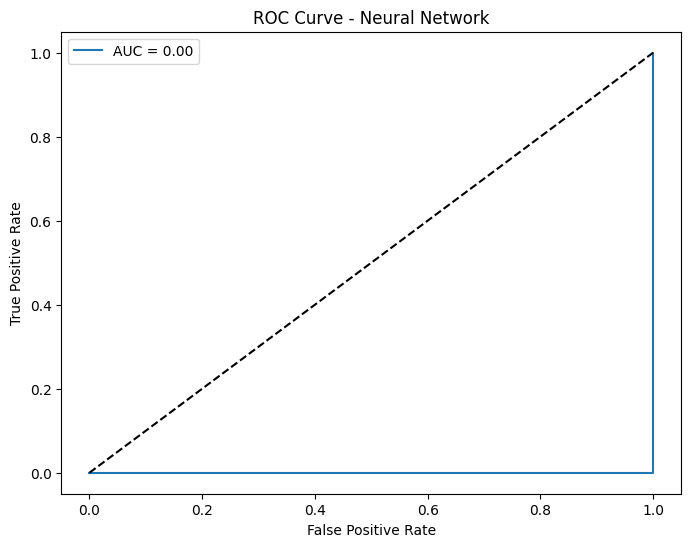

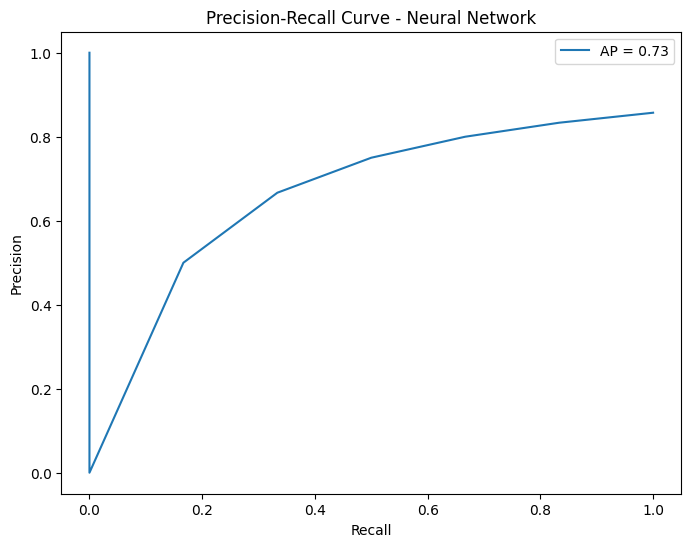

Feature importance not available for Neural Network.
Number of Misclassified Samples: 6
[INFO]: Neural Network evaluation completed.


Evaluating Voting Classifier Ensemble...
Classification report for Voting Classifier Ensemble:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       6.0

    accuracy                           0.00       7.0
   macro avg       0.00      0.00      0.00       7.0
weighted avg       0.00      0.00      0.00       7.0

Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
Confusion Matrix:
[[0 1]
 [6 0]]


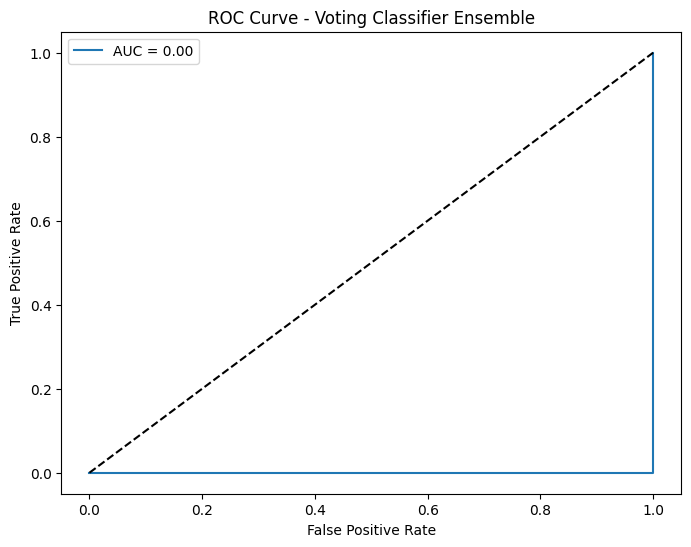

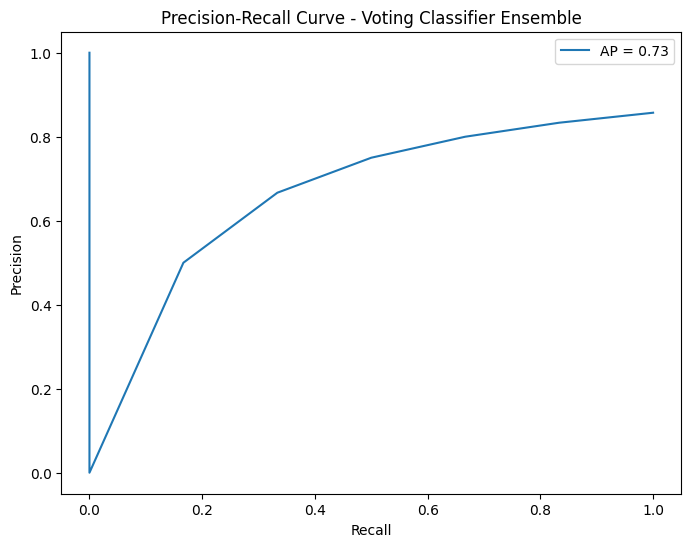

Feature importance not available for Voting Classifier Ensemble.
Number of Misclassified Samples: 7
[INFO]: Voting Classifier Ensemble evaluation completed.


Evaluating Stacking Classifier Ensemble...
Classification report for Stacking Classifier Ensemble:
              precision    recall  f1-score   support

           0       0.14      1.00      0.25         1
           1       0.00      0.00      0.00         6

    accuracy                           0.14         7
   macro avg       0.07      0.50      0.12         7
weighted avg       0.02      0.14      0.04         7

Precision: 0.0204, Recall: 0.1429, F1 Score: 0.0357
Confusion Matrix:
[[1 0]
 [6 0]]


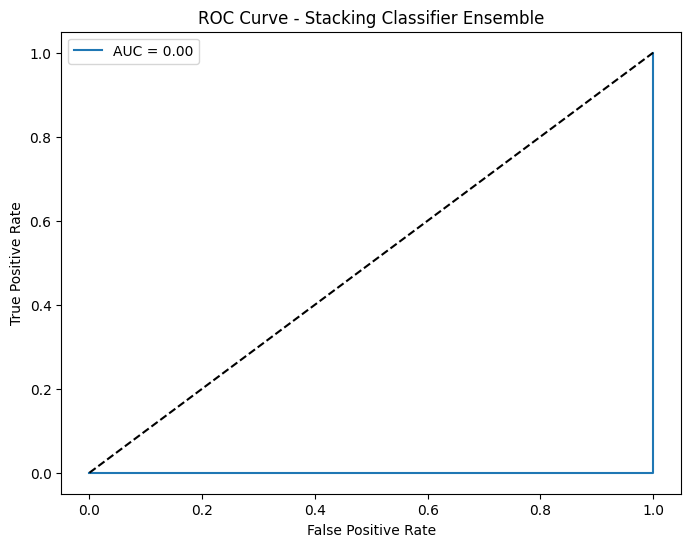

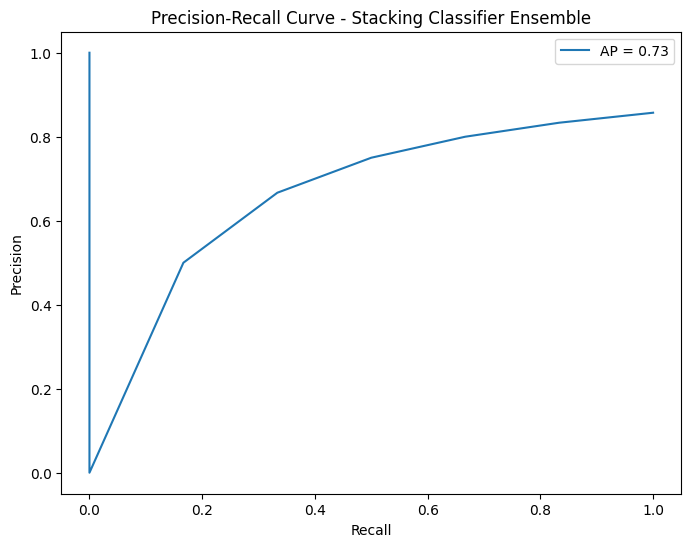

Feature importance not available for Stacking Classifier Ensemble.
Number of Misclassified Samples: 6
[INFO]: Stacking Classifier Ensemble evaluation completed.



Blended Prediction for Next Game:
Prediction: Under
Probability of Under: 0.54
Probability of Over: 0.46
Prediction for pts (stat line 32.5): Under
Probability of Under: 0.54
Probability of Over: 0.46

--- Processing Trae Young ---
1629027

Next Game Details:
GAME_DATE            DEC 14, 2024
HOME_TEAM_NAME          Milwaukee
VISITOR_TEAM_NAME         Atlanta
GAME_TIME                04:30 PM
Name: 0, dtype: object

[Debug] Starting dataset preparation...
Columns in fetched player game log for season 2024-25: Index(['season_id', 'player_id', 'game_id', 'game_date', 'matchup', 'wl',
       'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf',
       'pts', 'plus_minus', 'video_available'],
      dtype='object')
Columns in fetched playe

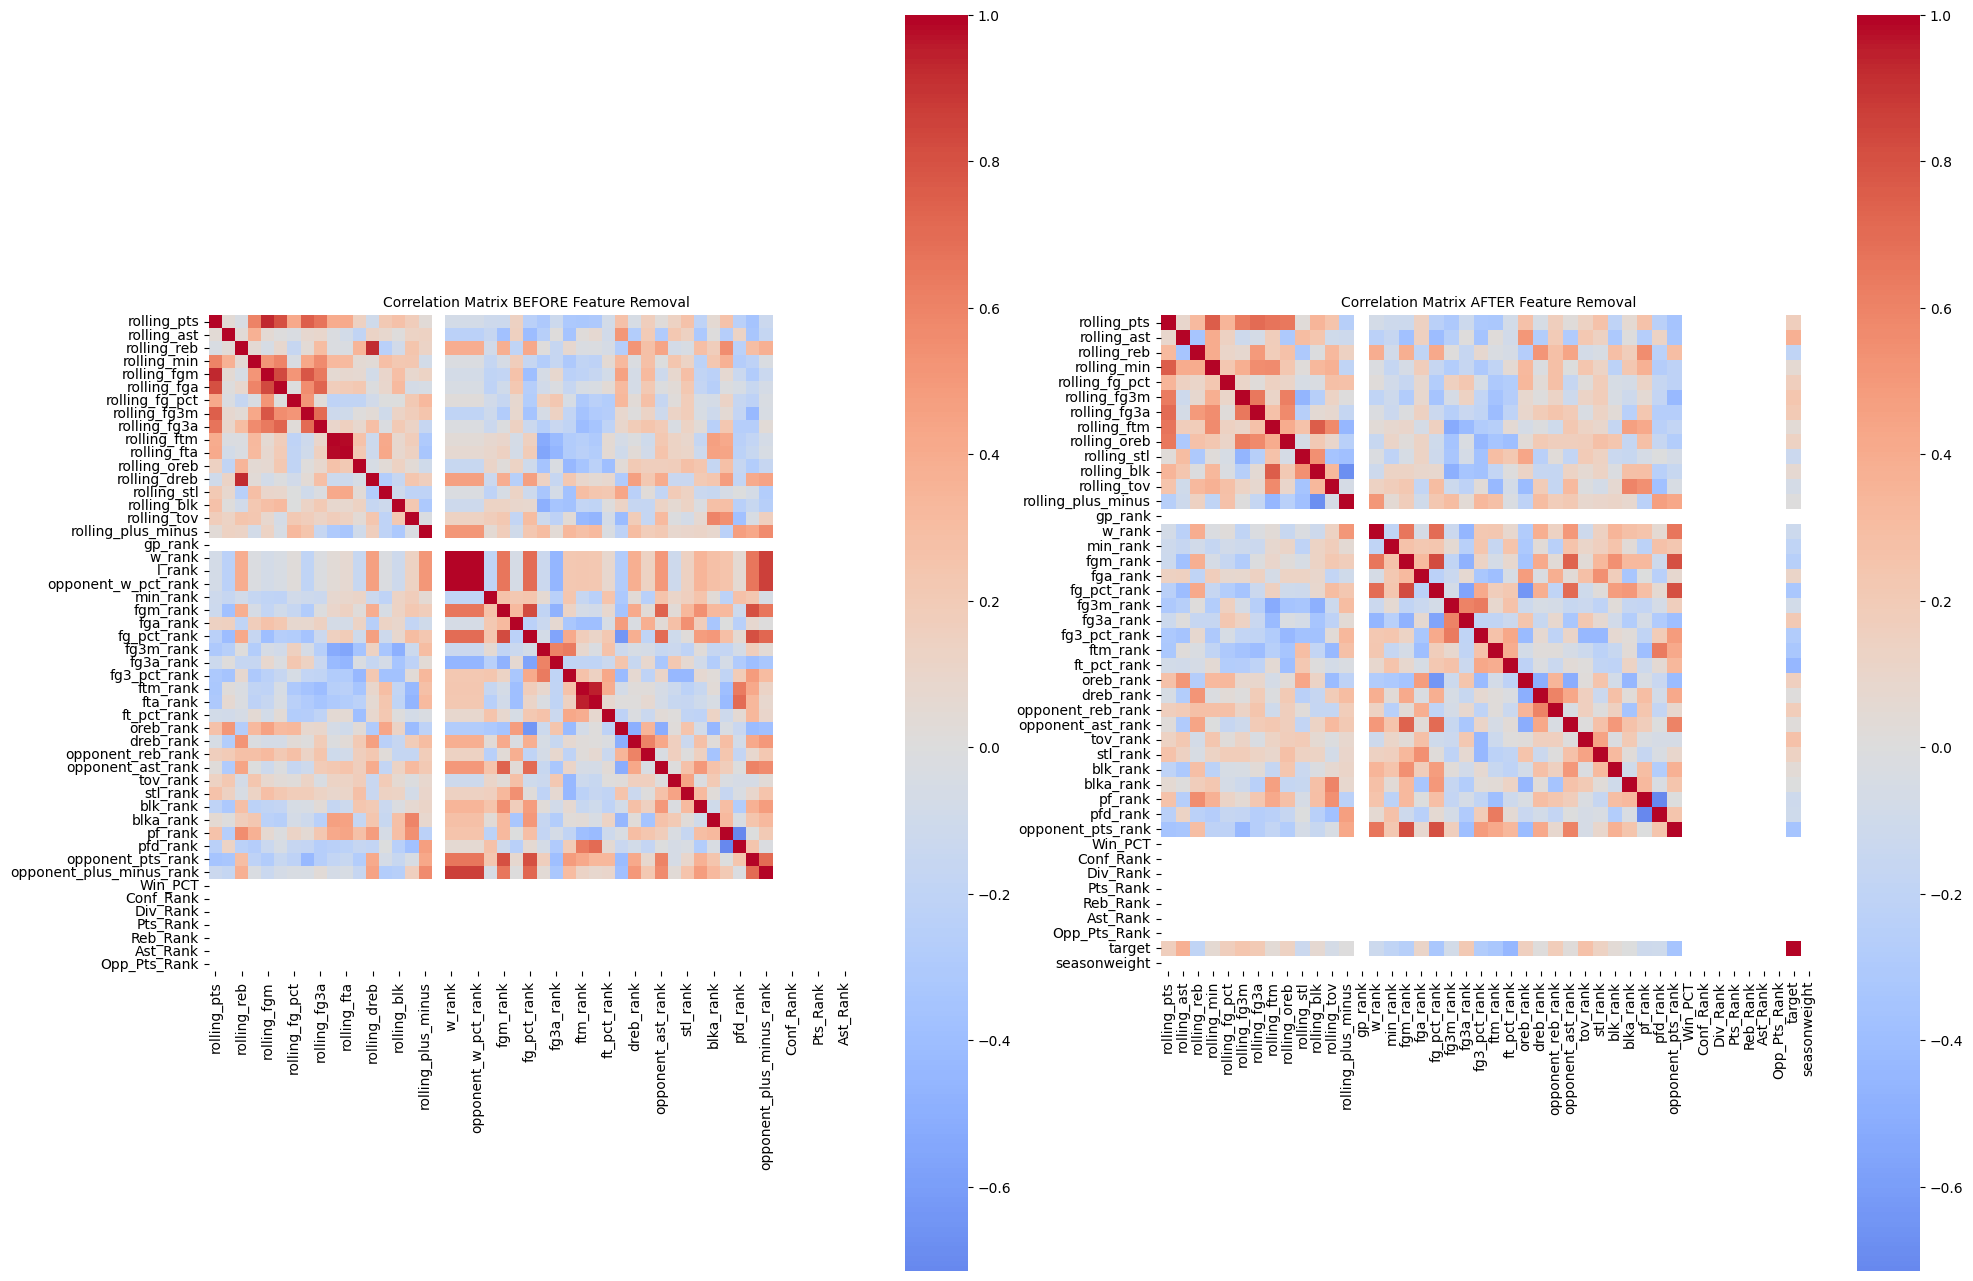


--- Feature Analysis ---
Original Features Count: 28
Features Before Correlation Removal: 50
Features After Correlation Removal: 44

--- Dropped Features ---
['rolling_fgm', 'rolling_fga', 'rolling_fta', 'rolling_dreb', 'l_rank', 'opponent_w_pct_rank', 'fta_rank', 'opponent_plus_minus_rank']

--- Remaining Features ---
['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'rolling_fg_pct', 'rolling_fg3m', 'rolling_fg3a', 'rolling_ftm', 'rolling_oreb', 'rolling_stl', 'rolling_blk', 'rolling_tov', 'rolling_plus_minus', 'gp_rank', 'w_rank', 'min_rank', 'fgm_rank', 'fga_rank', 'fg_pct_rank', 'fg3m_rank', 'fg3a_rank', 'fg3_pct_rank', 'ftm_rank', 'ft_pct_rank', 'oreb_rank', 'dreb_rank', 'opponent_reb_rank', 'opponent_ast_rank', 'tov_rank', 'stl_rank', 'blk_rank', 'blka_rank', 'pf_rank', 'pfd_rank', 'opponent_pts_rank', 'Win_PCT', 'Conf_Rank', 'Div_Rank', 'Pts_Rank', 'Reb_Rank', 'Ast_Rank', 'Opp_Pts_Rank', 'target', 'seasonweight']


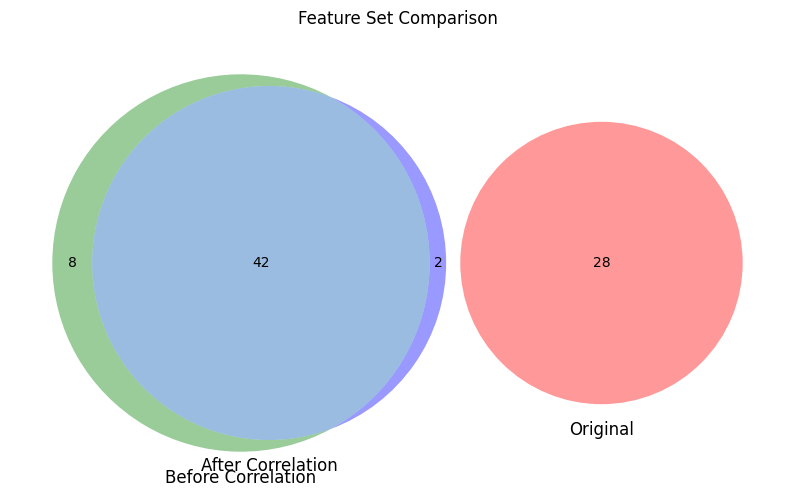

[INFO]: Starting feature scaling and preparation.
[INFO]: Feature scaling completed.


<ipython-input-111-9e74f1c2681d>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=initial_vif_sorted.head(20), palette="coolwarm")


No highly correlated features found to remove.
[INFO]: Dropped highly correlated features: []
Removing rolling_fg_pct with VIF: inf
Removing rolling_fg3m with VIF: inf
Removing rolling_fg3a with VIF: inf
Removing rolling_ftm with VIF: inf
Removing rolling_oreb with VIF: inf
Removing rolling_stl with VIF: inf
Removing rolling_blk with VIF: inf
Removing rolling_tov with VIF: inf
Removing rolling_plus_minus with VIF: inf
Removing w_rank with VIF: inf
Removing opponent_pts_rank with VIF: 11085.21
Removing fgm_rank with VIF: 534.02
Removing fg3m_rank with VIF: 119.37
Removing opponent_reb_rank with VIF: 42.15
Removing oreb_rank with VIF: 18.29
Removing fg_pct_rank with VIF: 17.39
Removing pfd_rank with VIF: 11.05
Removing pf_rank with VIF: 8.16
[INFO]: Features retained after VIF reduction: ['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'gp_rank', 'min_rank', 'fga_rank', 'fg3a_rank', 'fg3_pct_rank', 'ftm_rank', 'ft_pct_rank', 'dreb_rank', 'opponent_ast_rank', 'tov_rank', 'stl_

<ipython-input-111-9e74f1c2681d>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=final_vif_sorted.head(20), palette="coolwarm")


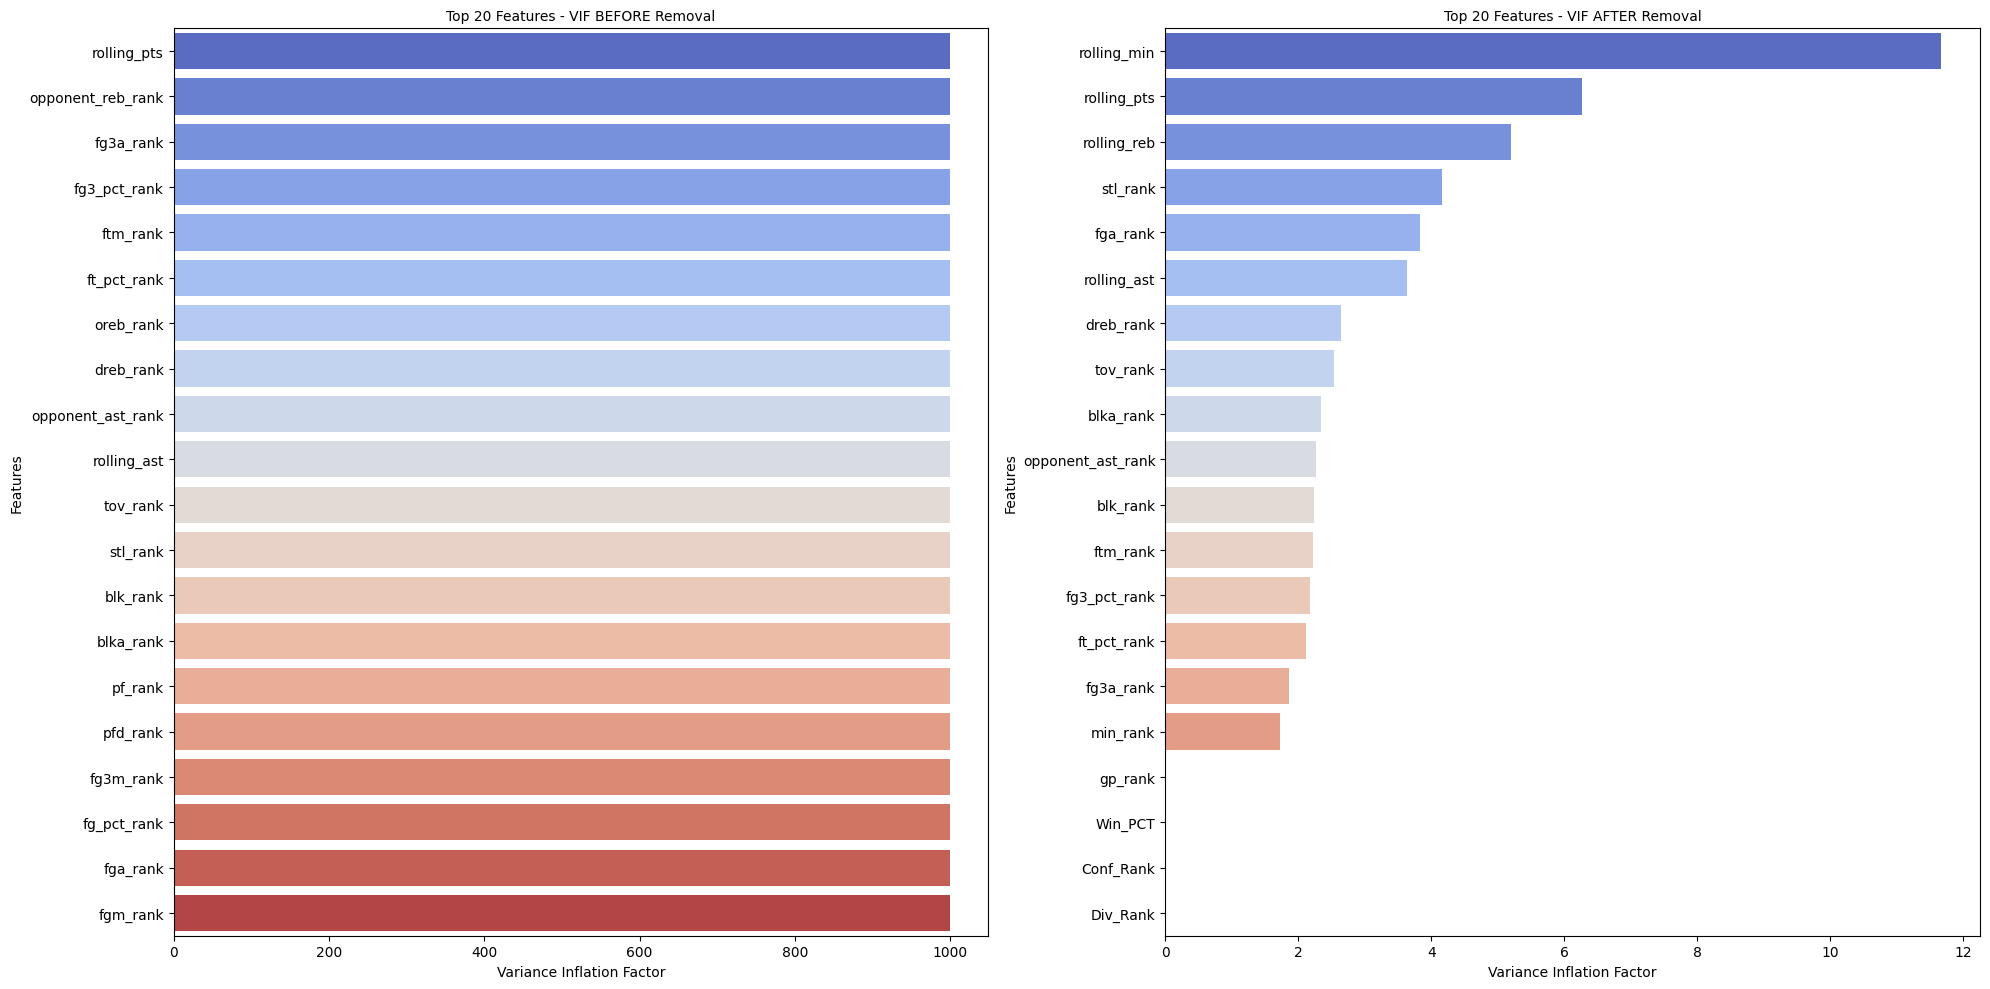


--- Feature Analysis ---
Original Features Count: 43
Features After Correlation Removal: 25

--- Dropped Features ---
Correlation Dropped Features: []

--- Remaining Features ---
['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'gp_rank', 'min_rank', 'fga_rank', 'fg3a_rank', 'fg3_pct_rank', 'ftm_rank', 'ft_pct_rank', 'dreb_rank', 'opponent_ast_rank', 'tov_rank', 'stl_rank', 'blk_rank', 'blka_rank', 'Win_PCT', 'Conf_Rank', 'Div_Rank', 'Pts_Rank', 'Reb_Rank', 'Ast_Rank', 'Opp_Pts_Rank', 'seasonweight']


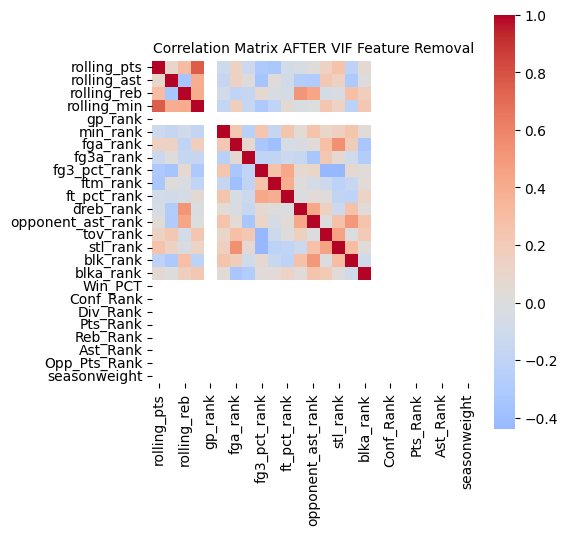

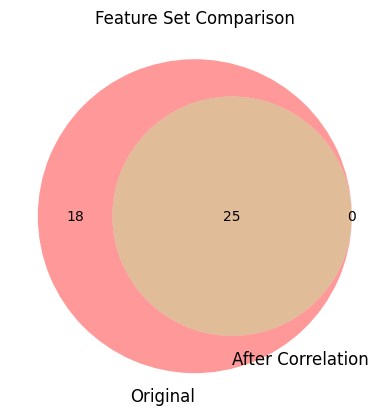

[INFO]: Calculated VIF data.
[INFO]: Initial VIF Data:
[DEBUG]:               Feature        VIF
3         rolling_min  11.672095
0         rolling_pts   6.268228
2         rolling_reb   5.192899
14           stl_rank   4.162409
6            fga_rank   3.827188
1         rolling_ast   3.642524
11          dreb_rank   2.641813
13           tov_rank   2.533123
16          blka_rank   2.334574
12  opponent_ast_rank   2.267486
15           blk_rank   2.243172
9            ftm_rank   2.218942
8        fg3_pct_rank   2.175257
10        ft_pct_rank   2.116735
7           fg3a_rank   1.860442
5            min_rank   1.719892
4             gp_rank        NaN
17            Win_PCT        NaN
18          Conf_Rank        NaN
19           Div_Rank        NaN
20           Pts_Rank        NaN
21           Reb_Rank        NaN
22           Ast_Rank        NaN
23       Opp_Pts_Rank        NaN
24       seasonweight        NaN
[INFO]: Preparing next_game_features for scaling and prediction.
[INFO]: Succe

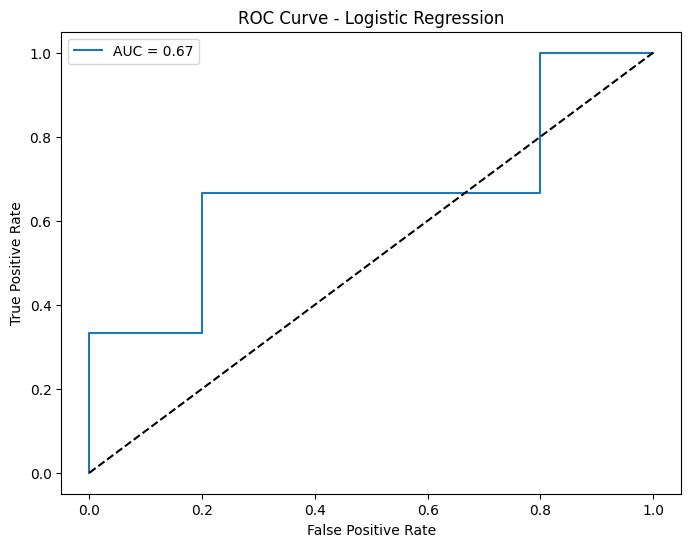

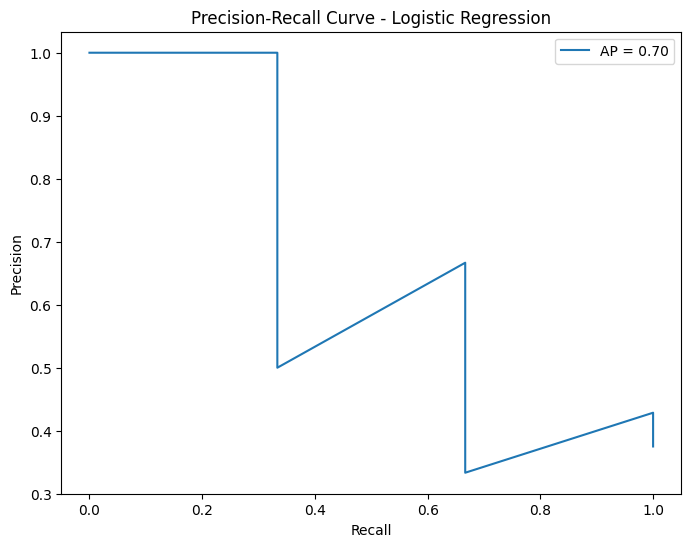

Feature importance not available for Logistic Regression.
Number of Misclassified Samples: 4
[INFO]: Logistic Regression evaluation completed.


Evaluating Random Forest...
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.43      1.00      0.60         3

    accuracy                           0.50         8
   macro avg       0.71      0.60      0.47         8
weighted avg       0.79      0.50      0.43         8

Precision: 0.7857, Recall: 0.5000, F1 Score: 0.4333
Confusion Matrix:
[[1 4]
 [0 3]]


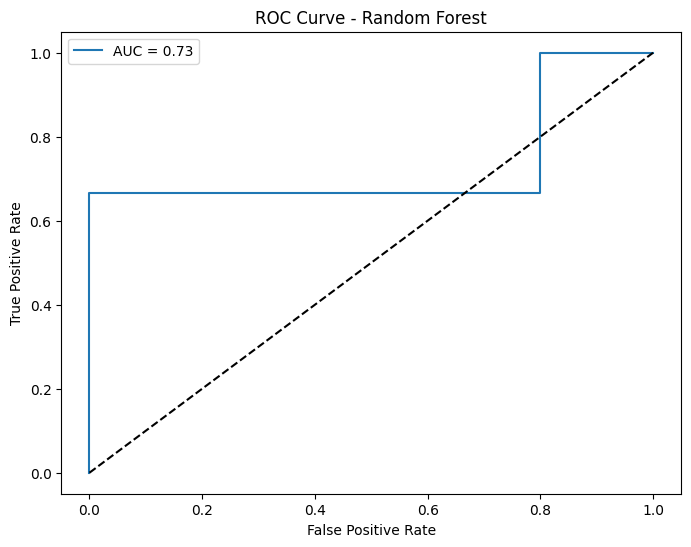

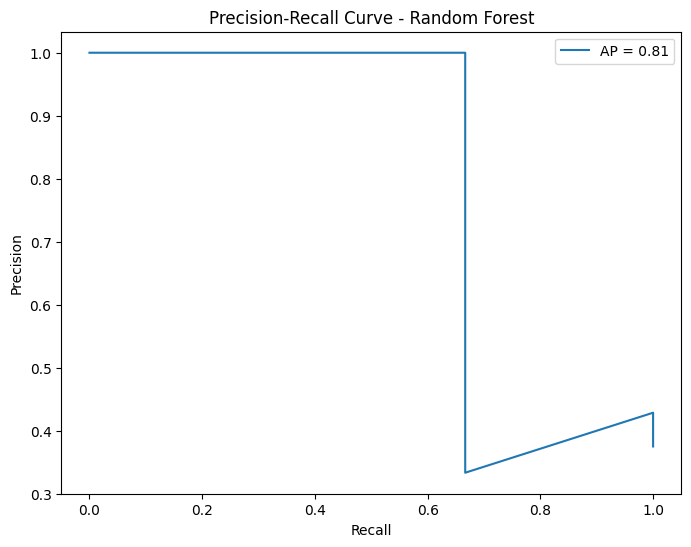

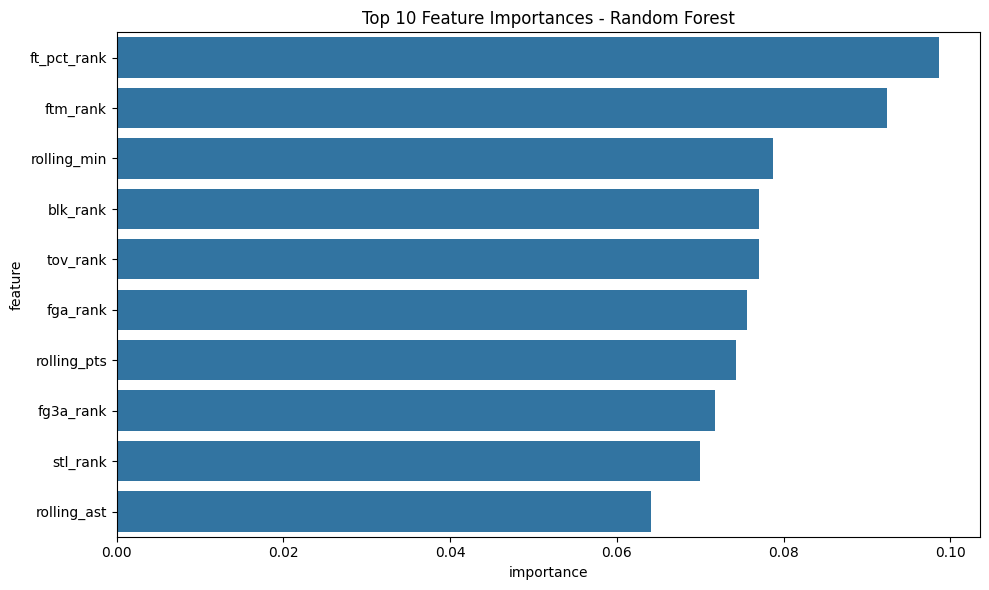

Number of Misclassified Samples: 4
[INFO]: Random Forest evaluation completed.


Evaluating Gradient Boosting...
Classification report for Gradient Boosting:
              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.60      1.00      0.75         3

    accuracy                           0.75         8
   macro avg       0.80      0.80      0.75         8
weighted avg       0.85      0.75      0.75         8

Precision: 0.8500, Recall: 0.7500, F1 Score: 0.7500
Confusion Matrix:
[[3 2]
 [0 3]]


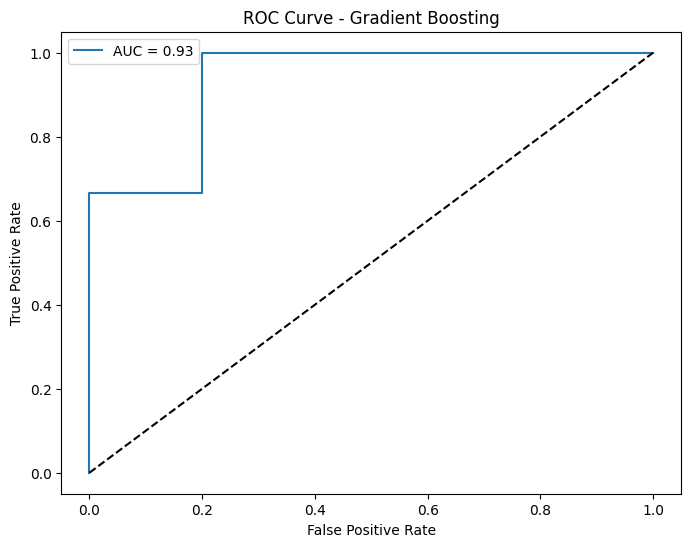

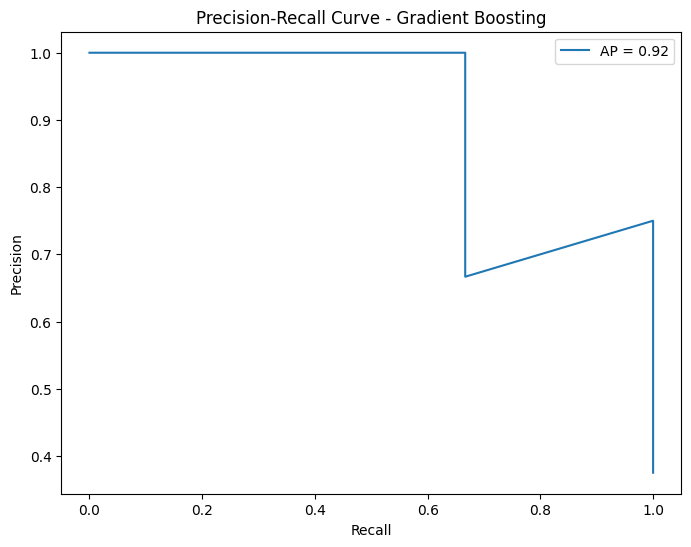

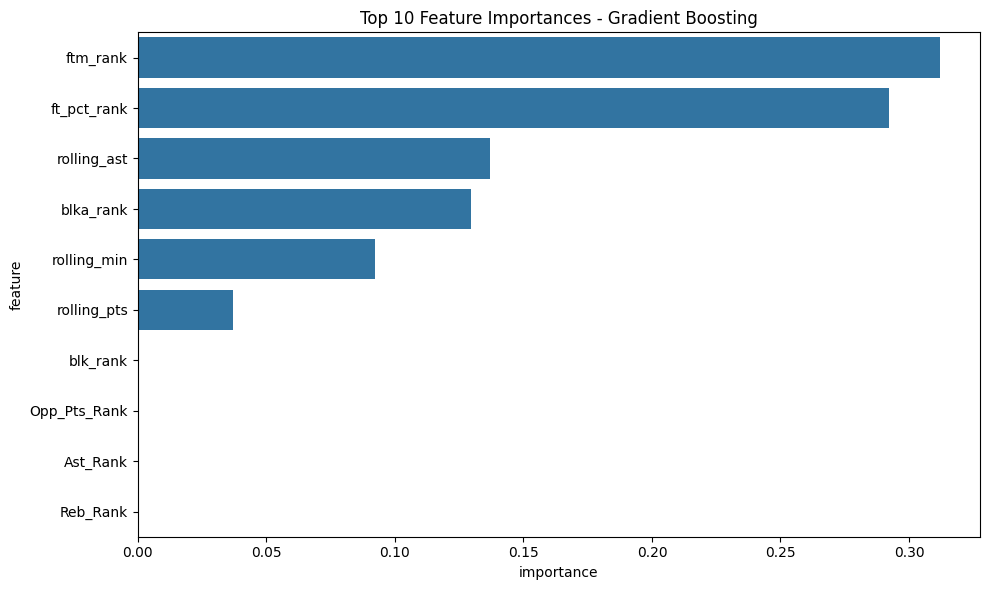

Number of Misclassified Samples: 2
[INFO]: Gradient Boosting evaluation completed.


Evaluating Neural Network...
Classification report for Neural Network:
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.33      0.67      0.44         3

    accuracy                           0.38         8
   macro avg       0.42      0.43      0.37         8
weighted avg       0.44      0.38      0.35         8

Precision: 0.4375, Recall: 0.3750, F1 Score: 0.3452
Confusion Matrix:
[[1 4]
 [1 2]]


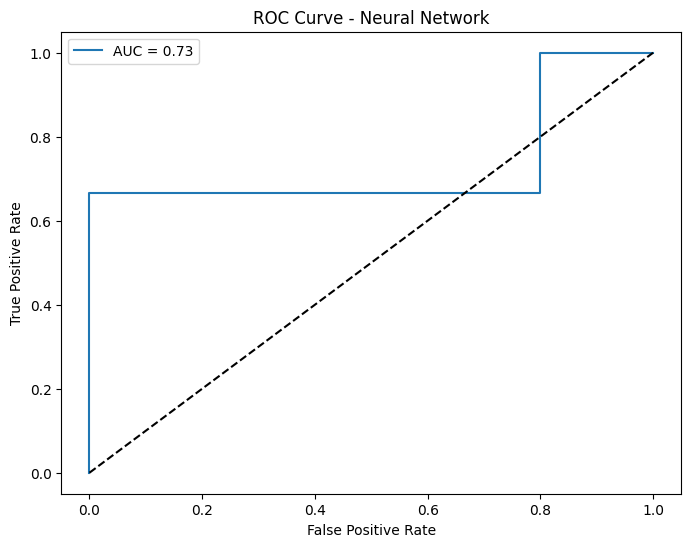

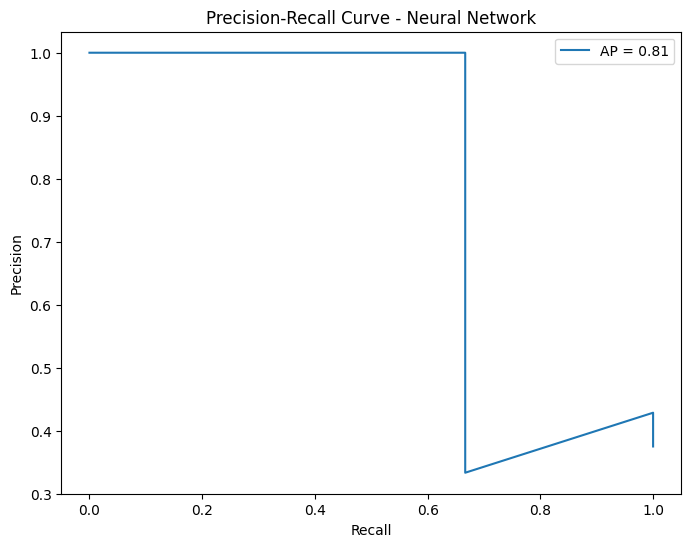

Feature importance not available for Neural Network.
Number of Misclassified Samples: 5
[INFO]: Neural Network evaluation completed.


Evaluating Voting Classifier Ensemble...
Classification report for Voting Classifier Ensemble:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.40      0.67      0.50         3

    accuracy                           0.50         8
   macro avg       0.53      0.53      0.50         8
weighted avg       0.57      0.50      0.50         8

Precision: 0.5667, Recall: 0.5000, F1 Score: 0.5000
Confusion Matrix:
[[2 3]
 [1 2]]


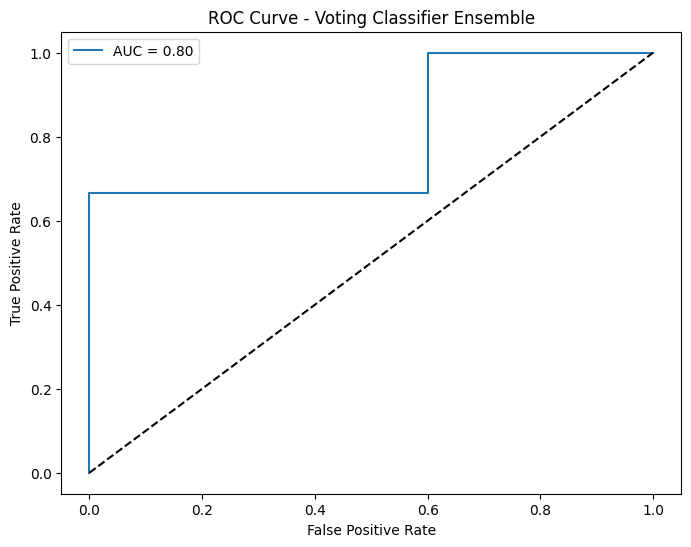

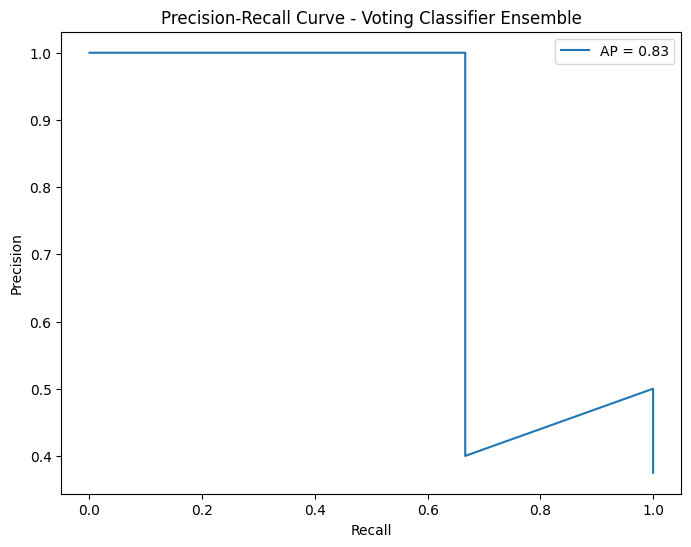

Feature importance not available for Voting Classifier Ensemble.
Number of Misclassified Samples: 4
[INFO]: Voting Classifier Ensemble evaluation completed.


Evaluating Stacking Classifier Ensemble...
Classification report for Stacking Classifier Ensemble:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.17      0.33      0.22         3

    accuracy                           0.12         8
   macro avg       0.08      0.17      0.11         8
weighted avg       0.06      0.12      0.08         8

Precision: 0.0625, Recall: 0.1250, F1 Score: 0.0833
Confusion Matrix:
[[0 5]
 [2 1]]


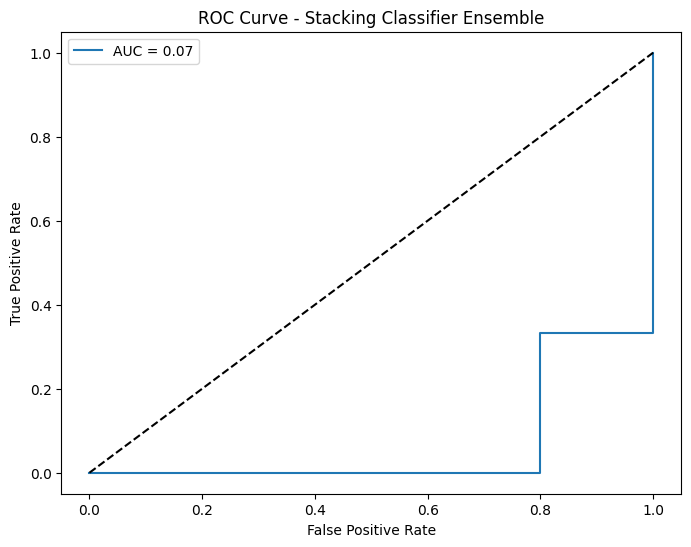

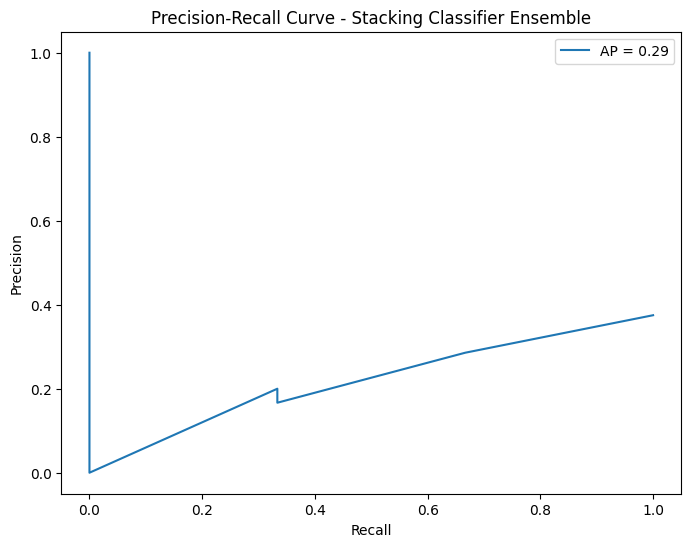

Feature importance not available for Stacking Classifier Ensemble.
Number of Misclassified Samples: 7
[INFO]: Stacking Classifier Ensemble evaluation completed.



Blended Prediction for Next Game:
Prediction: Over
Probability of Under: 0.28
Probability of Over: 0.72
Prediction for ast (stat line 11.5): Over
Probability of Under: 0.28
Probability of Over: 0.72

--- Processing Alperen Sengun ---
1630578

Next Game Details:
GAME_DATE             DEC 14, 2024
HOME_TEAM_NAME       Oklahoma City
VISITOR_TEAM_NAME          Houston
GAME_TIME                 08:30 PM
Name: 0, dtype: object

[Debug] Starting dataset preparation...
Columns in fetched player game log for season 2024-25: Index(['season_id', 'player_id', 'game_id', 'game_date', 'matchup', 'wl',
       'min', 'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf',
       'pts', 'plus_minus', 'video_available'],
      dtype='object')
Columns in fetched

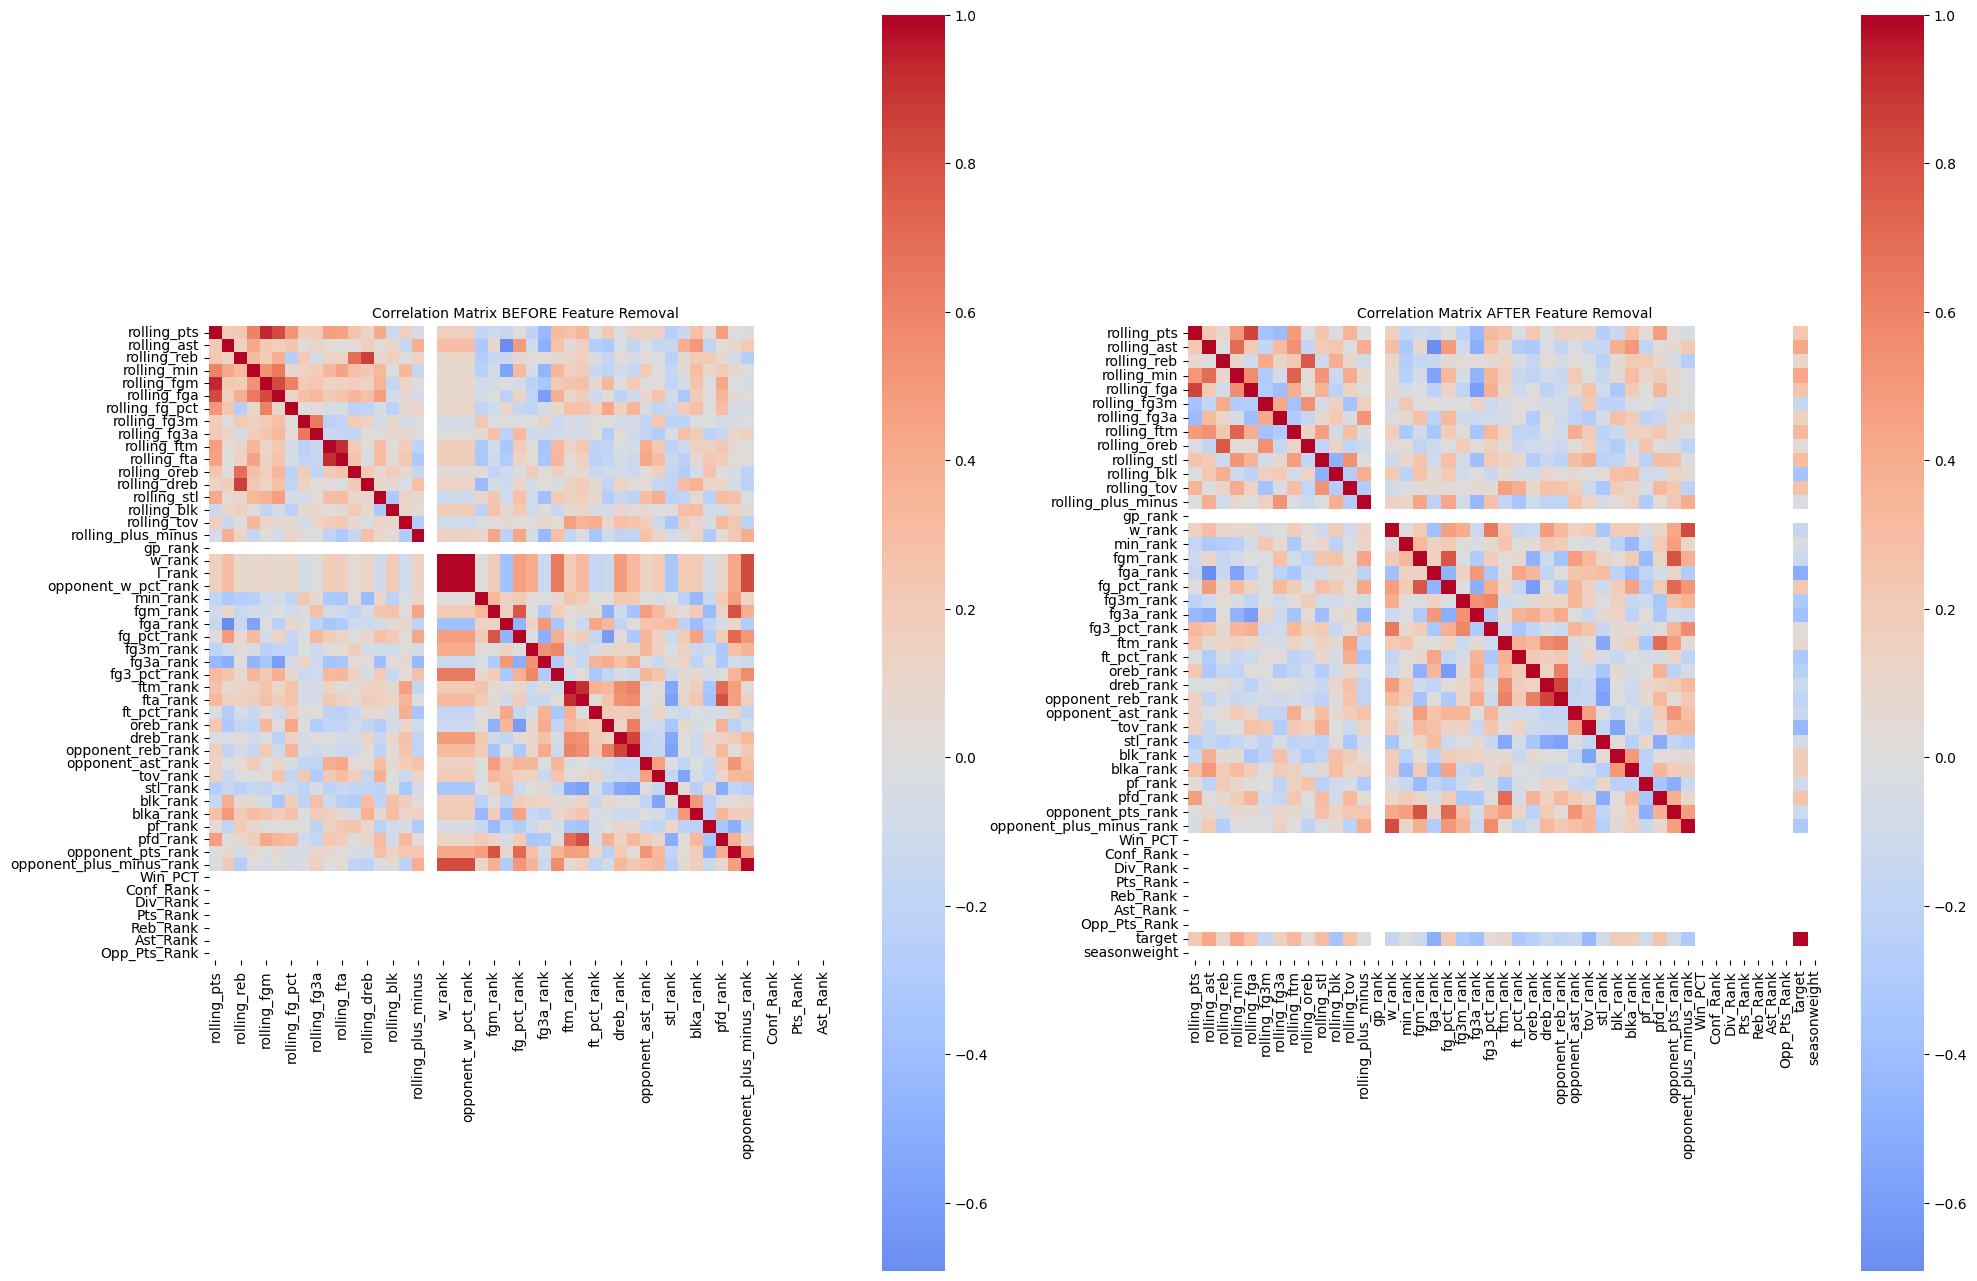


--- Feature Analysis ---
Original Features Count: 28
Features Before Correlation Removal: 50
Features After Correlation Removal: 45

--- Dropped Features ---
['rolling_fgm', 'rolling_fg_pct', 'rolling_fta', 'rolling_dreb', 'l_rank', 'opponent_w_pct_rank', 'fta_rank']

--- Remaining Features ---
['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'rolling_fga', 'rolling_fg3m', 'rolling_fg3a', 'rolling_ftm', 'rolling_oreb', 'rolling_stl', 'rolling_blk', 'rolling_tov', 'rolling_plus_minus', 'gp_rank', 'w_rank', 'min_rank', 'fgm_rank', 'fga_rank', 'fg_pct_rank', 'fg3m_rank', 'fg3a_rank', 'fg3_pct_rank', 'ftm_rank', 'ft_pct_rank', 'oreb_rank', 'dreb_rank', 'opponent_reb_rank', 'opponent_ast_rank', 'tov_rank', 'stl_rank', 'blk_rank', 'blka_rank', 'pf_rank', 'pfd_rank', 'opponent_pts_rank', 'opponent_plus_minus_rank', 'Win_PCT', 'Conf_Rank', 'Div_Rank', 'Pts_Rank', 'Reb_Rank', 'Ast_Rank', 'Opp_Pts_Rank', 'target', 'seasonweight']


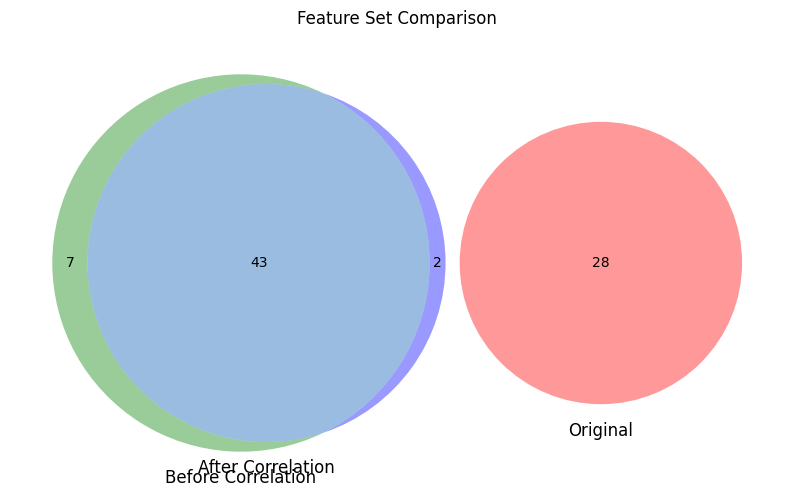

[INFO]: Starting feature scaling and preparation.
[INFO]: Feature scaling completed.


<ipython-input-111-9e74f1c2681d>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=initial_vif_sorted.head(20), palette="coolwarm")


No highly correlated features found to remove.
[INFO]: Dropped highly correlated features: []
Removing rolling_fga with VIF: inf
Removing rolling_fg3m with VIF: inf
Removing rolling_fg3a with VIF: inf
Removing rolling_ftm with VIF: inf
Removing rolling_oreb with VIF: inf
Removing rolling_stl with VIF: inf
Removing rolling_blk with VIF: inf
Removing rolling_tov with VIF: inf
Removing rolling_plus_minus with VIF: inf
Removing w_rank with VIF: inf
Removing min_rank with VIF: inf
Removing opponent_pts_rank with VIF: 716.51
Removing fg_pct_rank with VIF: 414.34
Removing opponent_reb_rank with VIF: 101.56
Removing fg3a_rank with VIF: 38.51
Removing pfd_rank with VIF: 18.53
Removing fga_rank with VIF: 17.71
Removing fg3_pct_rank with VIF: 12.63
Removing ftm_rank with VIF: 5.66
[INFO]: Features retained after VIF reduction: ['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'gp_rank', 'fgm_rank', 'fg3m_rank', 'ft_pct_rank', 'oreb_rank', 'dreb_rank', 'opponent_ast_rank', 'tov_rank', '

<ipython-input-111-9e74f1c2681d>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="VIF", y="Feature", data=final_vif_sorted.head(20), palette="coolwarm")


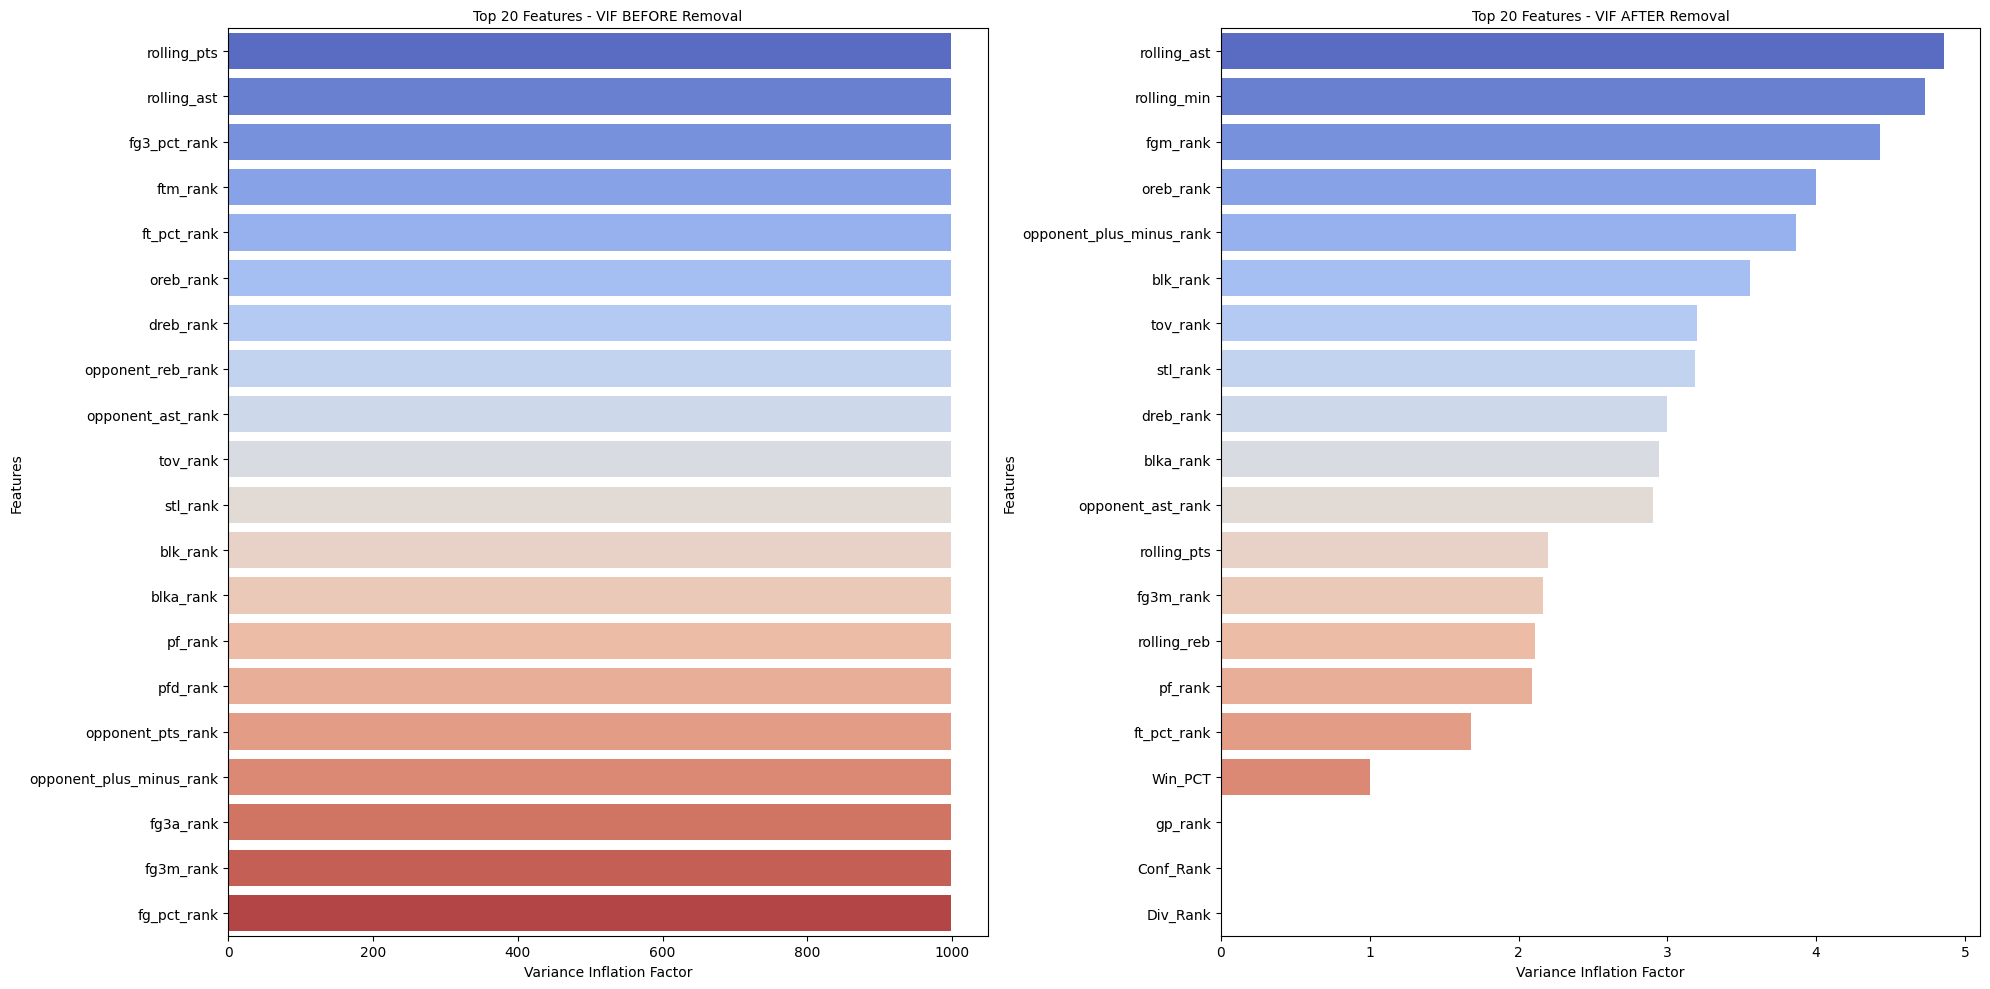


--- Feature Analysis ---
Original Features Count: 44
Features After Correlation Removal: 25

--- Dropped Features ---
Correlation Dropped Features: []

--- Remaining Features ---
['rolling_pts', 'rolling_ast', 'rolling_reb', 'rolling_min', 'gp_rank', 'fgm_rank', 'fg3m_rank', 'ft_pct_rank', 'oreb_rank', 'dreb_rank', 'opponent_ast_rank', 'tov_rank', 'stl_rank', 'blk_rank', 'blka_rank', 'pf_rank', 'opponent_plus_minus_rank', 'Win_PCT', 'Conf_Rank', 'Div_Rank', 'Pts_Rank', 'Reb_Rank', 'Ast_Rank', 'Opp_Pts_Rank', 'seasonweight']


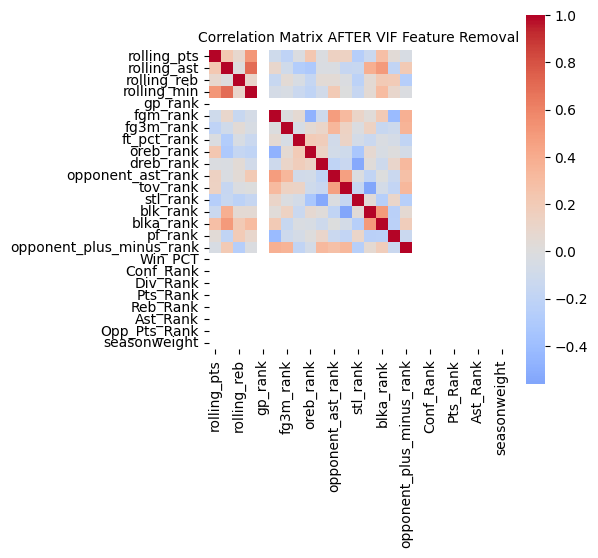

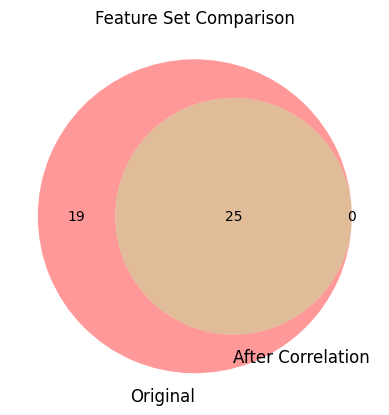

[INFO]: Calculated VIF data.
[INFO]: Initial VIF Data:
[DEBUG]:                      Feature       VIF
1                rolling_ast  4.857982
3                rolling_min  4.728853
5                   fgm_rank  4.429672
8                  oreb_rank  4.001910
16  opponent_plus_minus_rank  3.865039
13                  blk_rank  3.556291
11                  tov_rank  3.201641
12                  stl_rank  3.188202
9                  dreb_rank  2.997908
14                 blka_rank  2.943034
10         opponent_ast_rank  2.903818
0                rolling_pts  2.196778
6                  fg3m_rank  2.161401
2                rolling_reb  2.113190
15                   pf_rank  2.087191
7                ft_pct_rank  1.680525
4                    gp_rank       NaN
17                   Win_PCT       NaN
18                 Conf_Rank       NaN
19                  Div_Rank       NaN
20                  Pts_Rank       NaN
21                  Reb_Rank       NaN
22                  Ast_Rank       NaN


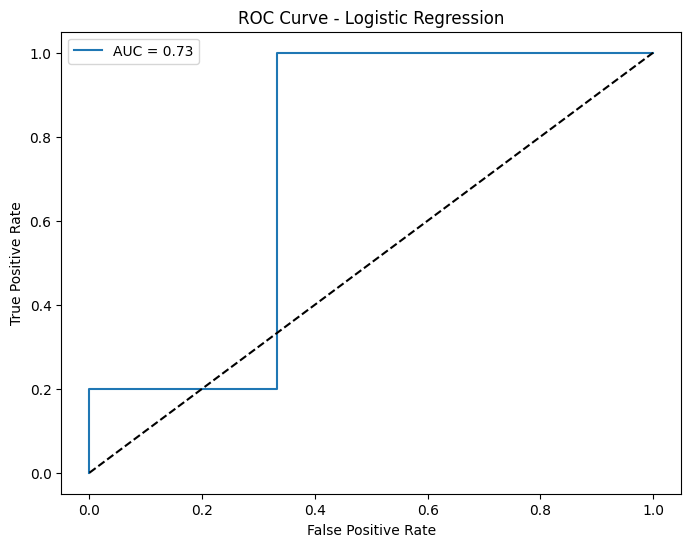

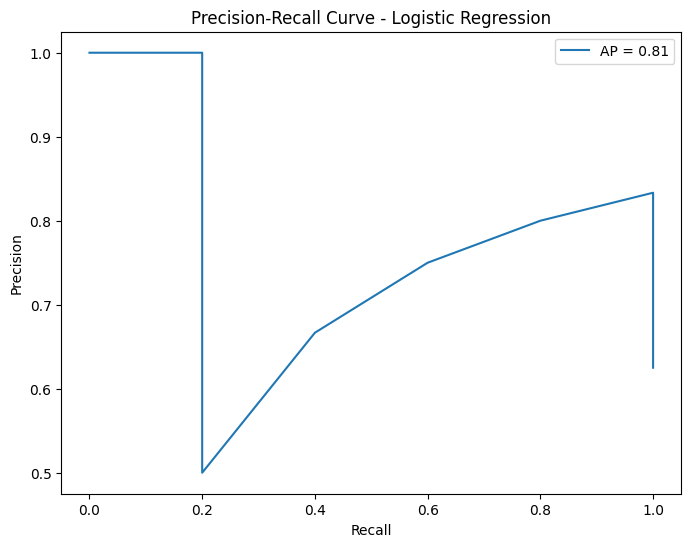

Feature importance not available for Logistic Regression.
Number of Misclassified Samples: 1
[INFO]: Logistic Regression evaluation completed.


Evaluating Random Forest...
Classification report for Random Forest:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.62      1.00      0.77         5

    accuracy                           0.62         8
   macro avg       0.31      0.50      0.38         8
weighted avg       0.39      0.62      0.48         8

Precision: 0.3906, Recall: 0.6250, F1 Score: 0.4808
Confusion Matrix:
[[0 3]
 [0 5]]


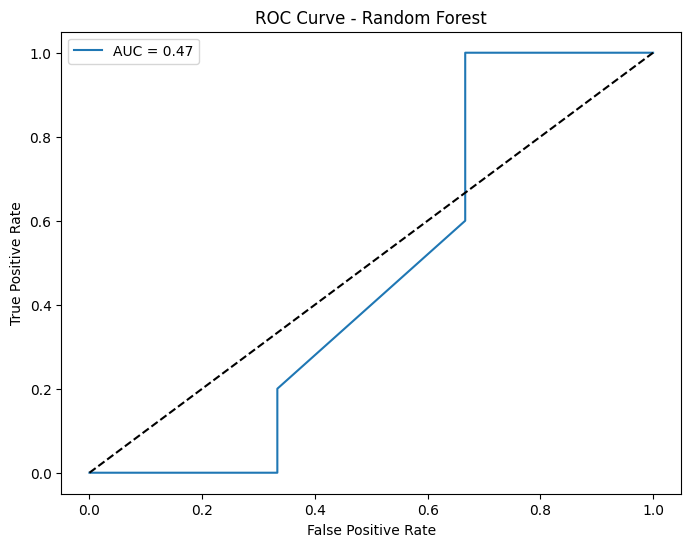

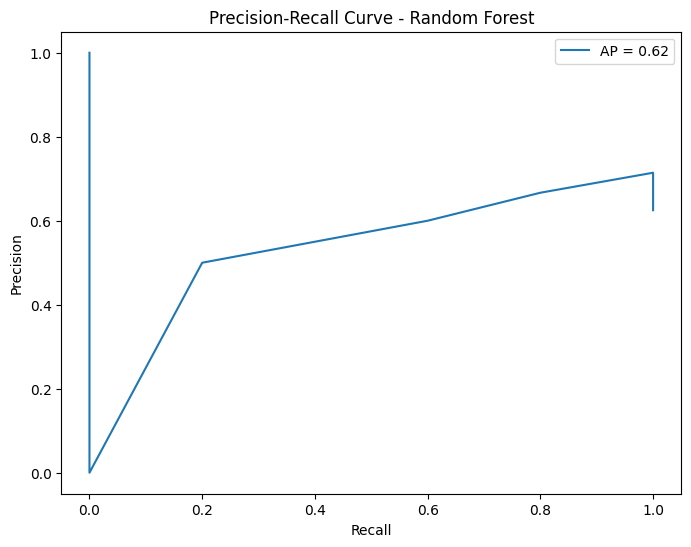

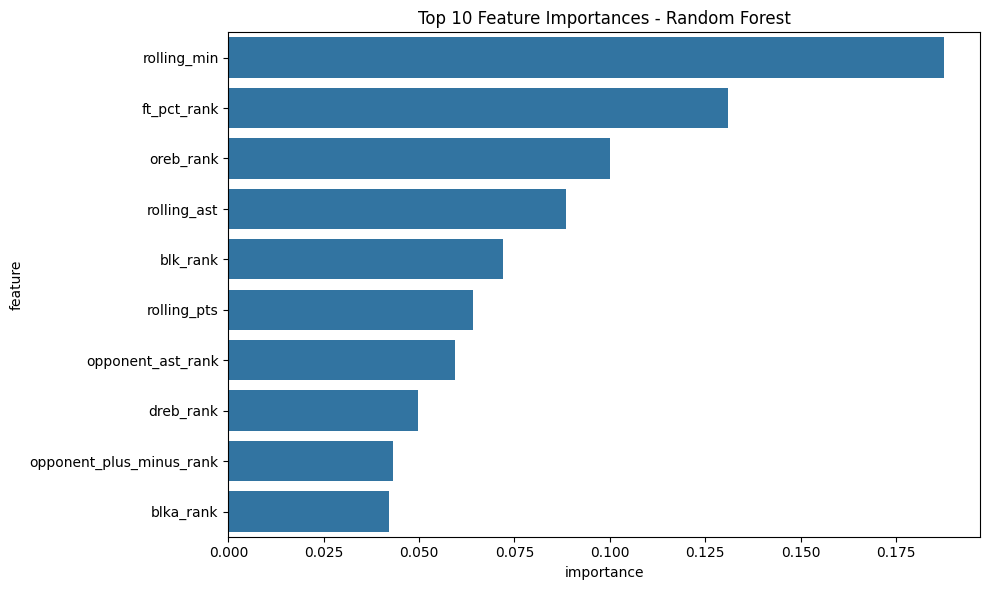

Number of Misclassified Samples: 3
[INFO]: Random Forest evaluation completed.


Evaluating Gradient Boosting...
Classification report for Gradient Boosting:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.60      0.55         5

    accuracy                           0.38         8
   macro avg       0.25      0.30      0.27         8
weighted avg       0.31      0.38      0.34         8

Precision: 0.3125, Recall: 0.3750, F1 Score: 0.3409
Confusion Matrix:
[[0 3]
 [2 3]]


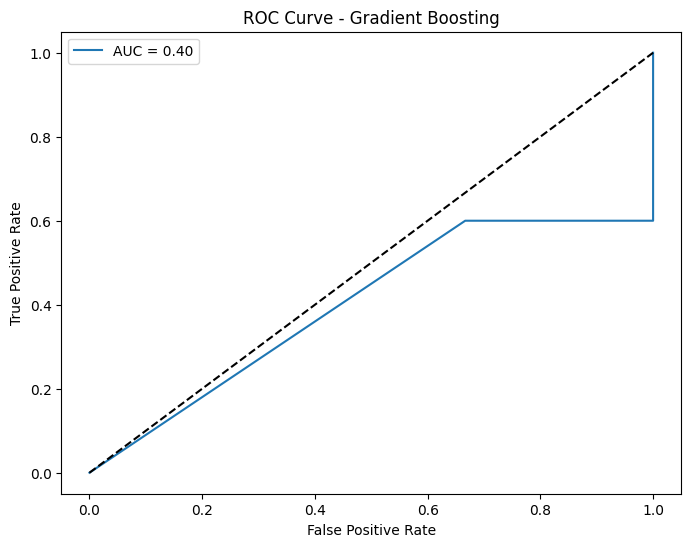

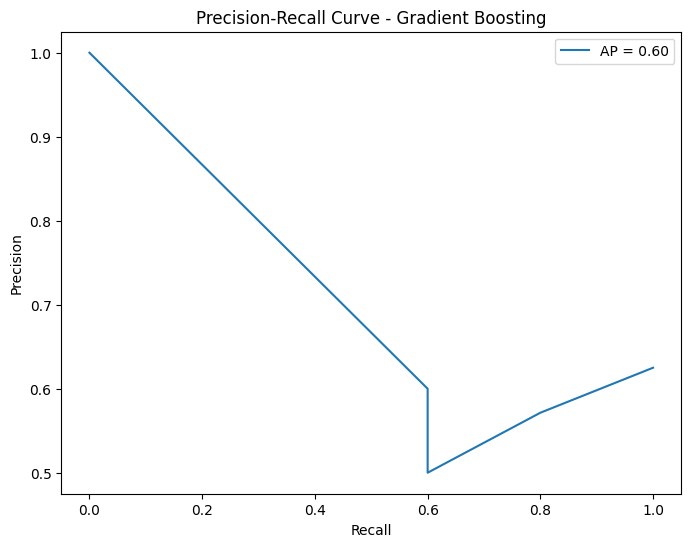

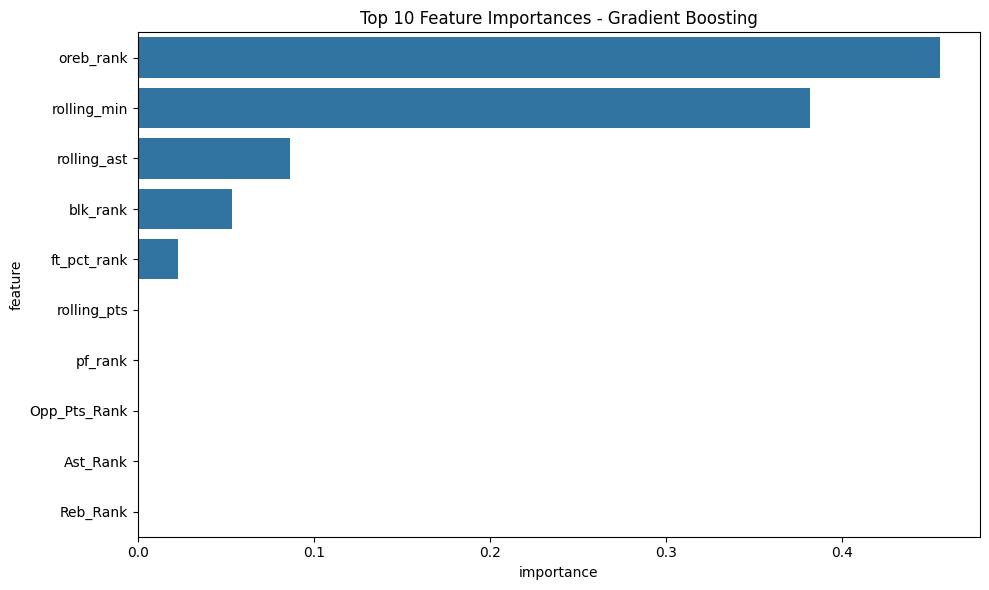

Number of Misclassified Samples: 5
[INFO]: Gradient Boosting evaluation completed.


Evaluating Neural Network...
Classification report for Neural Network:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.80      0.80      0.80         5

    accuracy                           0.75         8
   macro avg       0.73      0.73      0.73         8
weighted avg       0.75      0.75      0.75         8

Precision: 0.7500, Recall: 0.7500, F1 Score: 0.7500
Confusion Matrix:
[[2 1]
 [1 4]]


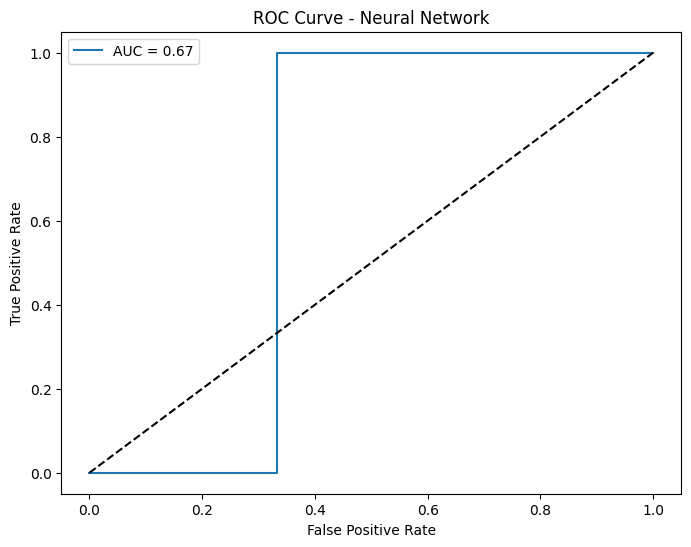

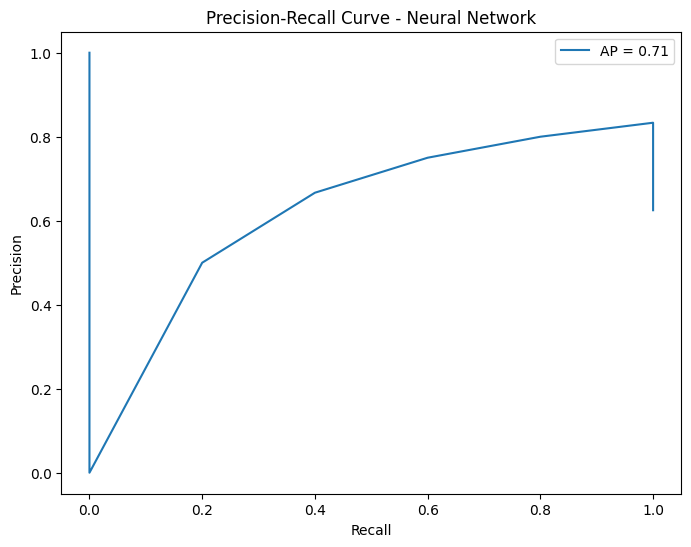

Feature importance not available for Neural Network.
Number of Misclassified Samples: 2
[INFO]: Neural Network evaluation completed.


Evaluating Voting Classifier Ensemble...
Classification report for Voting Classifier Ensemble:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.50      0.60      0.55         5

    accuracy                           0.38         8
   macro avg       0.25      0.30      0.27         8
weighted avg       0.31      0.38      0.34         8

Precision: 0.3125, Recall: 0.3750, F1 Score: 0.3409
Confusion Matrix:
[[0 3]
 [2 3]]


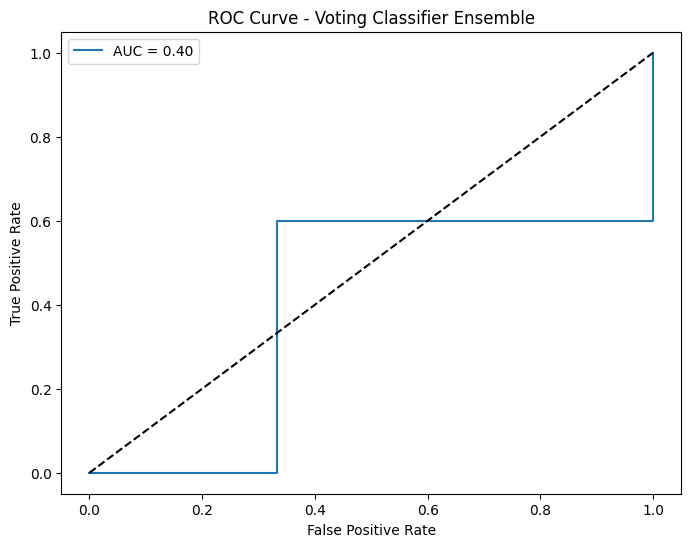

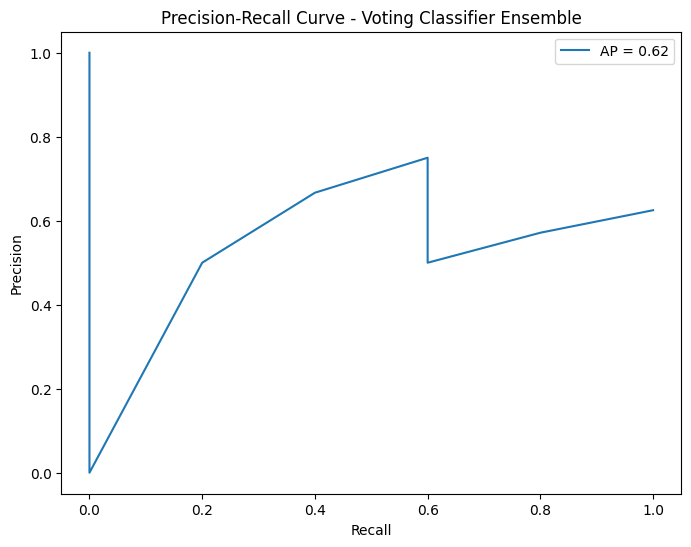

Feature importance not available for Voting Classifier Ensemble.
Number of Misclassified Samples: 5
[INFO]: Voting Classifier Ensemble evaluation completed.


Evaluating Stacking Classifier Ensemble...
Classification report for Stacking Classifier Ensemble:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.62      1.00      0.77         5

    accuracy                           0.62         8
   macro avg       0.31      0.50      0.38         8
weighted avg       0.39      0.62      0.48         8

Precision: 0.3906, Recall: 0.6250, F1 Score: 0.4808
Confusion Matrix:
[[0 3]
 [0 5]]


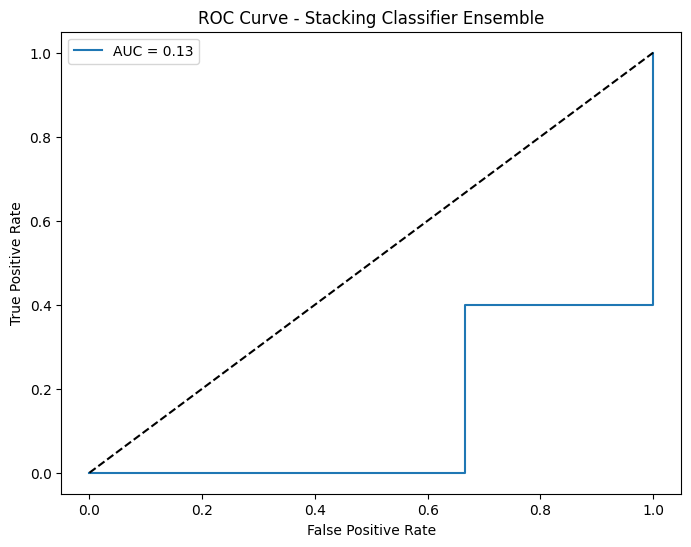

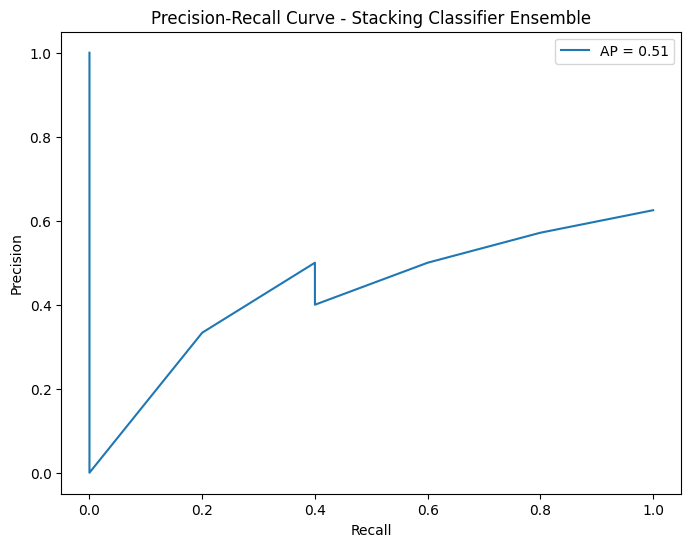

Feature importance not available for Stacking Classifier Ensemble.
Number of Misclassified Samples: 3
[INFO]: Stacking Classifier Ensemble evaluation completed.



Blended Prediction for Next Game:
Prediction: Over
Probability of Under: 0.35
Probability of Over: 0.65
Prediction for ast (stat line 4.5): Over
Probability of Under: 0.35
Probability of Over: 0.65


In [ ]:
players_stats = [
    {"name": "Cade Cunningham", "stat_col": "ast", "stat_line": 9.5},
    # {"name": "Jaylen Brown", "stat_col": "ast", "stat_line": 4.5},
    # {"name": "Kristaps Porzingis", "stat_col": "reb", "stat_line": 7.5},
    {"name": "Tyler Herro", "stat_col": "fg3m", "stat_line": 3.5},
    # {"name": "Jimmy Butler", "stat_col": "pts", "stat_line": 19.5},
    # {"name": "Tyrese Haliburton", "stat_col": "pts", "stat_line": 16.5},
    # {"name": "Benedict Mathurin", "stat_col": "reb", "stat_line": 5.5},
    {"name": "Giannis Antetokounmpo", "stat_col": "pts", "stat_line": 32.5},
    {"name": "Trae Young", "stat_col": "ast", "stat_line": 11.5},
    # {"name": "Shai Gilgeous-Alexander", "stat_col": "pts", "stat_line": 30.5},
    {"name": "Alperen Sengun", "stat_col": "ast", "stat_line": 4.5},
]

for player in players_stats:
    print(f"\n--- Processing {player['name']} ---")

    player_id = fetch_player_id(player["name"])
    seasons = ['2024-25', '2023-24']
    next_game_details = fetch_next_game_details(player_id, seasons[0])

    features, next_game_features = prepare_dataset_with_weights(
        player_id, ["2024-25", "2023-24"], player["stat_col"], player["stat_line"], "2024-25", next_game_details
    )

    models = train_and_blend_models(features, next_game_features)

    blended_probs = models['next_game_prediction']['probabilities']
    blended_prediction = models['next_game_prediction']['prediction']

    print(f"Prediction for {player['stat_col']} (stat line {player['stat_line']}): {blended_prediction}")
    print(f"Probability of Under: {blended_probs['Under']:.2f}")
    print(f"Probability of Over: {blended_probs['Over']:.2f}")
